# **Introduction**

In this section, two machine learning models will be used to classify the `vivo_ano5` column, Random Forest and XGBoost, for both datasets, São Paulo and other states.

The label is 1 if the patient is alive after five years of treatment and 0 if not.

The first approach is using the "raw data", the second is without the `EC` column, the third one is without `EC` and `HORMONIO`, the fourth is using the grouped years and without the column `EC` and the fifth is also with the years gruped and without `EC` and `HORMONIO`.

The years will be grouped as follows: 2000 to 2003, 2004 to 2007, 2008 to 2011, 2012 to 2015 and 2016 until the end. So we will have 5 datasets for SP and another 5 for other states.

Reading the data from SP and other states.

We can see that we still have some missing values in both datasets, but the columns `DTRECIDIVA`, `delta_t4`, `delta_t5` and `delta_t6` will not be used in this approach.

In [ ]:
df_SP = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/geral_sp_labels.csv')
df_fora = read_csv('/content/drive/MyDrive/Trabalho/Cancer/Datasets/geral_fora_sp_labels.csv')

(506037, 77)
(32891, 77)


Here we have the correlations between the label and the other columns, the columns with higher correlations will not be used as features of the models, because they may have been used to create the label, such as the ``ULTINFO`` column, or they can be used as label for other machine learning models.

In [ ]:
# SP
corr_matrix = df_SP.corr()
abs(corr_matrix['vivo_ano5']).sort_values(ascending = False).head(20)

vivo_ano5       1.000000
ULTIDIAG        0.829202
ULTITRAT        0.824152
ULTICONS        0.823421
vivo_ano3       0.688613
vivo_ano1       0.379191
obito_cancer    0.332117
ANODIAG         0.324126
obito_geral     0.294475
HORMONIO        0.198900
CATEATEND       0.177011
CIRURGIA        0.166085
MORFO           0.150870
ULTINFO         0.145083
G               0.118027
QUIMIO          0.098815
PSA             0.093765
GLEASON         0.092859
REGISTRADO      0.089388
CLINICA         0.072913
Name: vivo_ano5, dtype: float64

In [ ]:
# Other states
corr_matrix = df_fora.corr()
abs(corr_matrix['vivo_ano5']).sort_values(ascending = False).head(20)

vivo_ano5       1.000000
ULTIDIAG        0.818812
ULTICONS        0.816039
ULTITRAT        0.814230
vivo_ano3       0.667262
ANODIAG         0.378213
vivo_ano1       0.365313
obito_cancer    0.314455
obito_geral     0.301465
CATEATEND       0.271218
CIRURGIA        0.182209
HORMONIO        0.173752
ULTINFO         0.169878
REGISTRADO      0.149369
MORFO           0.132414
GLEASON         0.119970
PSA             0.118843
QUIMIO          0.089366
TRATCONS        0.083623
RADIO           0.064680
Name: vivo_ano5, dtype: float64

Here we have the number of examples for each category of the label, it is clear that there is an imbalance, similar to the previous classification. 

In [ ]:
df_SP.vivo_ano5.value_counts()

0    350104
1    155933
Name: vivo_ano5, dtype: int64

In [ ]:
df_fora.vivo_ano5.value_counts()

0    23443
1     9448
Name: vivo_ano5, dtype: int64

Years of diagnosis present in the data.

In [ ]:
np.sort(df_SP.ANODIAG.unique())

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

In [ ]:
np.sort(df_fora.ANODIAG.unique())

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

Before dividing the datasets, it is necessary to select only the patients who have been followed up for at least five years.

In [ ]:
df_SP_ano5 = df_SP[~((df_SP.obito_geral == 0) & (df_SP.vivo_ano5 == 0))]
df_SP_ano5.shape

(348678, 77)

In [ ]:
df_fora_ano5 = df_fora[~((df_fora.obito_geral == 0) & (df_fora.vivo_ano5 == 0))]
df_fora_ano5.shape

(20559, 77)

# **First approach**

Approach with "raw data".

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the datasets: `UFRESID`, because we already have the division between SP and other states in the two datasets. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'obito_geral', 'obito_cancer', 'vivo_ano1', 'vivo_ano3', 'ULTINFO']

# 'RECNENHUM', 'RECLOCAL', 'RECREGIO', 'REC01', 'REC02', 'REC03', 'RECDIST'

lb = 'vivo_ano5'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_train_SP, X_test_SP, y_train_SP, y_test_SP, feat_cols_SP = preprocessing(df_SP_ano5, list_drop, lb, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (261508, 66), X_test = (87170, 66)
y_train = (261508,), y_test = (87170,)


**Other states**

In [ ]:
X_train_OS, X_test_OS, y_train_OS, y_test_OS, feat_cols_OS = preprocessing(df_fora_ano5, list_drop, lb, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (15419, 66), X_test = (5140, 66)
y_train = (15419,), y_test = (5140,)


## **Training machine learning models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test the parameter `random_state` will be used, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was also used, because the model has difficulty learning the class with fewer examples, so using this parameter this class will have a higher weight in the training of the model.

In [ ]:
# SP 
rf_sp = RandomForestClassifier(class_weight={0:1, 1:1.06}, 
                               random_state=seed,
                               criterion='entropy',
                               max_depth=10)

rf_sp.fit(X_train_SP, y_train_SP)

RandomForestClassifier(class_weight={0: 1, 1: 1.06}, criterion='entropy',
                       max_depth=10, random_state=10)

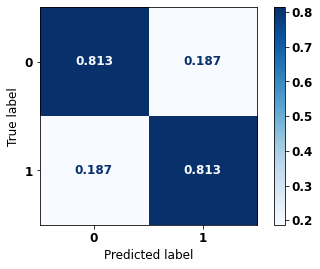


              precision    recall  f1-score   support

           0      0.843     0.813     0.828     48187
           1      0.779     0.813     0.796     38983

    accuracy                          0.813     87170
   macro avg      0.811     0.813     0.812     87170
weighted avg      0.814     0.813     0.814     87170



In [ ]:
display_confusion_matrix(rf_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the Random Forest, with SP data, shows a good performance of the model, with 81% of accuracy.


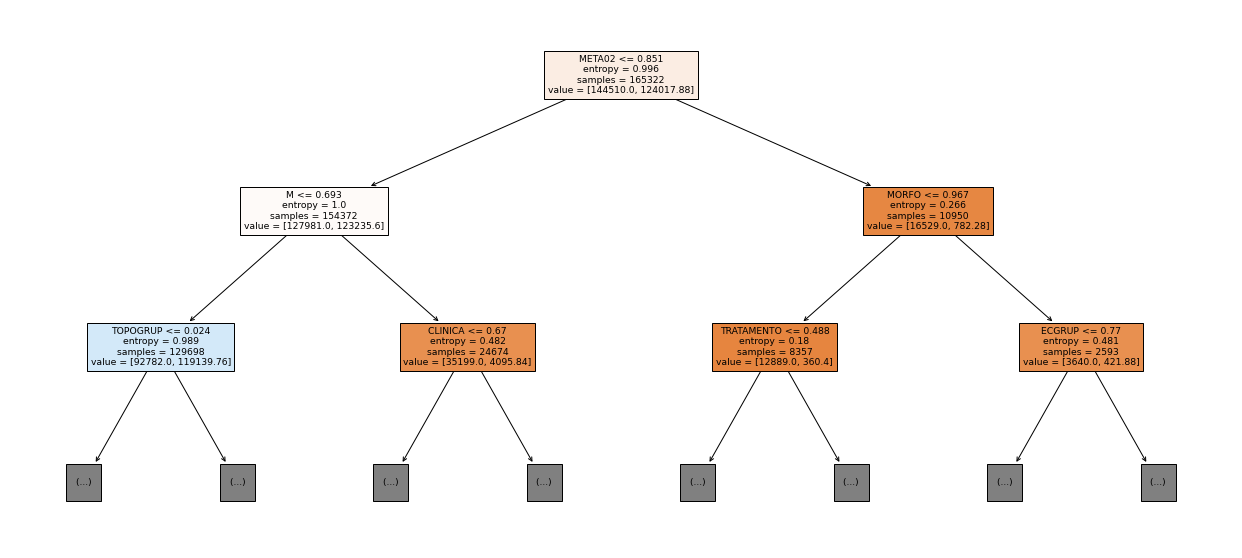

In [ ]:
show_tree(rf_sp, feat_cols_SP, 2)

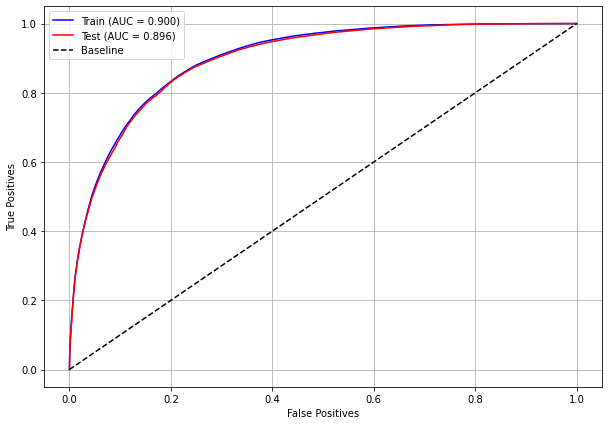

In [ ]:
plot_roc_curve(rf_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

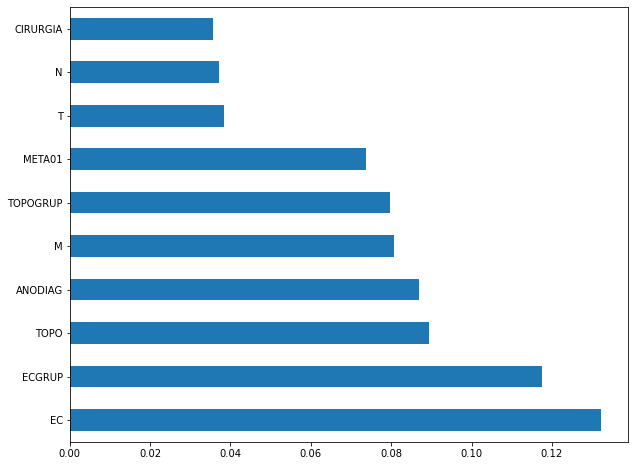

In [ ]:
plot_feat_importances(rf_sp, feat_cols_SP)

> The four most important features in the model were `EC`, `ECGRUP`, `TOPO` and `ANODIAG`.

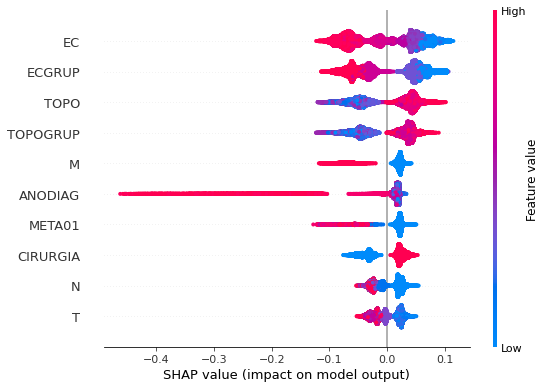

In [ ]:
plot_shap_values(rf_sp, X_test_SP, feat_cols_SP)

Note that larger values of the `EC` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states
rf_fora = RandomForestClassifier(class_weight={0:1.02, 1:1}, 
                                 random_state=seed,
                                 criterion='entropy',
                                 max_depth=8)

rf_fora.fit(X_train_OS, y_train_OS)

RandomForestClassifier(class_weight={0: 1.02, 1: 1}, criterion='entropy',
                       max_depth=8, random_state=10)

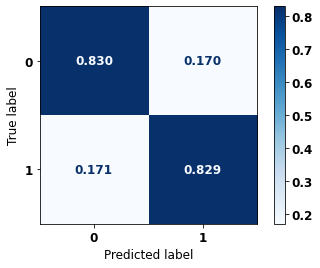


              precision    recall  f1-score   support

           0      0.851     0.830     0.841      2778
           1      0.806     0.829     0.817      2362

    accuracy                          0.830      5140
   macro avg      0.829     0.830     0.829      5140
weighted avg      0.830     0.830     0.830      5140



In [ ]:
display_confusion_matrix(rf_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the Random Forest algorithm, with other states data, shows a good performance of the model, because the model achieves a 83% of accuracy.


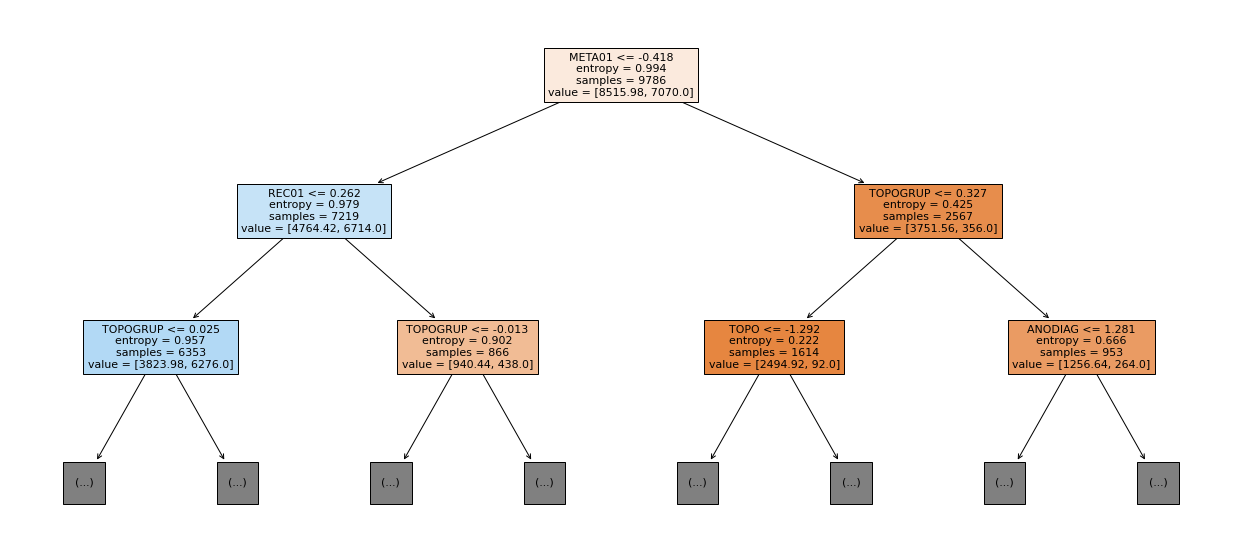

In [ ]:
show_tree(rf_fora, feat_cols_OS, 2)

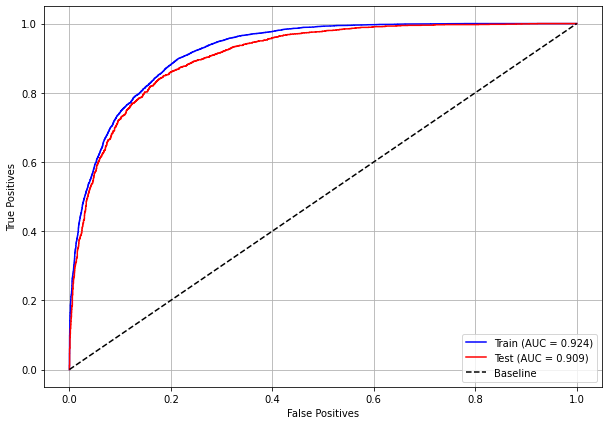

In [ ]:
plot_roc_curve(rf_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

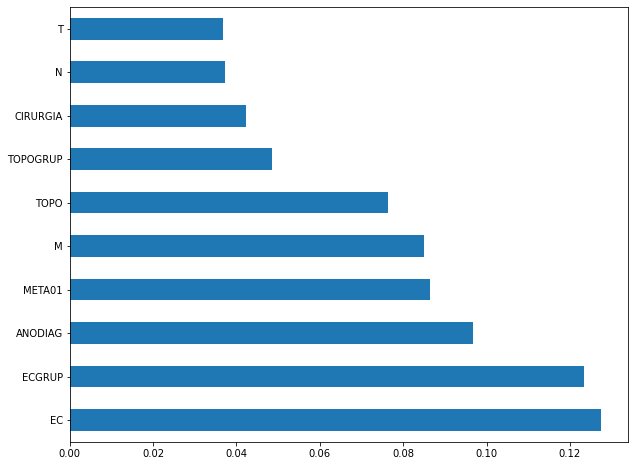

In [ ]:
plot_feat_importances(rf_fora, feat_cols_OS)

> The four most important features in the model were `EC`, `ECGRUP`, `ANODIAG` and `META01`.

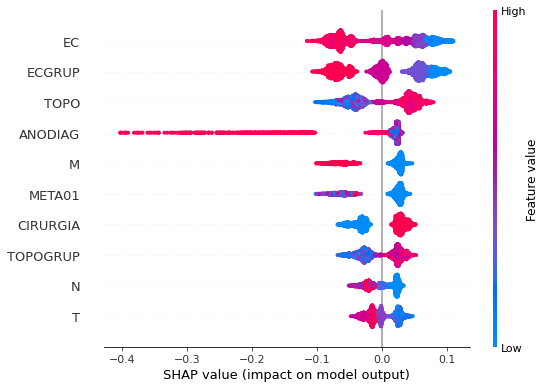

In [ ]:
plot_shap_values(rf_fora, X_test_OS, feat_cols_OS)

Note that larger values of the `EC` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

#### **Randomized Grid Search**

In [ ]:
# RandomizedSearchCV
hyperRF = {'n_estimators': [100, 150, 200, 250],
           'max_depth': [5, 8, 10, 12, 15],
           'min_samples_split': [2, 5, 10, 15],
           'min_samples_leaf': [1, 2, 5, 10]} 

rf = RandomForestClassifier(random_state=seed, criterion='entropy')

randRS = RandomizedSearchCV(rf, hyperRF, n_iter=20, cv=5, n_jobs=-1, 
                            random_state=seed)

In [ ]:
# SP
bestSP = randRS.fit(X_train_SP, y_train_SP)

In [ ]:
bestSP.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 15}

In [ ]:
# SP
rf_sp_opt = bestSP.best_estimator_
rf_sp_opt.set_params(class_weight={0:1, 1:1.075})

rf_sp_opt.fit(X_train_SP, y_train_SP)

RandomForestClassifier(class_weight={0: 1, 1: 1.075}, criterion='entropy',
                       max_depth=15, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, random_state=10)

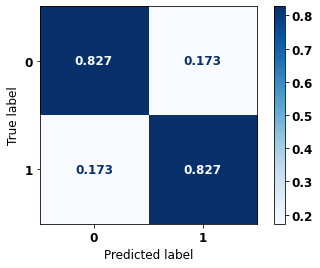


              precision    recall  f1-score   support

           0      0.856     0.827     0.841     48187
           1      0.795     0.827     0.811     38983

    accuracy                          0.827     87170
   macro avg      0.825     0.827     0.826     87170
weighted avg      0.828     0.827     0.827     87170



In [ ]:
display_confusion_matrix(rf_sp_opt, X_test_SP, y_test_SP)

In [ ]:
# Other States
bestOS = randRS.fit(X_train_OS, y_train_OS)

In [ ]:
bestOS.best_params_

{'n_estimators': 200,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 15}

In [ ]:
# Other states
rf_fora_opt = bestOS.best_estimator_
rf_fora_opt.set_params(class_weight={0:1, 1:1.03})

rf_fora_opt.fit(X_train_OS, y_train_OS)

RandomForestClassifier(class_weight={0: 1, 1: 1.03}, criterion='entropy',
                       max_depth=15, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, random_state=10)

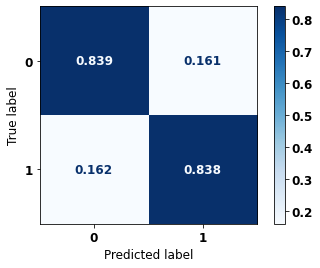


              precision    recall  f1-score   support

           0      0.859     0.839     0.849      2778
           1      0.816     0.838     0.827      2362

    accuracy                          0.839      5140
   macro avg      0.838     0.839     0.838      5140
weighted avg      0.839     0.839     0.839      5140



In [ ]:
display_confusion_matrix(rf_fora_opt, X_test_OS, y_test_OS)

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A higher weight was also used for the class with fewer examples, using the hyperparameter `scale_pos_weight`.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = XGBClassifier(max_depth=10, 
                           scale_pos_weight=1.1,
                           random_state=seed)

xgboost_sp.fit(X_train_SP, y_train_SP)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.1)

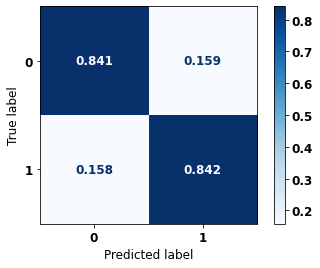


              precision    recall  f1-score   support

           0      0.868     0.841     0.854     48187
           1      0.810     0.842     0.826     38983

    accuracy                          0.841     87170
   macro avg      0.839     0.841     0.840     87170
weighted avg      0.842     0.841     0.841     87170



In [ ]:
display_confusion_matrix(xgboost_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the XGBoost, with SP data, shows a good performance of the model, with 84% of accuracy.


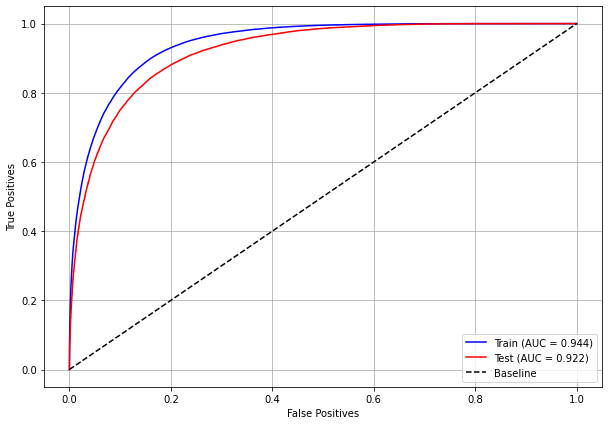

In [ ]:
plot_roc_curve(xgboost_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

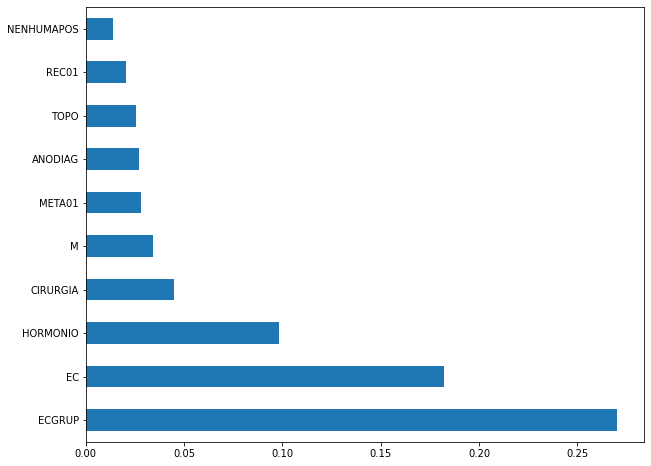

In [ ]:
plot_feat_importances(xgboost_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `EC`, `HORMONIO` and `CIRURGIA`.

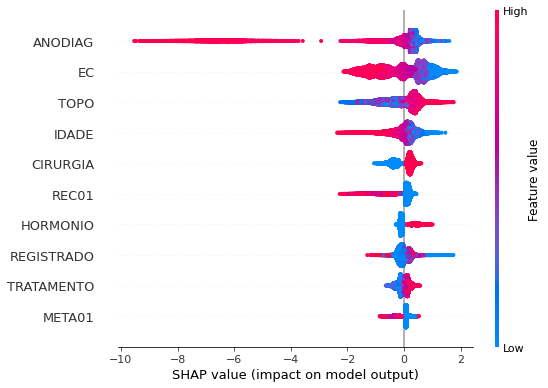

In [ ]:
plot_shap_values(xgboost_sp, X_test_SP, feat_cols_SP)

Note that larger values of the `ANODIAG` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1.  

The other columns shown follow the same logic.

In [ ]:
# Other states 
xgboost_fora = XGBClassifier(max_depth=8, 
                                 scale_pos_weight=1.17,
                                 random_state=seed)

xgboost_fora.fit(X_train_OS, y_train_OS)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=1.17)

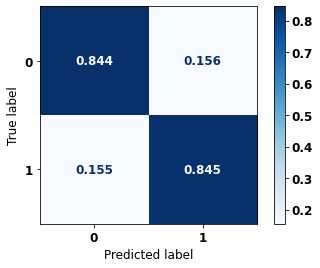


              precision    recall  f1-score   support

           0      0.865     0.844     0.854      2778
           1      0.822     0.845     0.833      2362

    accuracy                          0.845      5140
   macro avg      0.843     0.845     0.844      5140
weighted avg      0.845     0.845     0.845      5140



In [ ]:
display_confusion_matrix(xgboost_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the XGBoost algorithm, with other states data, shows a good performance of the model, because the model achieves a 84% of accuracy.


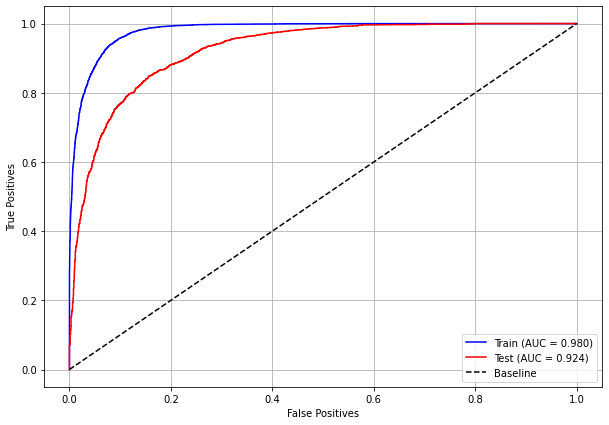

In [ ]:
plot_roc_curve(xgboost_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

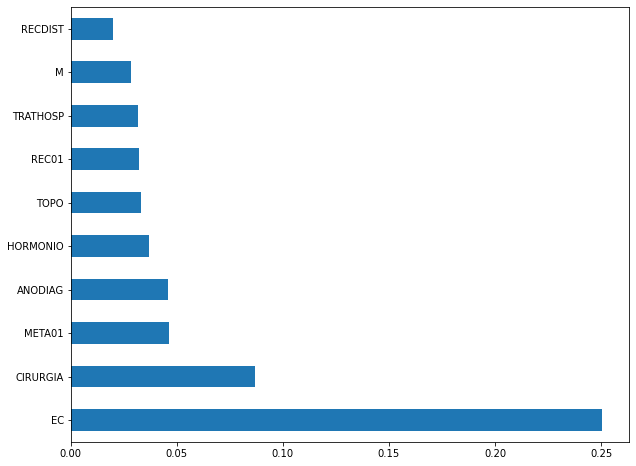

In [ ]:
plot_feat_importances(xgboost_fora, feat_cols_OS)

> The four most important features in the model were `EC`, `CIRURGIA`, `META01` and `ANODIAG`.

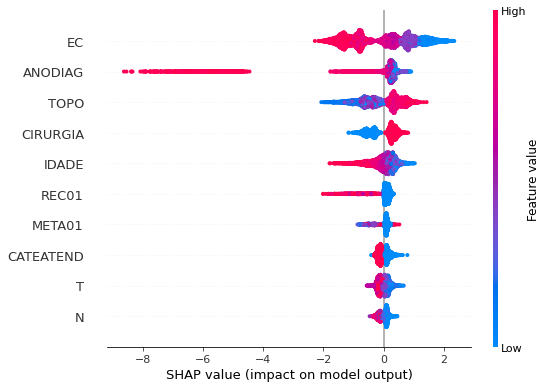

In [ ]:
plot_shap_values(xgboost_fora, X_test_OS, feat_cols_OS)

Note that larger values of the `EC` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

#### **Randomized Grid Search**

In [ ]:
# RandomizedSearchCV
hyperXGB = {'learning_rate': [0.05, 0.10, 0.15, 0.20],
            'max_depth': [5, 8, 10, 12, 15],
            'min_child_weight': [1, 3, 5, 7],
            'gamma': [0.0, 0.1, 0.2 , 0.3],
            'colsample_bytree': [0.3, 0.4, 0.5, 0.7],
            'n_estimators': [100, 150, 200, 250]}

xgboost = XGBClassifier(random_state=seed)
xgbRS = RandomizedSearchCV(xgboost, hyperXGB, n_iter=20, cv=5, n_jobs=-1, 
                           random_state=seed)

In [ ]:
# SP
bestSP = xgbRS.fit(X_train_SP, y_train_SP)

In [ ]:
bestSP.best_params_

{'n_estimators': 200,
 'min_child_weight': 5,
 'max_depth': 10,
 'learning_rate': 0.1,
 'gamma': 0.2,
 'colsample_bytree': 0.4}

In [ ]:
# SP
xgb_sp_opt = bestSP.best_estimator_
xgb_sp_opt.set_params(scale_pos_weight=1.1)

xgb_sp_opt.fit(X_train_SP, y_train_SP)

XGBClassifier(colsample_bytree=0.4, gamma=0.2, max_depth=10, min_child_weight=5,
              n_estimators=200, random_state=10, scale_pos_weight=1.1)

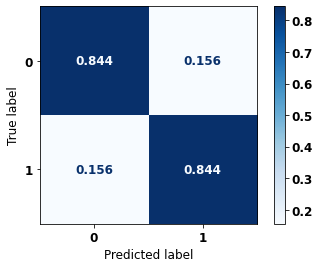


              precision    recall  f1-score   support

           0      0.870     0.844     0.857     48187
           1      0.814     0.844     0.829     38983

    accuracy                          0.844     87170
   macro avg      0.842     0.844     0.843     87170
weighted avg      0.845     0.844     0.845     87170



In [ ]:
display_confusion_matrix(xgb_sp_opt, X_test_SP, y_test_SP)

In [ ]:
# Other States
bestOS = xgbRS.fit(X_train_OS, y_train_OS)

In [ ]:
bestOS.best_params_

{'n_estimators': 150,
 'min_child_weight': 7,
 'max_depth': 8,
 'learning_rate': 0.05,
 'gamma': 0.2,
 'colsample_bytree': 0.4}

In [ ]:
# Other states
xgb_fora_opt = bestOS.best_estimator_
xgb_fora_opt.set_params(scale_pos_weight=1.1)

xgb_fora_opt.fit(X_train_OS, y_train_OS)

XGBClassifier(colsample_bytree=0.4, gamma=0.2, learning_rate=0.05, max_depth=8,
              min_child_weight=7, n_estimators=150, random_state=10,
              scale_pos_weight=1.1)

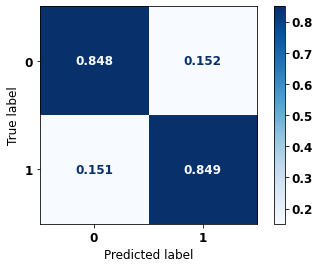


              precision    recall  f1-score   support

           0      0.868     0.848     0.858      2778
           1      0.826     0.849     0.837      2362

    accuracy                          0.848      5140
   macro avg      0.847     0.848     0.848      5140
weighted avg      0.849     0.848     0.848      5140



In [ ]:
display_confusion_matrix(xgb_fora_opt, X_test_OS, y_test_OS)

# **Second approach**

Approach without column `EC` as a feature.

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the datasets: `UFRESID`, because we already have the division between SP and other states in the two datasets. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'obito_geral', 'obito_cancer', 'vivo_ano1', 'vivo_ano3',
             'ULTINFO', 'EC']

# 'RECNENHUM', 'RECLOCAL', 'RECREGIO', 'REC01', 'REC02', 'REC03', 'RECDIST'

lb = 'vivo_ano5'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_train_SP, X_test_SP, y_train_SP, y_test_SP, feat_cols_SP = preprocessing(df_SP_ano5, list_drop, lb, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (261508, 65), X_test = (87170, 65)
y_train = (261508,), y_test = (87170,)


**Other states**

In [ ]:
X_train_OS, X_test_OS, y_train_OS, y_test_OS, feat_cols_OS = preprocessing(df_fora_ano5, list_drop, lb, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (15419, 65), X_test = (5140, 65)
y_train = (15419,), y_test = (5140,)


## **Training machine learning models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test the parameter `random_state` will be used, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was also used, because the model has difficulty learning the class with fewer examples, so using this parameter this class will have a higher weight in the training of the model.

In [ ]:
# SP 
rf_sp = RandomForestClassifier(class_weight={0:1, 1:1.054}, 
                               random_state=seed,
                               criterion='entropy',
                               max_depth=10)

rf_sp.fit(X_train_SP, y_train_SP)

RandomForestClassifier(class_weight={0: 1, 1: 1.054}, criterion='entropy',
                       max_depth=10, random_state=10)

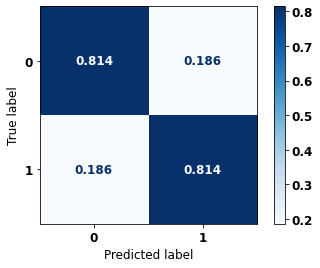


              precision    recall  f1-score   support

           0      0.844     0.814     0.829     48187
           1      0.780     0.814     0.797     38983

    accuracy                          0.814     87170
   macro avg      0.812     0.814     0.813     87170
weighted avg      0.815     0.814     0.815     87170



In [ ]:
display_confusion_matrix(rf_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the Random Forest, with SP data, shows a good performance of the model, with 81% of accuracy.


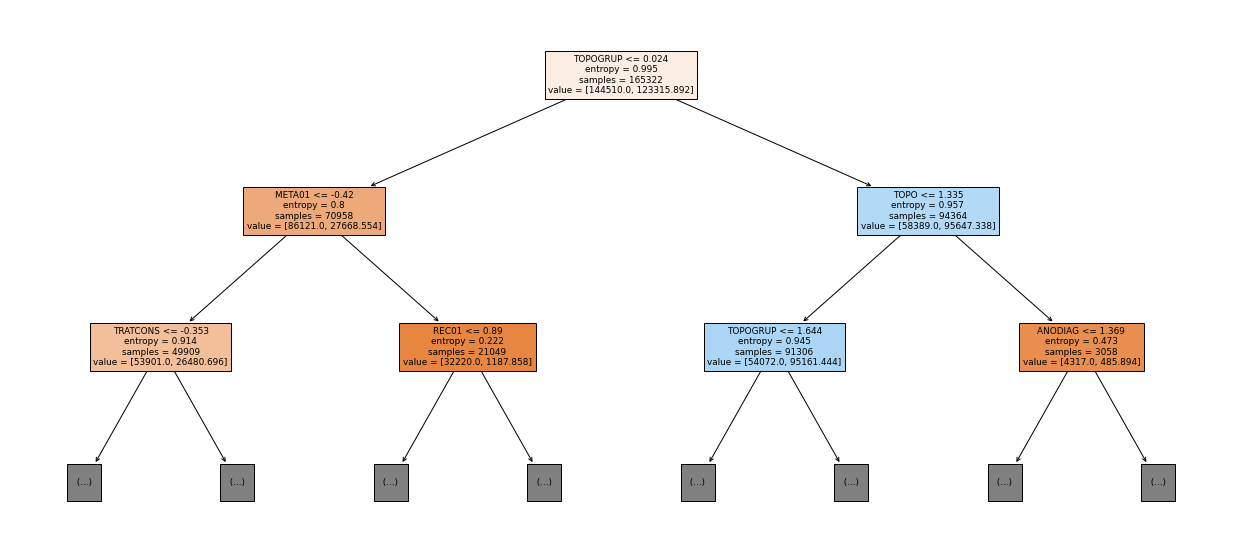

In [ ]:
show_tree(rf_sp, feat_cols_SP, 2)

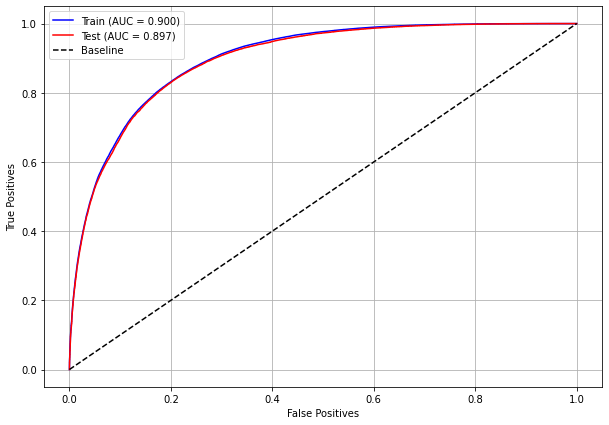

In [ ]:
plot_roc_curve(rf_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

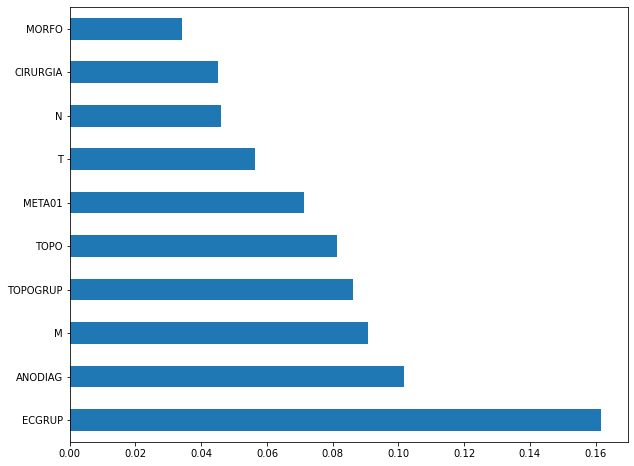

In [ ]:
plot_feat_importances(rf_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `ANODIAG`, `M` and `TOPOGRUP`.

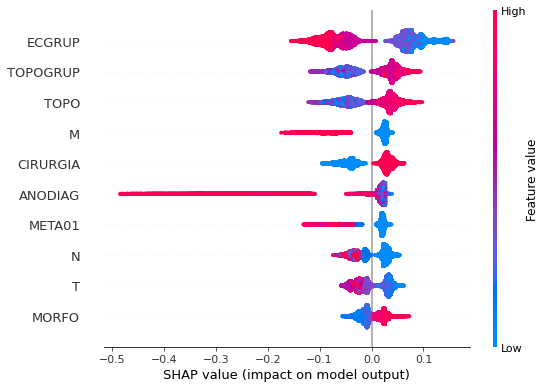

In [ ]:
plot_shap_values(rf_sp, X_test_SP, feat_cols_SP)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states
rf_fora = RandomForestClassifier(class_weight={0:1.07, 1:1}, 
                                 random_state=seed,
                                 criterion='entropy',
                                 max_depth=8)

rf_fora.fit(X_train_OS, y_train_OS)

RandomForestClassifier(class_weight={0: 1.07, 1: 1}, criterion='entropy',
                       max_depth=8, random_state=10)

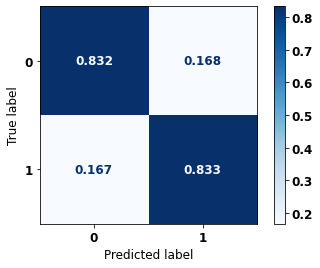


              precision    recall  f1-score   support

           0      0.854     0.832     0.843      2778
           1      0.808     0.833     0.820      2362

    accuracy                          0.832      5140
   macro avg      0.831     0.832     0.831      5140
weighted avg      0.833     0.832     0.832      5140



In [ ]:
display_confusion_matrix(rf_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the Random Forest algorithm, with other states data, shows a good performance of the model, because the model achieves a 83% of accuracy.


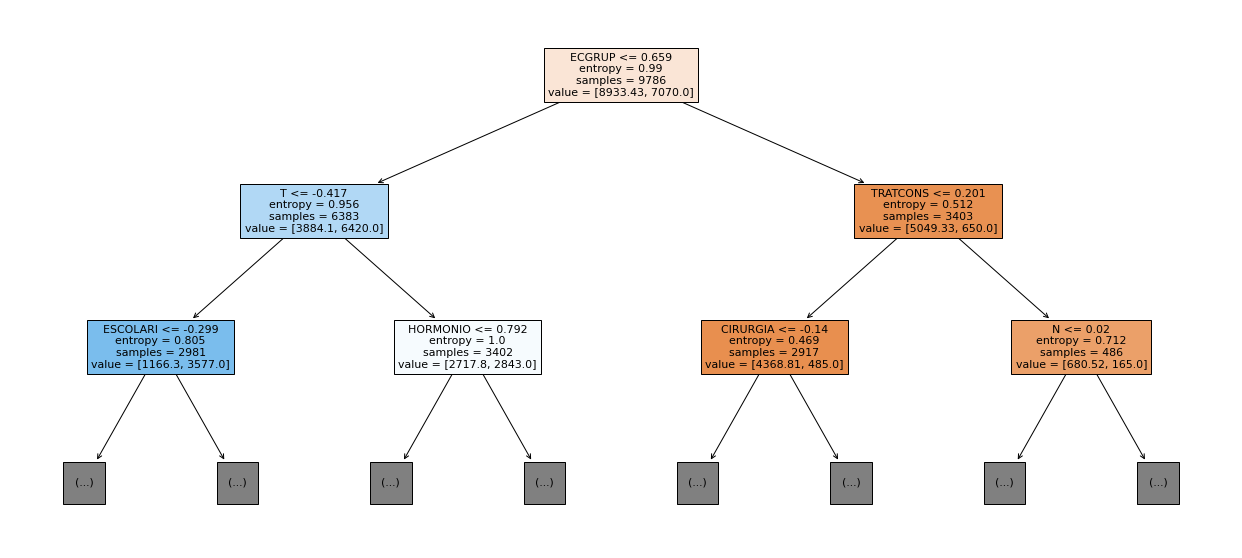

In [ ]:
show_tree(rf_fora, feat_cols_OS, 2)

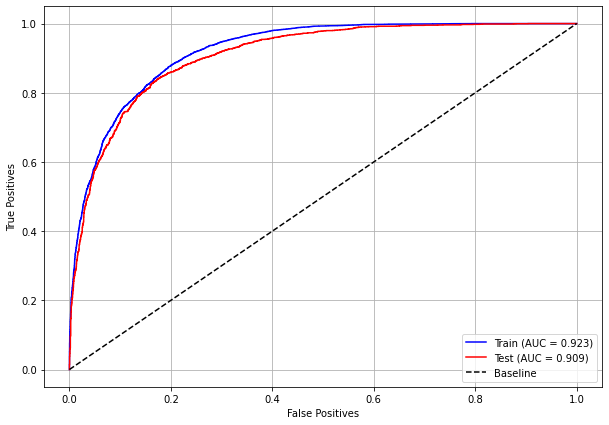

In [ ]:
plot_roc_curve(rf_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

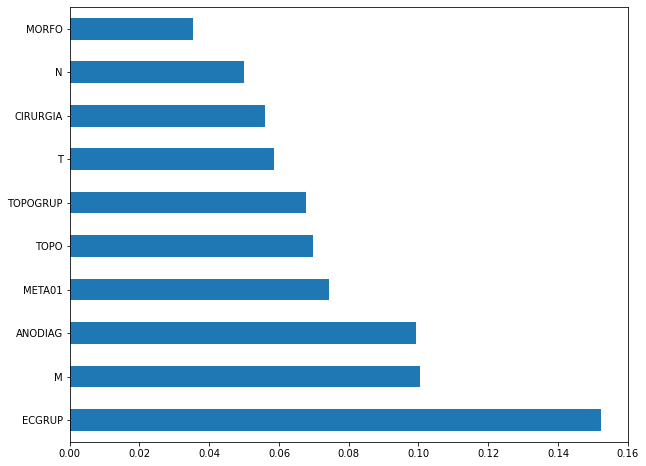

In [ ]:
plot_feat_importances(rf_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, `M`, `ANODIAG` and `META01`.

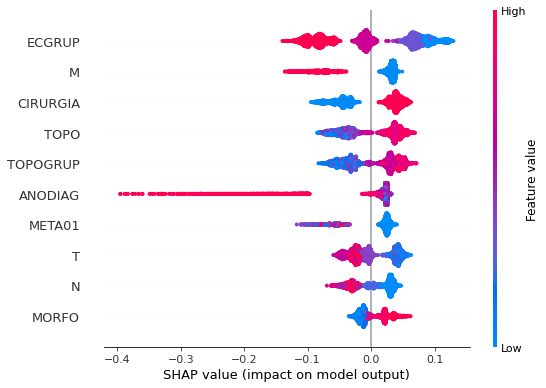

In [ ]:
plot_shap_values(rf_fora, X_test_OS, feat_cols_OS)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A higher weight was also used for the class with fewer examples, using the hyperparameter `scale_pos_weight`.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = XGBClassifier(max_depth=10, 
                           scale_pos_weight=1.1,
                           random_state=seed)

xgboost_sp.fit(X_train_SP, y_train_SP)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.1)

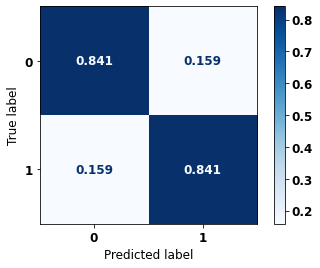


              precision    recall  f1-score   support

           0      0.867     0.841     0.854     48187
           1      0.811     0.841     0.825     38983

    accuracy                          0.841     87170
   macro avg      0.839     0.841     0.840     87170
weighted avg      0.842     0.841     0.841     87170



In [ ]:
display_confusion_matrix(xgboost_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the XGBoost, with SP data, shows a good performance of the model, with 84% of accuracy.


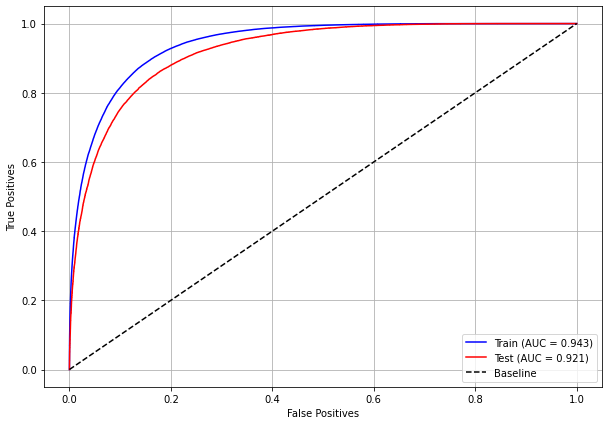

In [ ]:
plot_roc_curve(xgboost_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

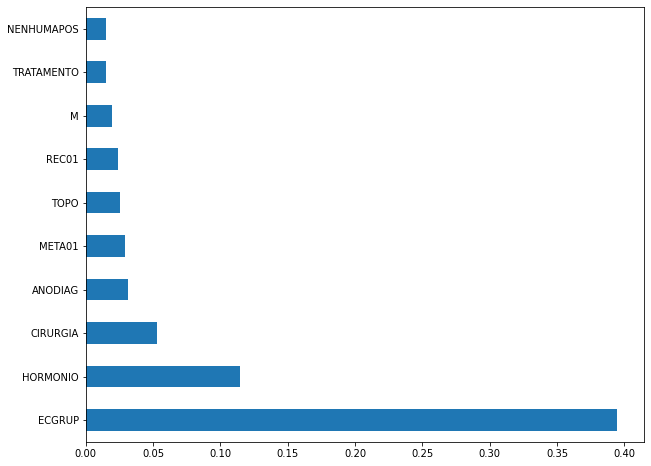

In [ ]:
plot_feat_importances(xgboost_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `HORMONIO`, `CIRURGIA` and `ANODIAG`.

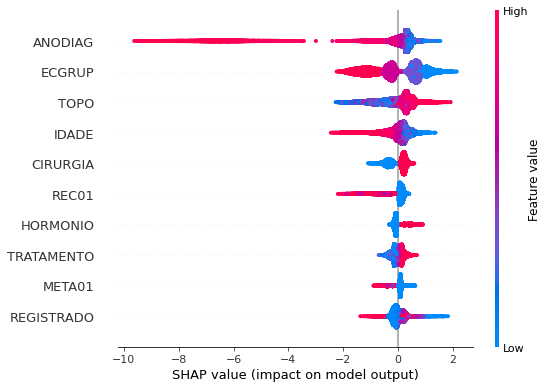

In [ ]:
plot_shap_values(xgboost_sp, X_test_SP, feat_cols_SP)

Note that larger values of the `ANODIAG` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1.  

The other columns shown follow the same logic.

In [ ]:
# Other states 
xgboost_fora = XGBClassifier(max_depth=8, 
                             scale_pos_weight=1.14,
                             random_state=seed)

xgboost_fora.fit(X_train_OS, y_train_OS)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=1.14)

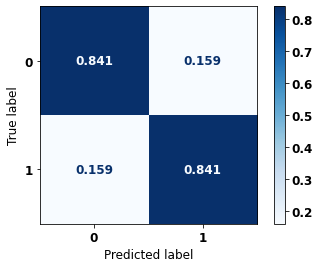


              precision    recall  f1-score   support

           0      0.862     0.841     0.851      2778
           1      0.818     0.841     0.829      2362

    accuracy                          0.841      5140
   macro avg      0.840     0.841     0.840      5140
weighted avg      0.841     0.841     0.841      5140



In [ ]:
display_confusion_matrix(xgboost_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the XGBoost algorithm, with other states data, shows a good performance of the model, because the model achieves a 84% of accuracy.


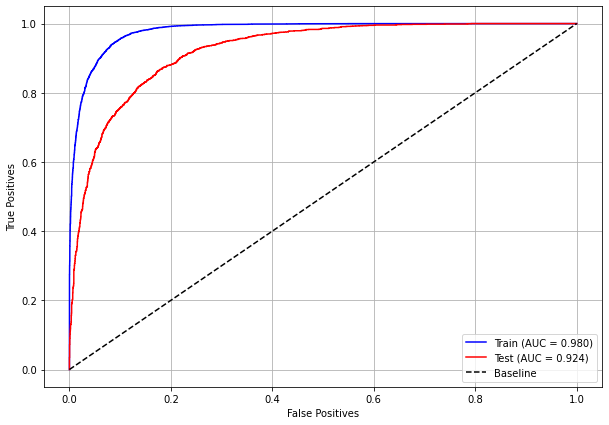

In [ ]:
plot_roc_curve(xgboost_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

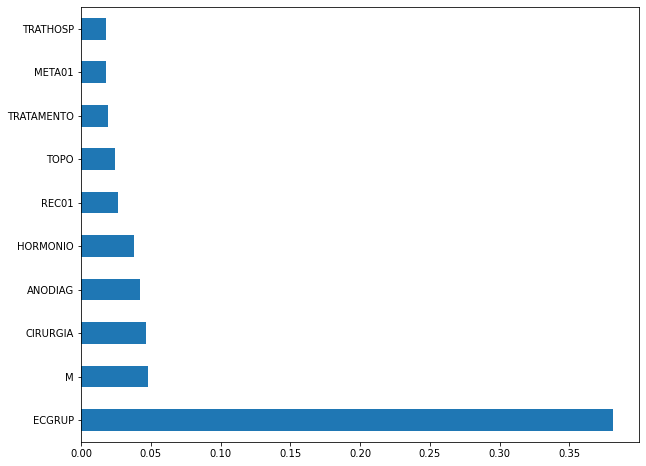

In [ ]:
plot_feat_importances(xgboost_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, with a good advantage, `HORMONIO`, `ANODIAG` and `CIRURGIA`.

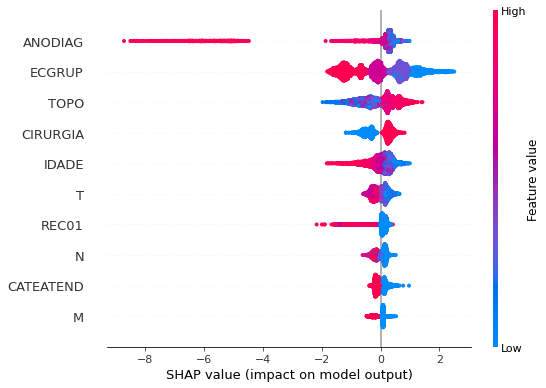

In [ ]:
plot_shap_values(xgboost_fora, X_test_OS, feat_cols_OS)

Note that larger values of the `ANODIAG` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1.  

The other columns shown follow the same logic.

# **Third approach**

Approach without columns `EC` and `HORMONIO` as features.

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the datasets: `UFRESID`, because we already have the division between SP and other states in the two datasets.

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'obito_geral', 'obito_cancer', 'vivo_ano1', 'vivo_ano3', 
             'ULTINFO', 'EC', 'HORMONIO']

# 'RECNENHUM', 'RECLOCAL', 'RECREGIO', 'REC01', 'REC02', 'REC03', 'RECDIST'

lb = 'vivo_ano5'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

**SP**

In [ ]:
X_train_SP, X_test_SP, y_train_SP, y_test_SP, feat_cols_SP = preprocessing(df_SP_ano5, list_drop, lb, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (261508, 64), X_test = (87170, 64)
y_train = (261508,), y_test = (87170,)


**Other states**

In [ ]:
X_train_OS, X_test_OS, y_train_OS, y_test_OS, feat_cols_OS = preprocessing(df_fora_ano5, list_drop, lb, 
                                                                           random_state=seed,
                                                                           balance_data=False,
                                                                           encoder_type='LabelEncoder', 
                                                                           norm_name='StandardScaler')

X_train = (15419, 64), X_test = (5140, 64)
y_train = (15419,), y_test = (5140,)


## **Training machine learning models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model that will be tested is the Random Forest, for this test the parameter `random_state` will be used, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was also used, because the model has difficulty learning the class with fewer examples, so using this parameter this class will have a higher weight in the training of the model.

In [ ]:
# SP 
rf_sp = RandomForestClassifier(class_weight={0:1, 1:1.047}, 
                               random_state=seed,
                               criterion='entropy',
                               max_depth=10)

rf_sp.fit(X_train_SP, y_train_SP)

RandomForestClassifier(class_weight={0: 1, 1: 1.047}, criterion='entropy',
                       max_depth=10, random_state=10)

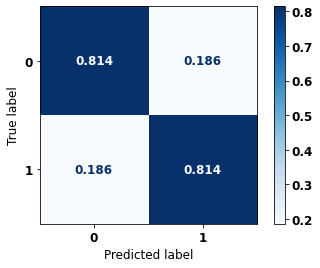


              precision    recall  f1-score   support

           0      0.844     0.814     0.829     48187
           1      0.780     0.814     0.797     38983

    accuracy                          0.814     87170
   macro avg      0.812     0.814     0.813     87170
weighted avg      0.815     0.814     0.814     87170



In [ ]:
display_confusion_matrix(rf_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the Random Forest, with SP data, shows a good performance of the model, with 81% of accuracy.


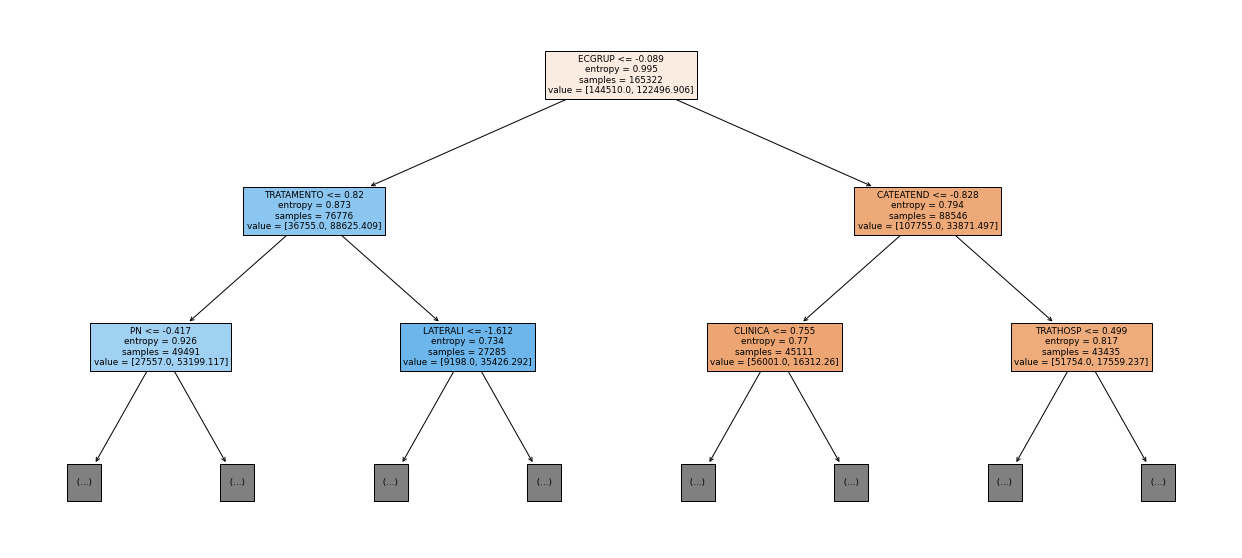

In [ ]:
show_tree(rf_sp, feat_cols_SP, 2)

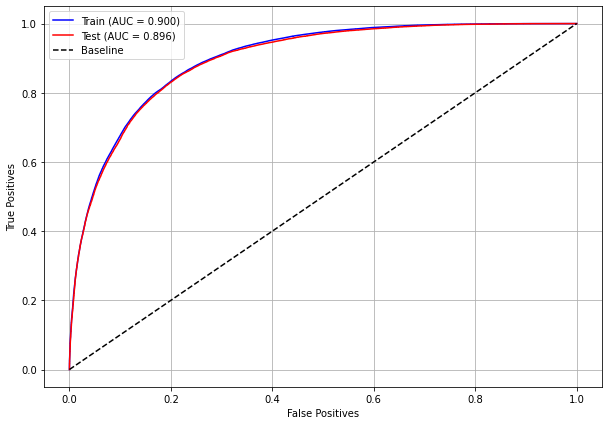

In [ ]:
plot_roc_curve(rf_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

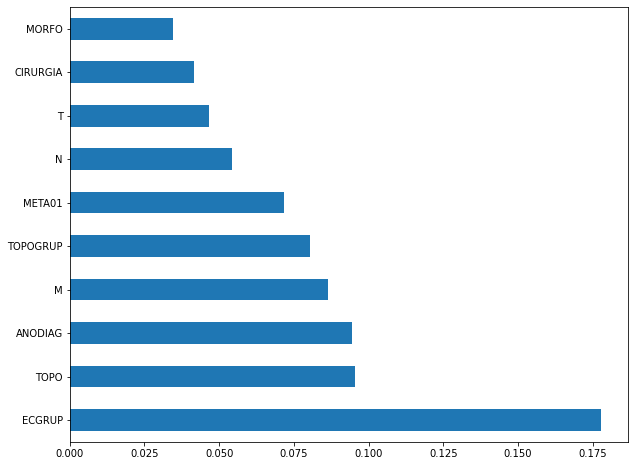

In [ ]:
plot_feat_importances(rf_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `TOPO`, `ANODIAG` and `M`.

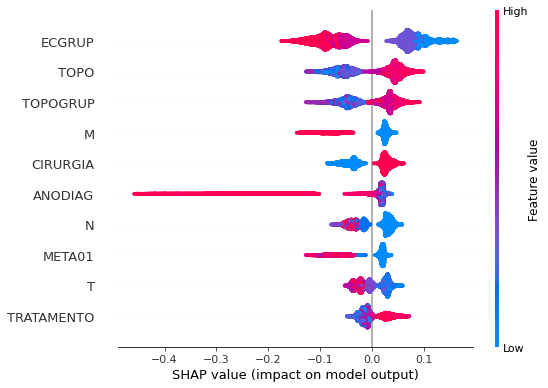

In [ ]:
plot_shap_values(rf_sp, X_test_SP, feat_cols_SP)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states
rf_fora = RandomForestClassifier(class_weight={0:1.05, 1:1}, 
                                 random_state=seed,
                                 criterion='entropy',
                                 max_depth=8)

rf_fora.fit(X_train_OS, y_train_OS)

RandomForestClassifier(class_weight={0: 1.05, 1: 1}, criterion='entropy',
                       max_depth=8, random_state=10)

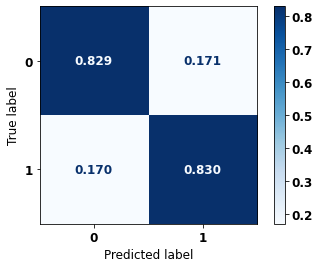


              precision    recall  f1-score   support

           0      0.851     0.829     0.840      2778
           1      0.805     0.830     0.817      2362

    accuracy                          0.829      5140
   macro avg      0.828     0.829     0.828      5140
weighted avg      0.830     0.829     0.829      5140



In [ ]:
display_confusion_matrix(rf_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the Random Forest algorithm, with other states data, shows a good performance of the model, because the model achieves a 83% of accuracy.


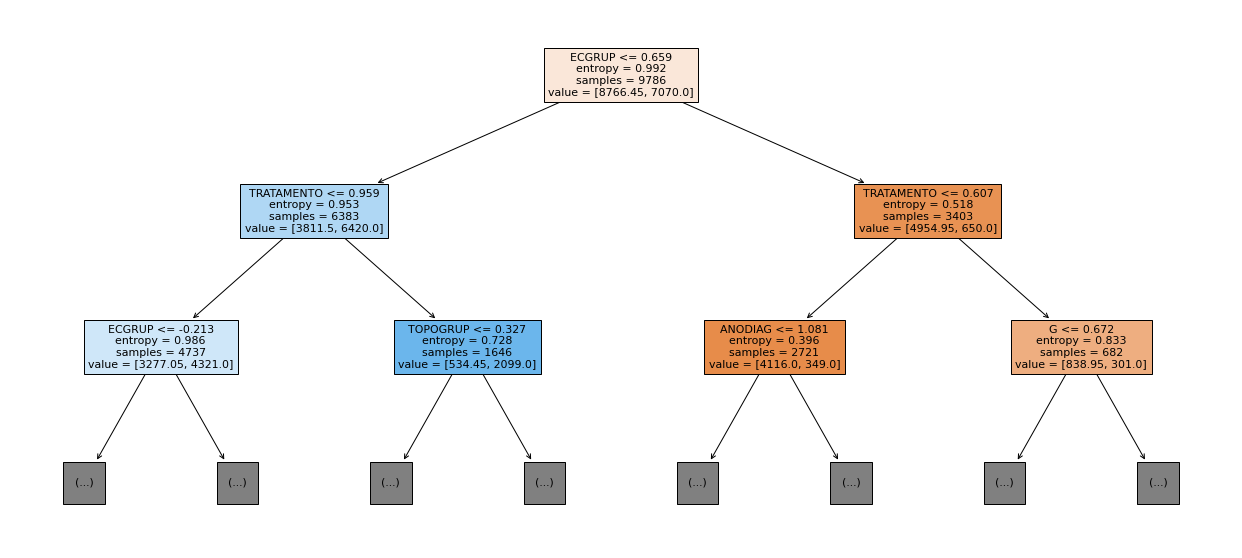

In [ ]:
show_tree(rf_fora, feat_cols_OS, 2)

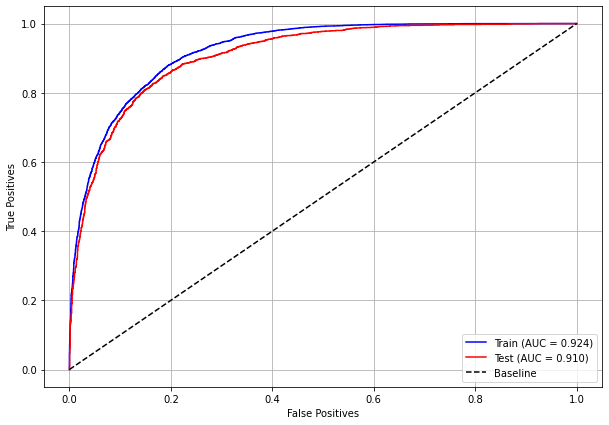

In [ ]:
plot_roc_curve(rf_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

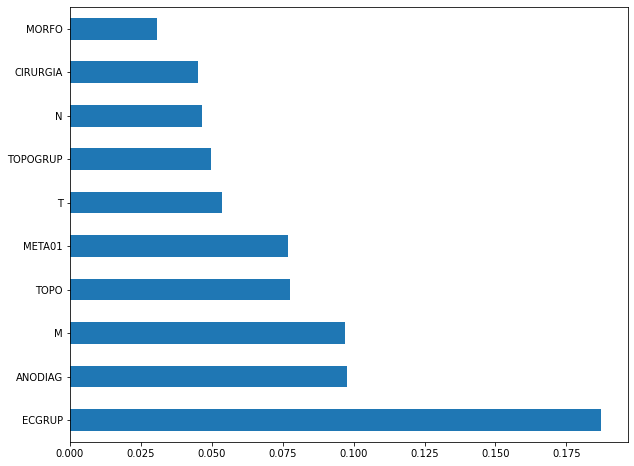

In [ ]:
plot_feat_importances(rf_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, `ANODIAG`, `M` and `TOPO`.

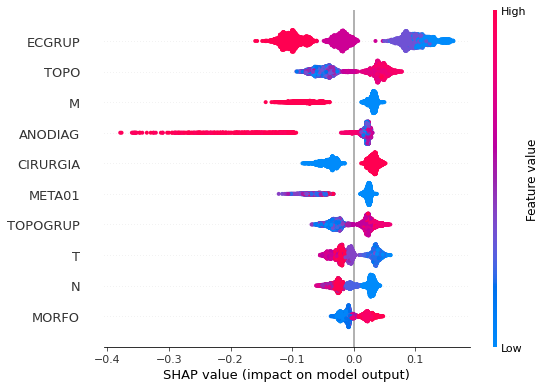

In [ ]:
plot_shap_values(rf_fora, X_test_OS, feat_cols_OS)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

### **XGBoost**


The training of the XGBoost model follows the same pattern with `random_state`. A higher weight was also used for the class with fewer examples, using the hyperparameter `scale_pos_weight`.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

In [ ]:
# SP
xgboost_sp = XGBClassifier(max_depth=10, 
                           scale_pos_weight=1.1,
                           random_state=seed)

xgboost_sp.fit(X_train_SP, y_train_SP)

XGBClassifier(max_depth=10, random_state=10, scale_pos_weight=1.1)

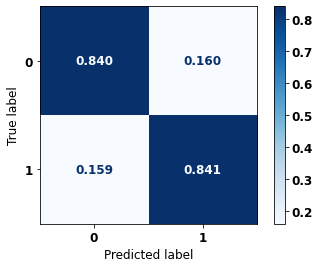


              precision    recall  f1-score   support

           0      0.867     0.840     0.853     48187
           1      0.810     0.841     0.825     38983

    accuracy                          0.840     87170
   macro avg      0.838     0.840     0.839     87170
weighted avg      0.841     0.840     0.841     87170



In [ ]:
display_confusion_matrix(xgboost_sp, X_test_SP, y_test_SP)

> The confusion matrix obtained for the XGBoost, with SP data, shows a good performance of the model, with 84% of accuracy.


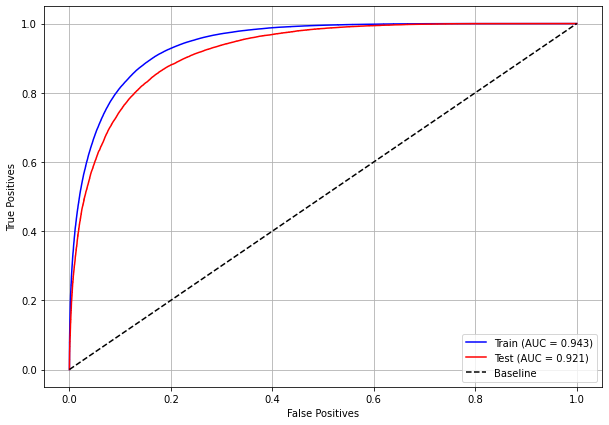

In [ ]:
plot_roc_curve(xgboost_sp, X_train_SP, X_test_SP, y_train_SP, y_test_SP)

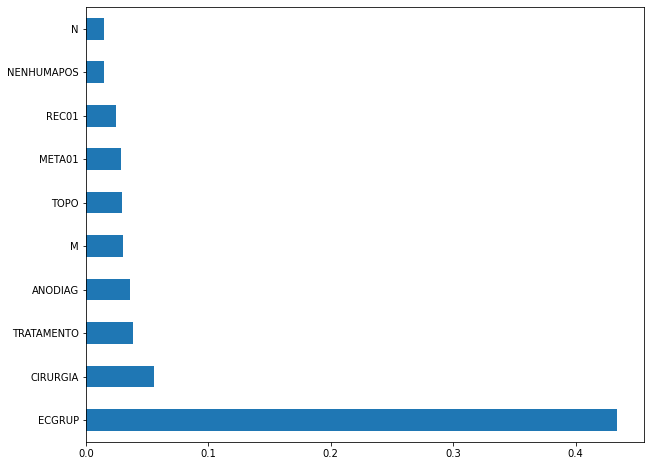

In [ ]:
plot_feat_importances(xgboost_sp, feat_cols_SP)

> The four most important features in the model were `ECGRUP`, `CIRURGIA`, `TRATAMENTO` and `ANODIAG`.

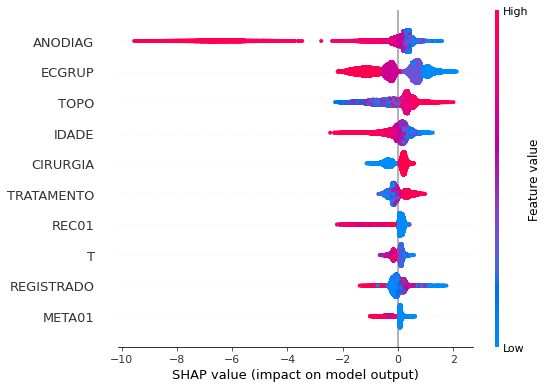

In [ ]:
plot_shap_values(xgboost_sp, X_test_SP, feat_cols_SP)

Note that larger values of the `ANODIAG` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1.  

The other columns shown follow the same logic.

In [ ]:
# Other states 
xgboost_fora = XGBClassifier(max_depth=8, 
                             scale_pos_weight=1.05,
                             random_state=seed)

xgboost_fora.fit(X_train_OS, y_train_OS)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=1.05)

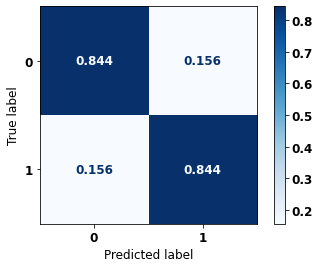


              precision    recall  f1-score   support

           0      0.864     0.844     0.854      2778
           1      0.822     0.844     0.833      2362

    accuracy                          0.844      5140
   macro avg      0.843     0.844     0.843      5140
weighted avg      0.845     0.844     0.844      5140



In [ ]:
display_confusion_matrix(xgboost_fora, X_test_OS, y_test_OS)

> The confusion matrix obtained for the XGBoost algorithm, with other states data, shows a good performance of the model, because the model achieves a 84% of accuracy.


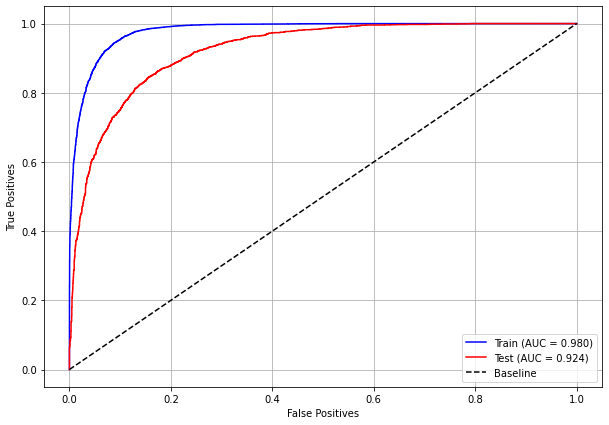

In [ ]:
plot_roc_curve(xgboost_fora, X_train_OS, X_test_OS, y_train_OS, y_test_OS)

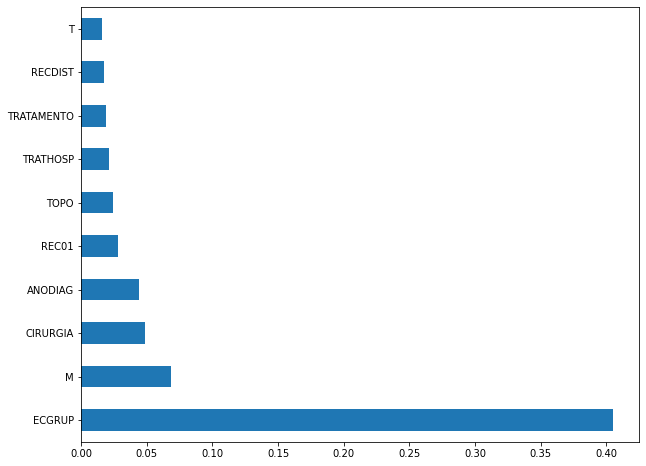

In [ ]:
plot_feat_importances(xgboost_fora, feat_cols_OS)

> The four most important features in the model were `ECGRUP`, `M`, `CIRURGIA` and `ANODIAG`.

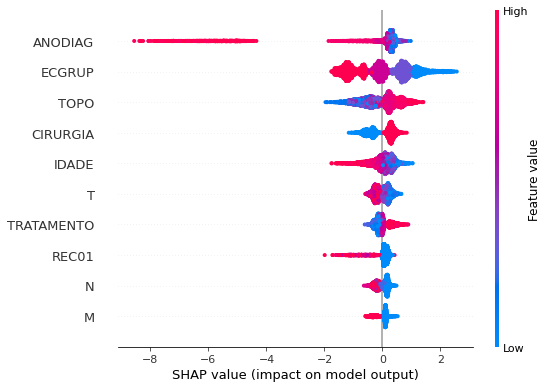

In [ ]:
plot_shap_values(xgboost_fora, X_test_OS, feat_cols_OS)

Note that larger values of the `ANODIAG` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. 

The other columns shown follow the same logic.

# **Fourth approach**

Approach with grouped years and without the column `EC`.

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation. We will use the years grouped too, resulting in 5 datasets for SP and more 5 for other states.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the datasets: `UFRESID`, because we already have the division between SP and other states in the two datasets.

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'obito_geral', 'obito_cancer', 'vivo_ano1', 'vivo_ano3', 'ULTINFO', 
             'EC']

# 'RECNENHUM', 'RECLOCAL', 'RECREGIO', 'REC01', 'REC02', 'REC03', 'RECDIST'

lb = 'vivo_ano5'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

The process will be done 5 times for SP and other states, using the datasets with grouped years.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

### **SP**

In [ ]:
X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03, feat_SP_00_03 = preprocessing(df_SP_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2000, 
                                                                                                last_year=2003, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (44789, 65), X_test = (14930, 65)
y_train = (44789,), y_test = (14930,)


In [ ]:
X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07, feat_SP_04_07 = preprocessing(df_SP_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2004, 
                                                                                                last_year=2007,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')                                                            

X_train = (55804, 65), X_test = (18602, 65)
y_train = (55804,), y_test = (18602,)


In [ ]:
X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11, feat_SP_08_11 = preprocessing(df_SP_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2008, 
                                                                                                last_year=2011, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (73620, 65), X_test = (24541, 65)
y_train = (73620,), y_test = (24541,)


In [ ]:
X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15, feat_SP_12_15 = preprocessing(df_SP_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2012, 
                                                                                                last_year=2015, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (65896, 65), X_test = (21966, 65)
y_train = (65896,), y_test = (21966,)


### **Other states**

In [ ]:
X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03, feat_OS_00_03 = preprocessing(df_fora_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2000, 
                                                                                                last_year=2003, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (2588, 65), X_test = (863, 65)
y_train = (2588,), y_test = (863,)


In [ ]:
X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07, feat_OS_04_07 = preprocessing(df_fora_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2004, 
                                                                                                last_year=2007, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (3396, 65), X_test = (1133, 65)
y_train = (3396,), y_test = (1133,)


In [ ]:
X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11, feat_OS_08_11 = preprocessing(df_fora_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2008, 
                                                                                                last_year=2011, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (3926, 65), X_test = (1309, 65)
y_train = (3926,), y_test = (1309,)


In [ ]:
X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15, feat_OS_12_15 = preprocessing(df_fora_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2012, 
                                                                                                last_year=2015, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (3814, 65), X_test = (1272, 65)
y_train = (3814,), y_test = (1272,)


## **Training and evaluation of the models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model is the Random Forest, the `random_state` will be used as a parameter, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was used because the models have difficulty to learn the class with fewer examples.

**SP**

In [ ]:
# SP - 2000 to 2003
rf_sp_00_03 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1.015},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

RandomForestClassifier(class_weight={0: 1, 1: 1.015}, criterion='entropy',
                       max_depth=10, random_state=10)

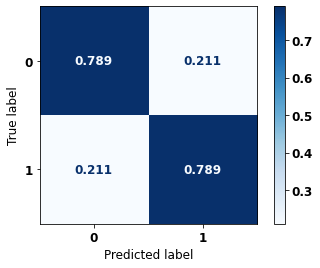


              precision    recall  f1-score   support

           0      0.803     0.789     0.796      7787
           1      0.774     0.789     0.782      7143

    accuracy                          0.789     14930
   macro avg      0.789     0.789     0.789     14930
weighted avg      0.789     0.789     0.789     14930



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the Random Forest, with SP data from 2000 to 2003, shows a good performance of the model, with 79% of accuracy.


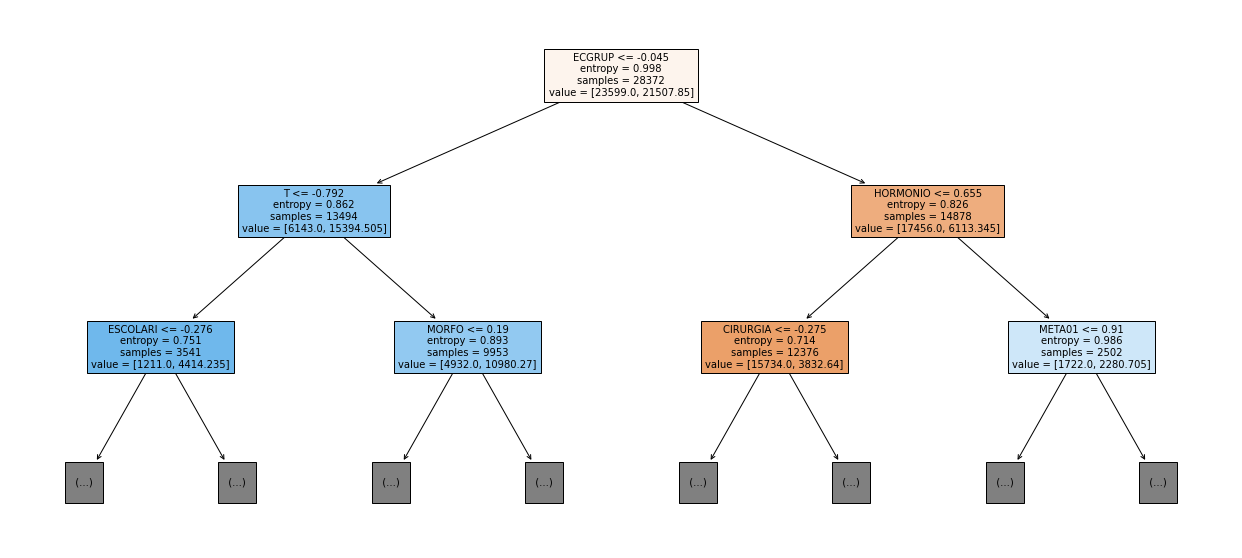

In [ ]:
show_tree(rf_sp_00_03, feat_SP_00_03, 2)

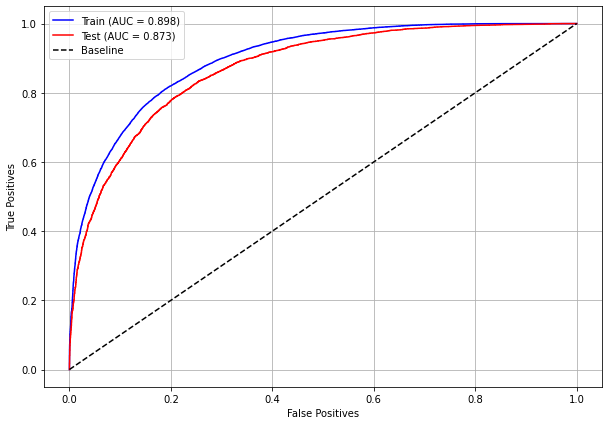

In [ ]:
plot_roc_curve(rf_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

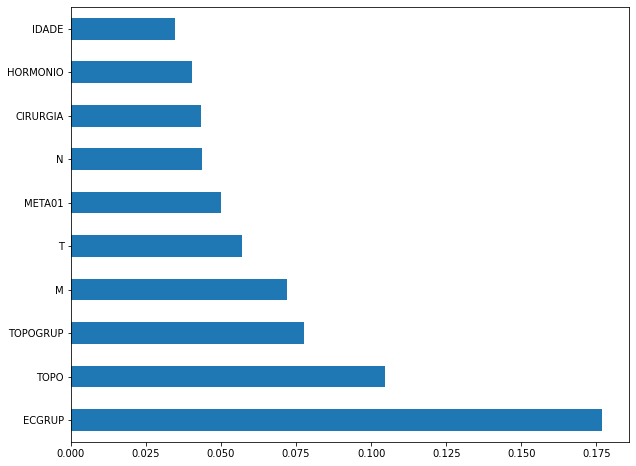

In [ ]:
plot_feat_importances(rf_sp_00_03, feat_SP_00_03)

> The four most important features in the model were `ECGRUP`, `TOPO`, `TOPOGRUP`, and `M`. 

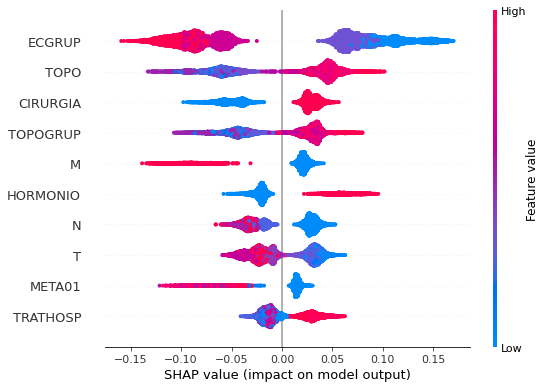

In [ ]:
plot_shap_values(rf_sp_00_03, X_testSP_00_03, feat_SP_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2004 to 2007
rf_sp_04_07 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1.142, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

RandomForestClassifier(class_weight={0: 1.142, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

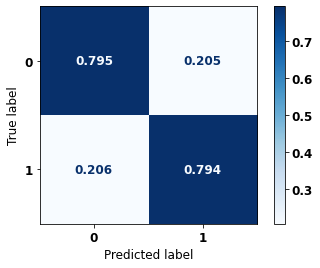


              precision    recall  f1-score   support

           0      0.788     0.795     0.791      9125
           1      0.801     0.794     0.797      9477

    accuracy                          0.794     18602
   macro avg      0.794     0.794     0.794     18602
weighted avg      0.794     0.794     0.794     18602



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the Random Forest, with SP data from 2004 to 2007, shows a good performance of the model, with 79% of accuracy.

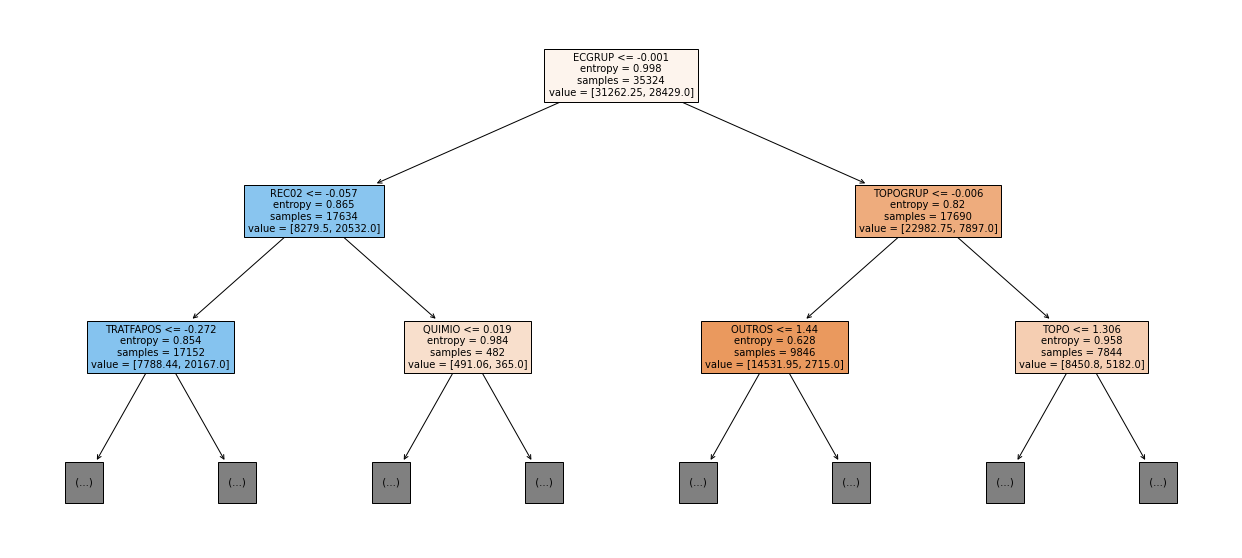

In [ ]:
show_tree(rf_sp_04_07, feat_SP_04_07, 2)

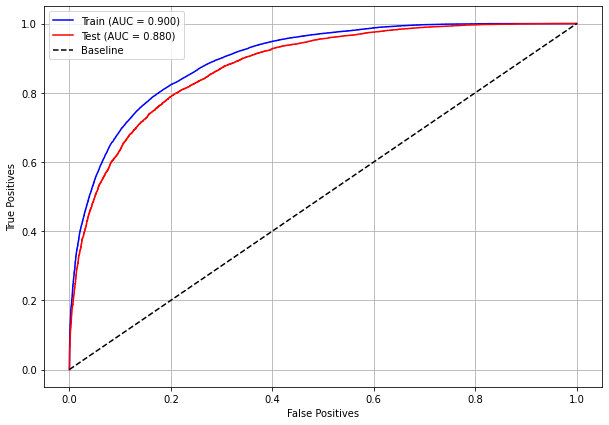

In [ ]:
plot_roc_curve(rf_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

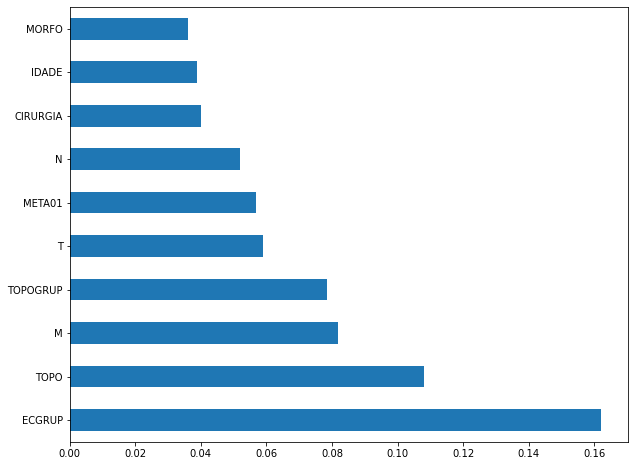

In [ ]:
plot_feat_importances(rf_sp_04_07, feat_SP_04_07)

> The four most important features in the model were `ECGRUP`, `TOPO`, `M` and `TOPOGRUP`.

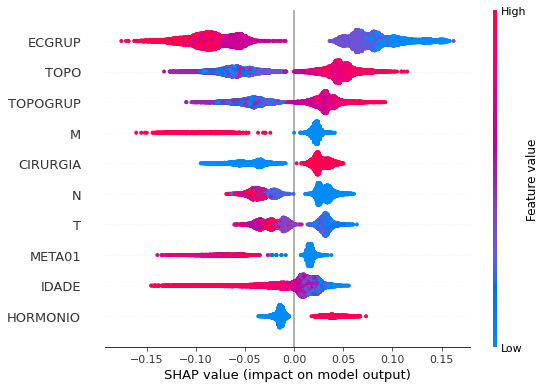

In [ ]:
plot_shap_values(rf_sp_04_07, X_testSP_04_07, feat_SP_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2008 to 2011
rf_sp_08_11 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1.25, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

RandomForestClassifier(class_weight={0: 1.25, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

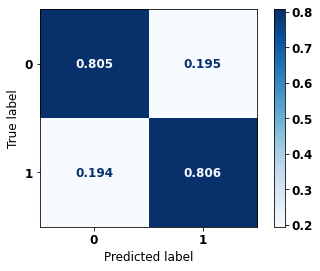


              precision    recall  f1-score   support

           0      0.790     0.805     0.797     11680
           1      0.820     0.806     0.813     12861

    accuracy                          0.805     24541
   macro avg      0.805     0.805     0.805     24541
weighted avg      0.806     0.805     0.806     24541



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the Random Forest, with SP data from 2008 to 2011, shows a good performance of the model, with 80% of accuracy.

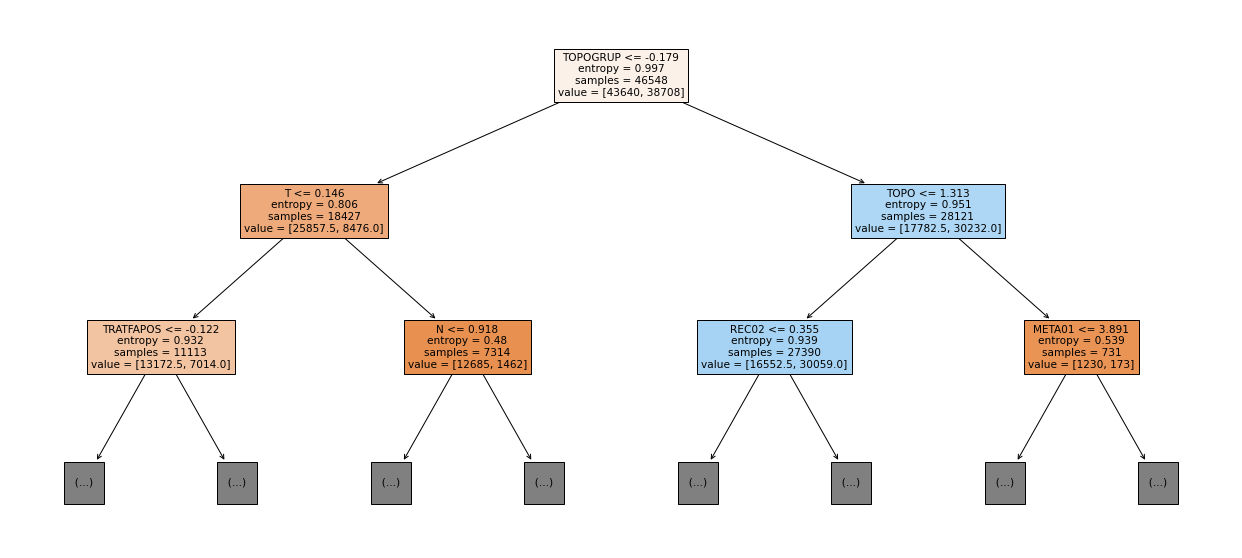

In [ ]:
show_tree(rf_sp_08_11, feat_SP_08_11, 2)

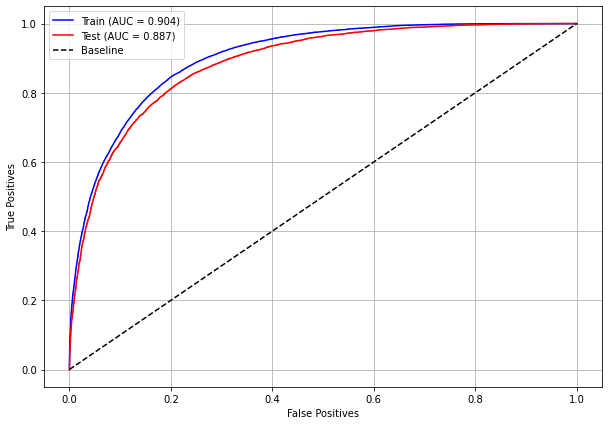

In [ ]:
plot_roc_curve(rf_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

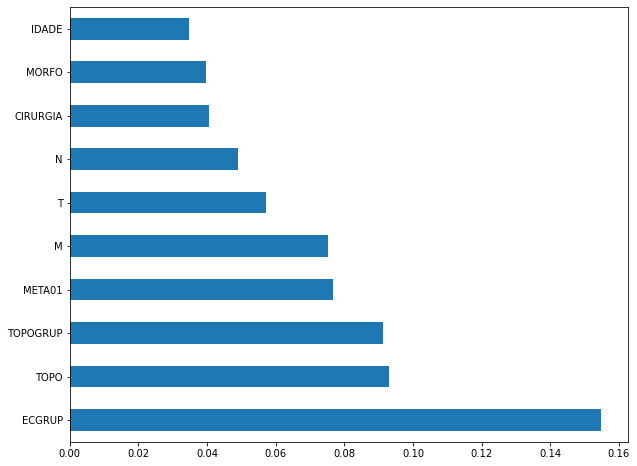

In [ ]:
plot_feat_importances(rf_sp_08_11, feat_SP_08_11)

> The four most important features in the model were `ECGRUP`, `TOPO`, `TOPOGRUP` and `META01`.

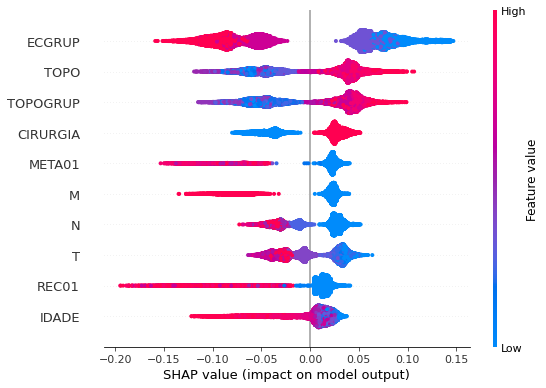

In [ ]:
plot_shap_values(rf_sp_08_11, X_testSP_08_11, feat_SP_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2012 to 2015
rf_sp_12_15 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1.14},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

RandomForestClassifier(class_weight={0: 1, 1: 1.14}, criterion='entropy',
                       max_depth=10, random_state=10)

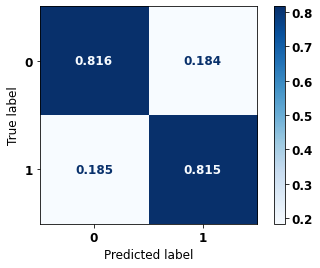


              precision    recall  f1-score   support

           0      0.853     0.816     0.834     12466
           1      0.772     0.815     0.793      9500

    accuracy                          0.816     21966
   macro avg      0.812     0.816     0.813     21966
weighted avg      0.818     0.816     0.816     21966



In [ ]:
display_confusion_matrix(rf_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the Random Forest, with SP data from 2012 to 2015, shows a good performance of the model with 82% of accuracy.

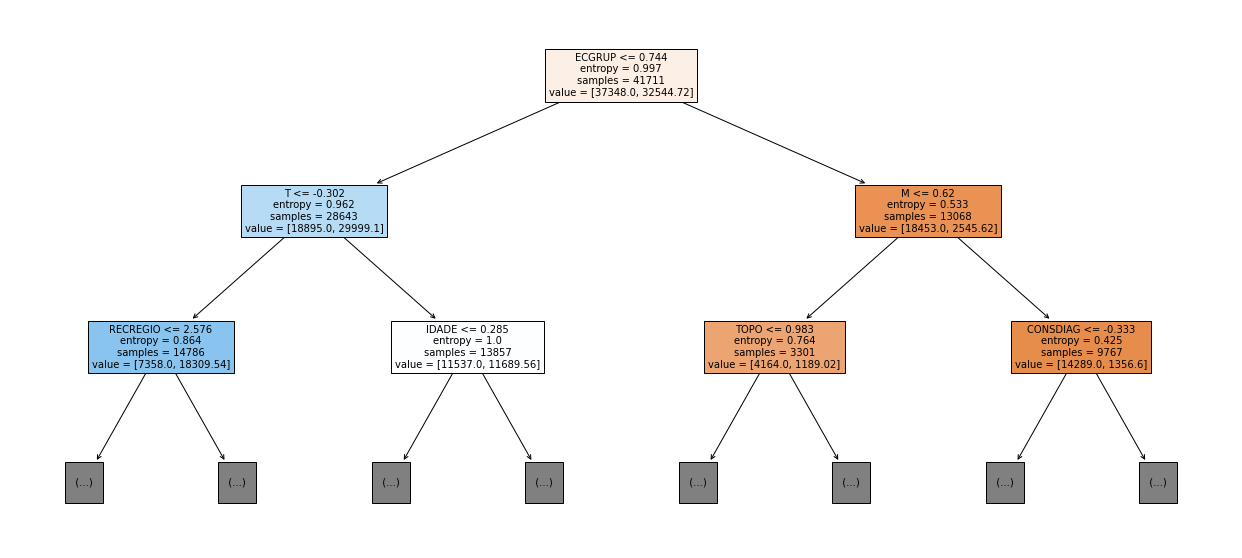

In [ ]:
show_tree(rf_sp_12_15, feat_SP_12_15, 2)

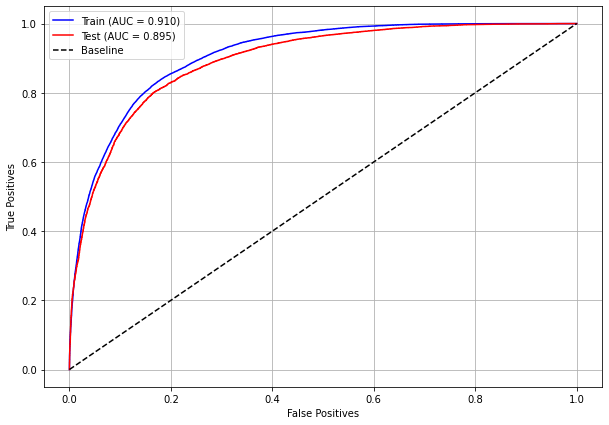

In [ ]:
plot_roc_curve(rf_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

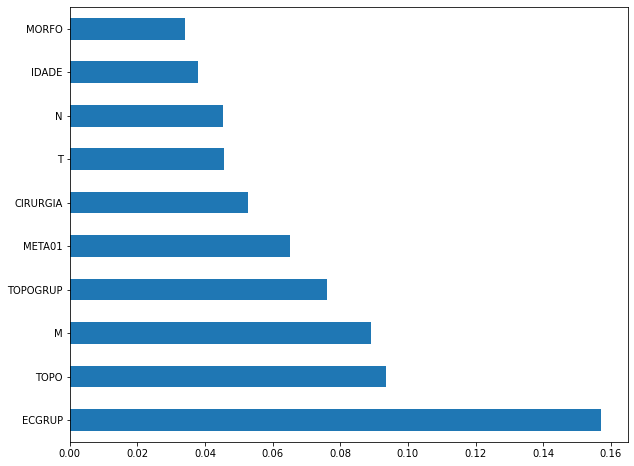

In [ ]:
plot_feat_importances(rf_sp_12_15, feat_SP_12_15)

> The four most important features in the model were `ECGRUP`, `TOPO`, `M` and `TOPOGRUP`.

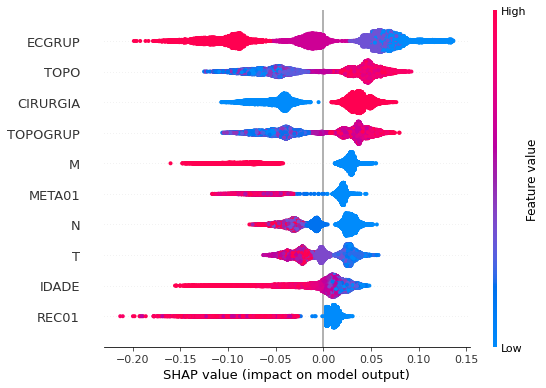

In [ ]:
plot_shap_values(rf_sp_12_15, X_testSP_12_15, feat_SP_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

**Other states**

In [ ]:
# Other states - 2000 to 2003
rf_fora_00_03 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1.313, 1:1},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

RandomForestClassifier(class_weight={0: 1.313, 1: 1}, criterion='entropy',
                       max_depth=8, random_state=10)

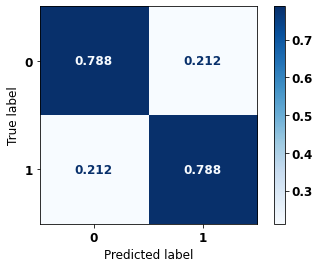


              precision    recall  f1-score   support

           0      0.778     0.788     0.783       419
           1      0.797     0.788     0.793       444

    accuracy                          0.788       863
   macro avg      0.788     0.788     0.788       863
weighted avg      0.788     0.788     0.788       863



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the Random Forest, with other states data from 2000 to 2003, also shows a good performance of the model, and we have a balanced main diagonal with 79% of accuracy.

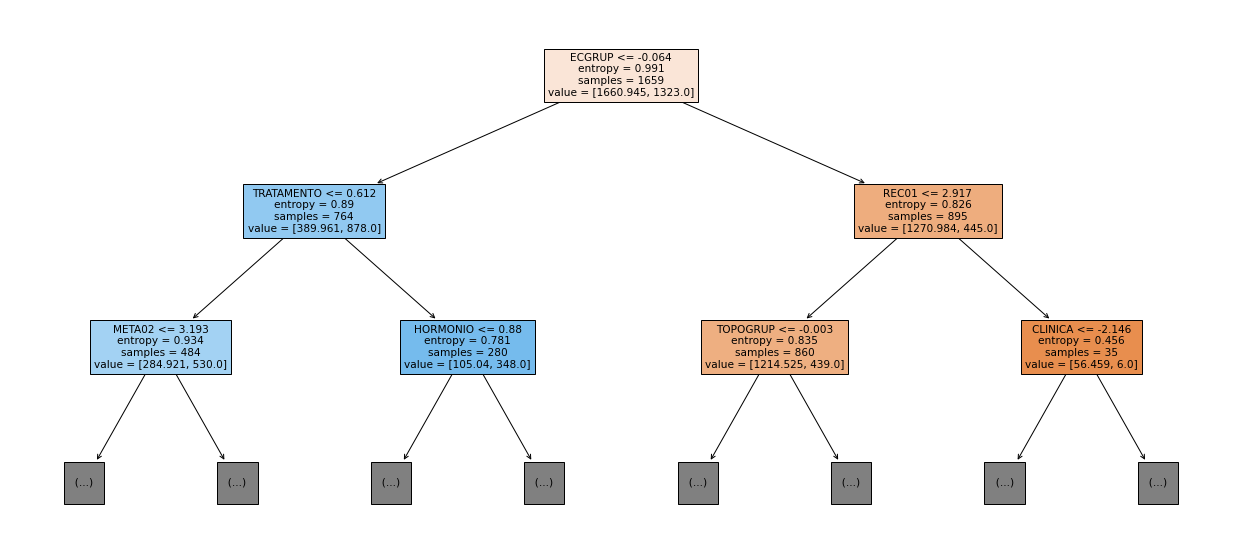

In [ ]:
show_tree(rf_fora_00_03, feat_OS_00_03, 2)

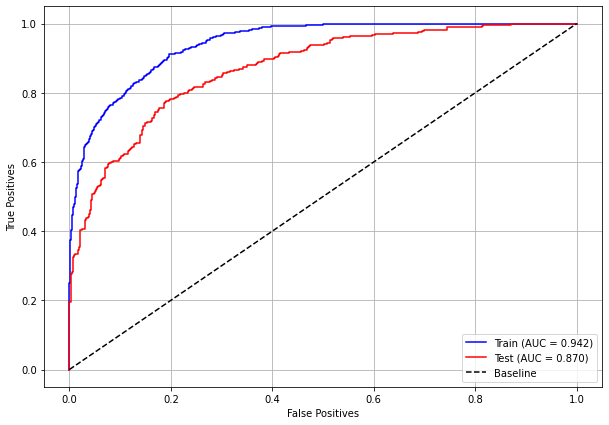

In [ ]:
plot_roc_curve(rf_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

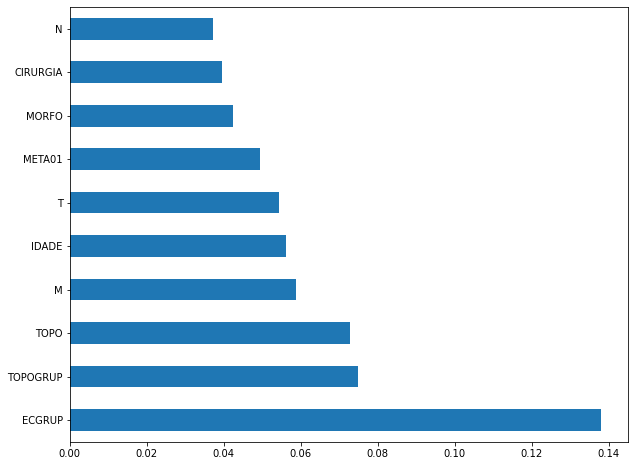

In [ ]:
plot_feat_importances(rf_fora_00_03, feat_OS_00_03)

> The four most important features in the model were `ECGRUP`, `TOPOGRUP`, `TOPO` and `M`.

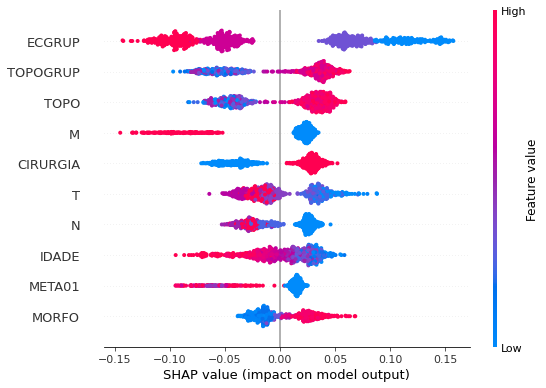

In [ ]:
plot_shap_values(rf_fora_00_03, X_testOS_00_03, feat_OS_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2004 to 2007
rf_fora_04_07 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1.448, 1:1},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

RandomForestClassifier(class_weight={0: 1.448, 1: 1}, criterion='entropy',
                       max_depth=8, random_state=10)

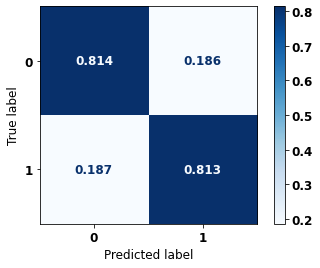


              precision    recall  f1-score   support

           0      0.792     0.814     0.803       528
           1      0.834     0.813     0.823       605

    accuracy                          0.814      1133
   macro avg      0.813     0.814     0.813      1133
weighted avg      0.814     0.814     0.814      1133



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the Random Forest, with other states data from 2004 to 2007, also shows a good performance of the model, with 81% of accuracy.


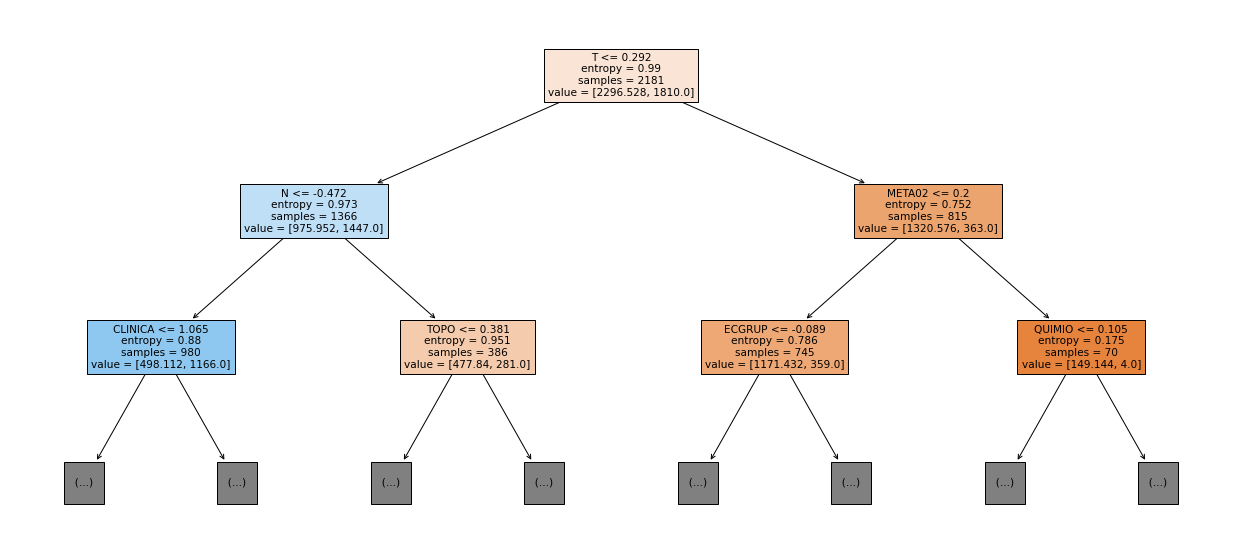

In [ ]:
show_tree(rf_fora_04_07, feat_OS_04_07, 2)

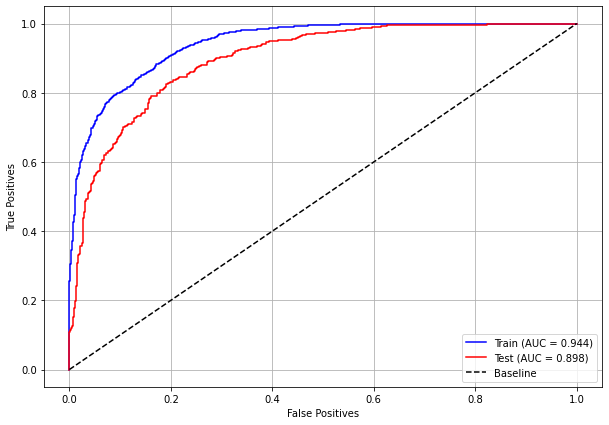

In [ ]:
plot_roc_curve(rf_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

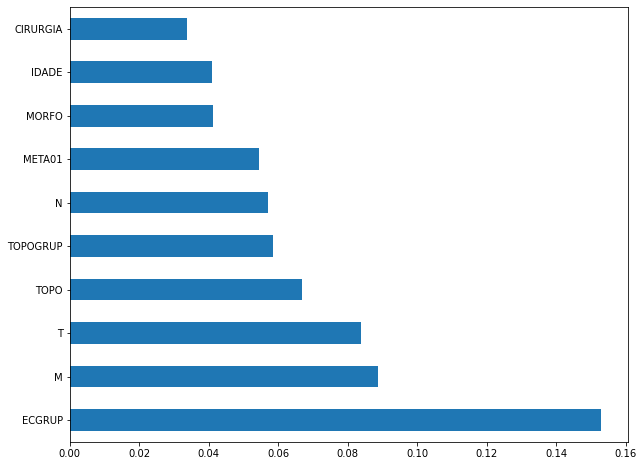

In [ ]:
plot_feat_importances(rf_fora_04_07, feat_OS_04_07)

> The four most important features in the model were `ECGRUP`, `M`, `T` and `TOPO`.

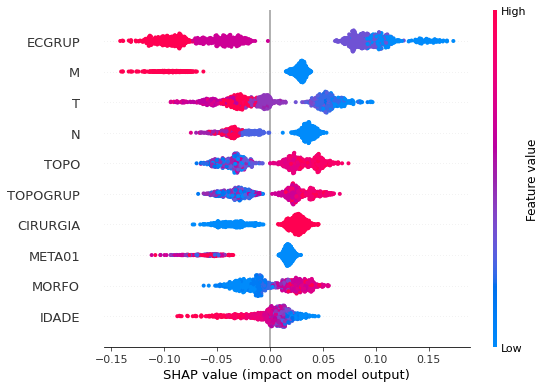

In [ ]:
plot_shap_values(rf_fora_04_07, X_testOS_04_07, feat_OS_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2008 to 2011
rf_fora_08_11 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1.497, 1:1},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

RandomForestClassifier(class_weight={0: 1.497, 1: 1}, criterion='entropy',
                       max_depth=8, random_state=10)

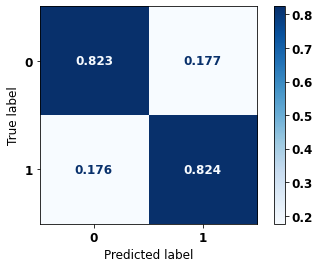


              precision    recall  f1-score   support

           0      0.800     0.823     0.811       604
           1      0.844     0.824     0.834       705

    accuracy                          0.824      1309
   macro avg      0.822     0.823     0.823      1309
weighted avg      0.824     0.824     0.824      1309



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the Random Forest, with other states data from 2008 to 2011, also shows a good performance of the model, presenting 82% of accuracy.


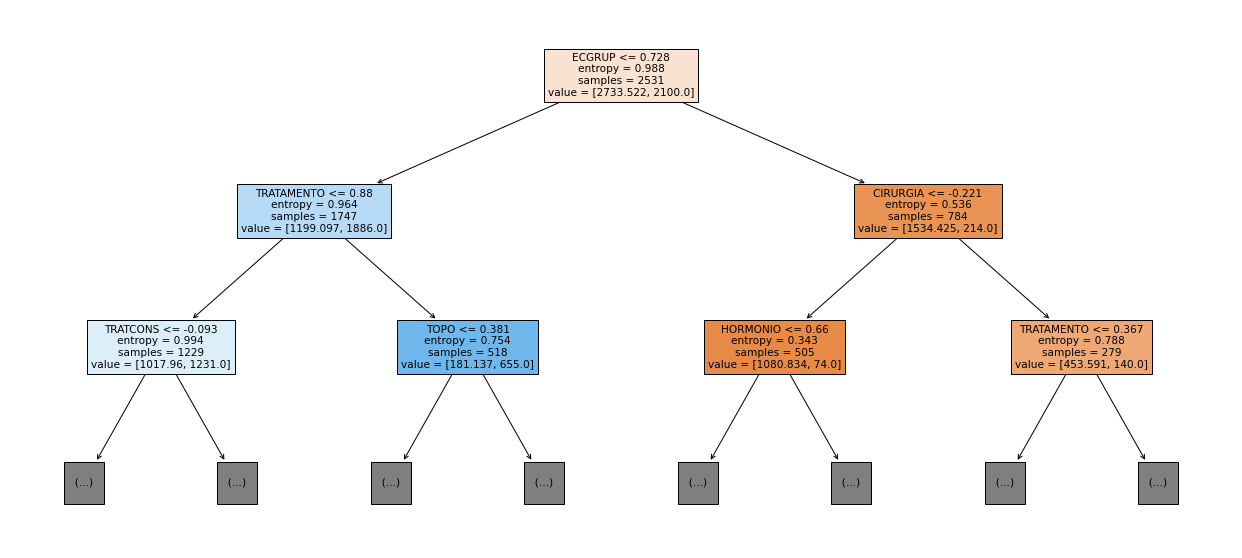

In [ ]:
show_tree(rf_fora_08_11, feat_OS_08_11, 2)

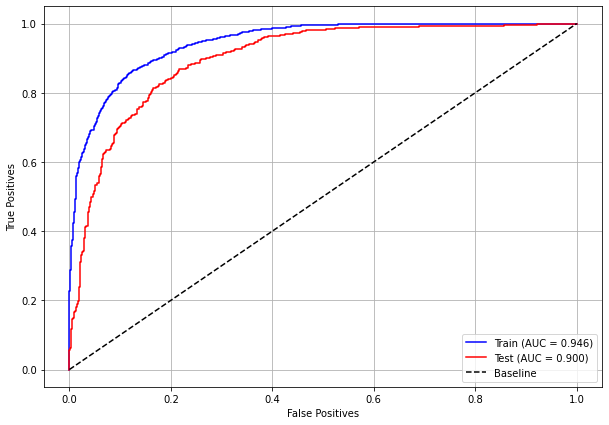

In [ ]:
plot_roc_curve(rf_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

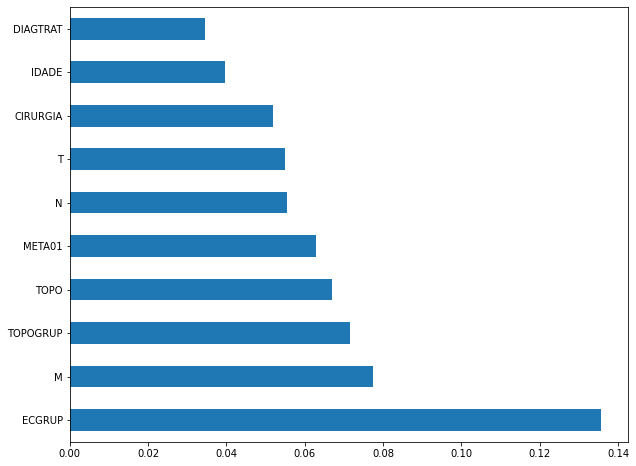

In [ ]:
plot_feat_importances(rf_fora_08_11, feat_OS_08_11)

> The four most important features in the model were `ECGRUP`, `M`, `TOPOGRUP` and `TOPO`.

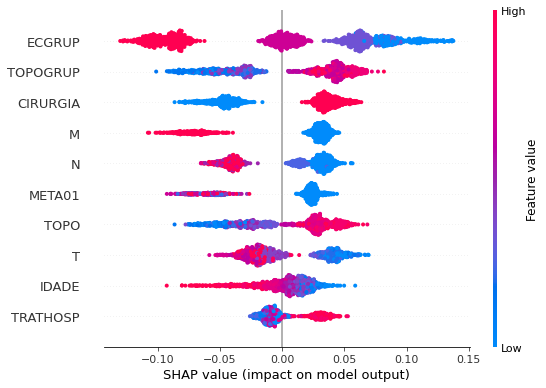

In [ ]:
plot_shap_values(rf_fora_08_11, X_testOS_08_11, feat_OS_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2012 to 2015
rf_fora_12_15 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1.16, 1:1},
                                       criterion='entropy',
                                       max_depth=8)

rf_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

RandomForestClassifier(class_weight={0: 1.16, 1: 1}, criterion='entropy',
                       max_depth=8, random_state=10)

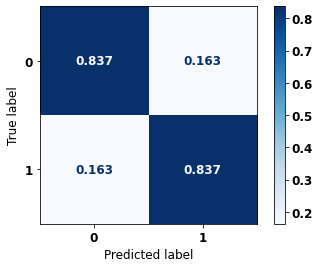


              precision    recall  f1-score   support

           0      0.849     0.837     0.843       664
           1      0.825     0.837     0.831       608

    accuracy                          0.837      1272
   macro avg      0.837     0.837     0.837      1272
weighted avg      0.837     0.837     0.837      1272



In [ ]:
display_confusion_matrix(rf_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the Random Forest, with other states data from 2012 to 2015, also shows a good performance of the model, presenting 84% of accuracy.


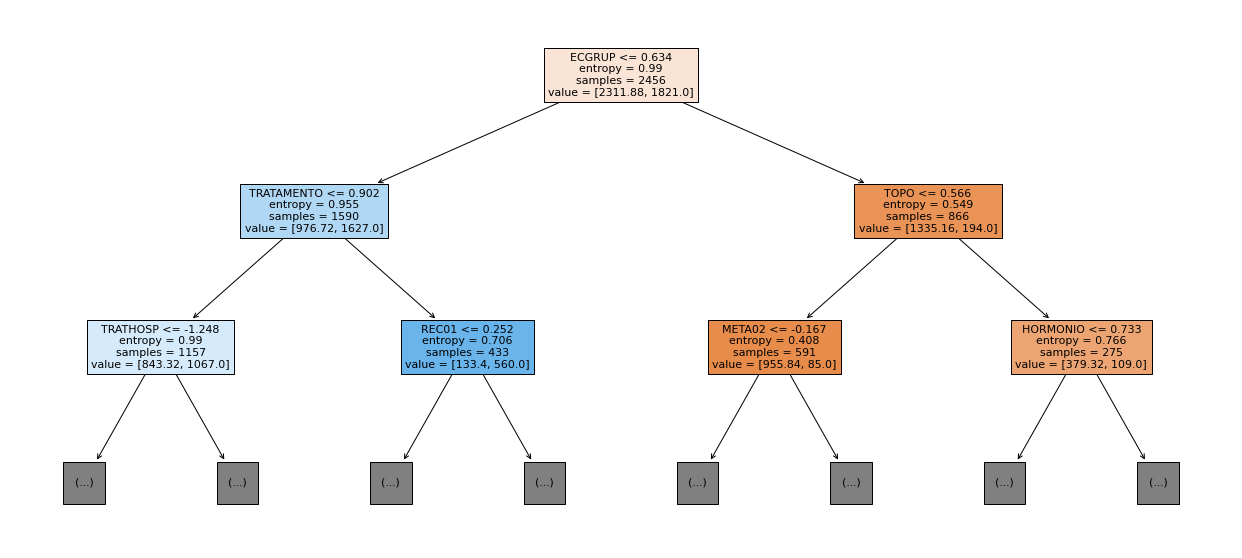

In [ ]:
show_tree(rf_fora_12_15, feat_OS_12_15, 2)

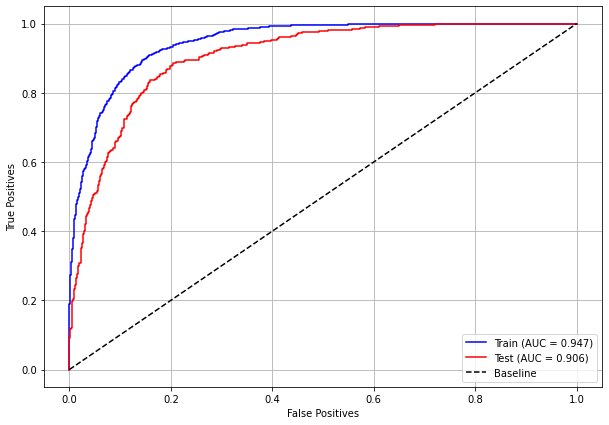

In [ ]:
plot_roc_curve(rf_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

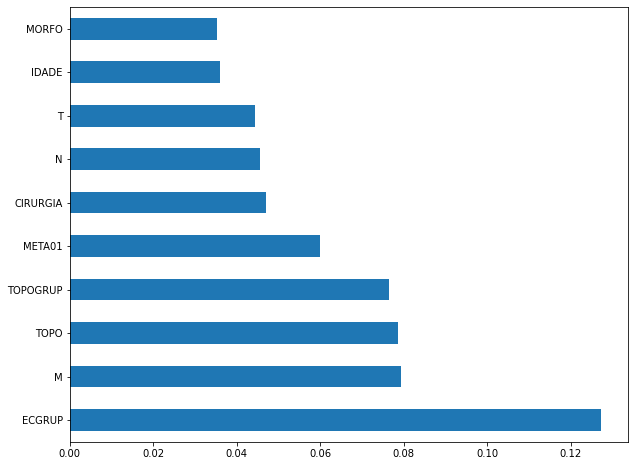

In [ ]:
plot_feat_importances(rf_fora_12_15, feat_OS_12_15)

> The four most important features in the model were `ECGRUP`, `M`, `TOPO` and `TOPOGRUP`.

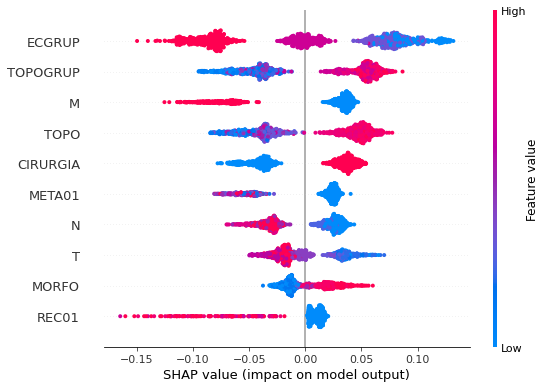

In [ ]:
plot_shap_values(rf_fora_12_15, X_testOS_12_15, feat_OS_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

### **XGBoost**


The training of the XGBoost models follows the same pattern with `random_state`. The hyperparameter `scale_pos_weight` was also used in some trainings, in order to obtain a balanced main diagonal in the confusion matrix.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

**SP**

In [ ]:
# SP - 2000 to 2003
xgb_sp_00_03 = XGBClassifier(max_depth=8, 
                             random_state=seed, 
                             scale_pos_weight=1.12)

xgb_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=1.12)

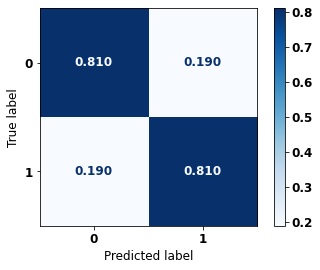


              precision    recall  f1-score   support

           0      0.823     0.810     0.816      7787
           1      0.796     0.810     0.803      7143

    accuracy                          0.810     14930
   macro avg      0.810     0.810     0.810     14930
weighted avg      0.810     0.810     0.810     14930



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the XGBoost, with SP data from 2000 to 2003, shows a good performance of the model, here with 81% of accuracy.

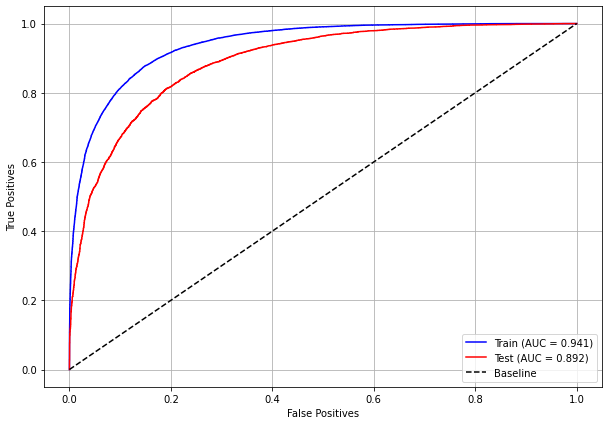

In [ ]:
plot_roc_curve(xgb_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

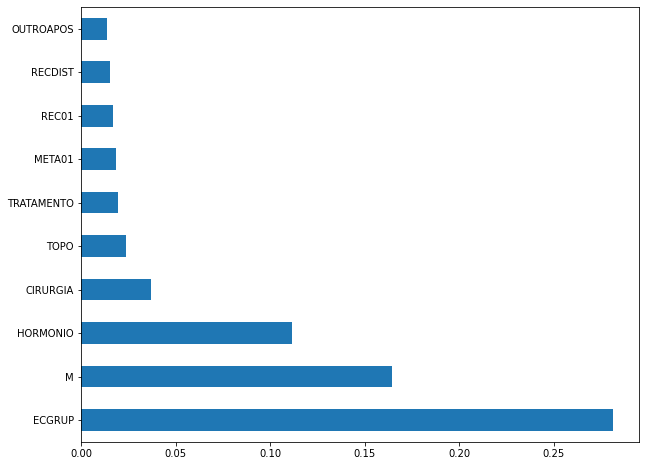

In [ ]:
plot_feat_importances(xgb_sp_00_03, feat_SP_00_03)

> Here we noticed that the most used feature was `ECGRUP`, with some advantage over the others. Following we have `M`, `HORMONIO` and `CIRURGIA`.

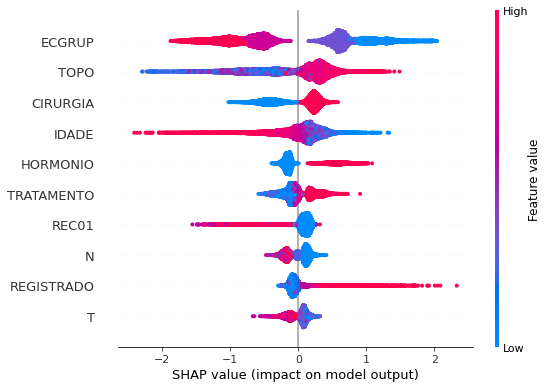

In [ ]:
plot_shap_values(xgb_sp_00_03, X_testSP_00_03, feat_SP_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2004 to 2007
xgb_sp_04_07 = XGBClassifier(max_depth=8, 
                             random_state=seed, 
                             scale_pos_weight=0.97)

xgb_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=0.97)

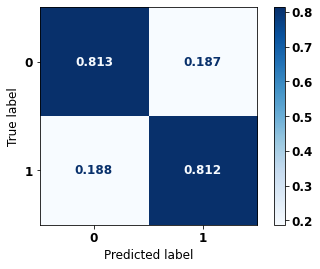


              precision    recall  f1-score   support

           0      0.806     0.813     0.809      9125
           1      0.818     0.812     0.815      9477

    accuracy                          0.812     18602
   macro avg      0.812     0.812     0.812     18602
weighted avg      0.812     0.812     0.812     18602



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the XGBoost, with SP data from 2004 to 2007, shows a good performance of the model, with 81% of accuracy.


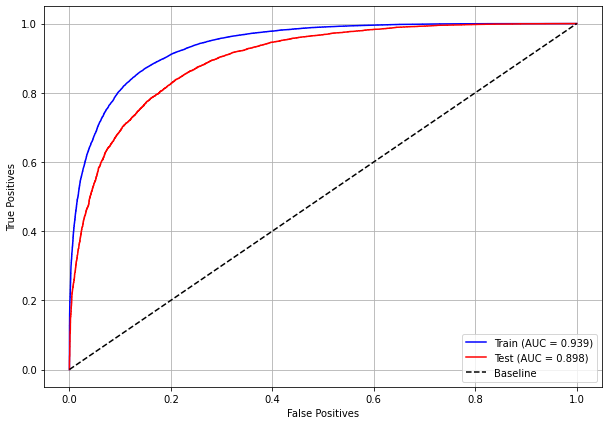

In [ ]:
plot_roc_curve(xgb_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

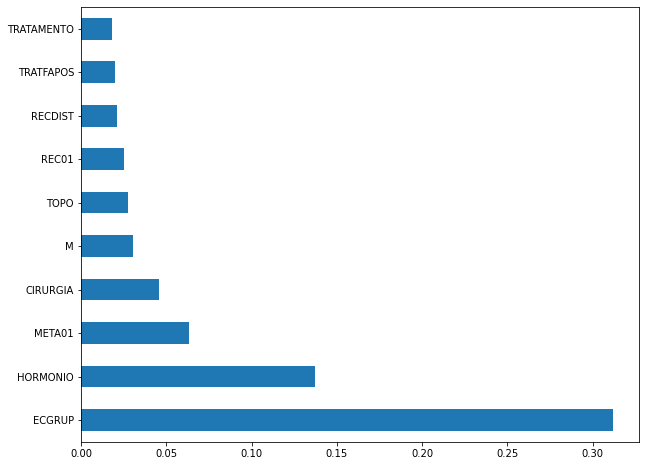

In [ ]:
plot_feat_importances(xgb_sp_04_07, feat_SP_04_07)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `HORMONIO`, `META01` and `CIRURGIA`. 

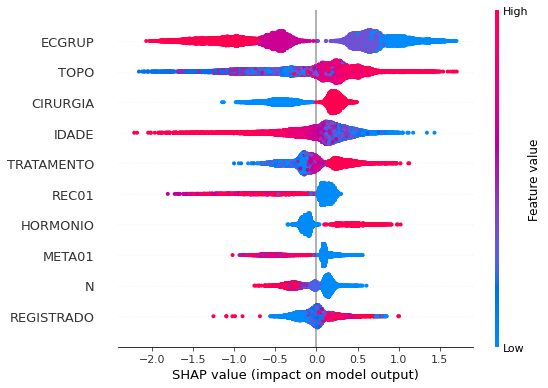

In [ ]:
plot_shap_values(xgb_sp_04_07, X_testSP_04_07, feat_SP_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2008 to 2011
xgb_sp_08_11 = XGBClassifier(max_depth=8, 
                             scale_pos_weight=0.82,
                             random_state=seed)

xgb_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=0.82)

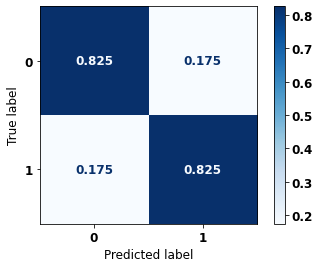


              precision    recall  f1-score   support

           0      0.810     0.825     0.818     11680
           1      0.839     0.825     0.832     12861

    accuracy                          0.825     24541
   macro avg      0.825     0.825     0.825     24541
weighted avg      0.825     0.825     0.825     24541



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the XGBoost, with SP data from 2008 to 2011, shows a good performance of the model, with 82% of accuracy.

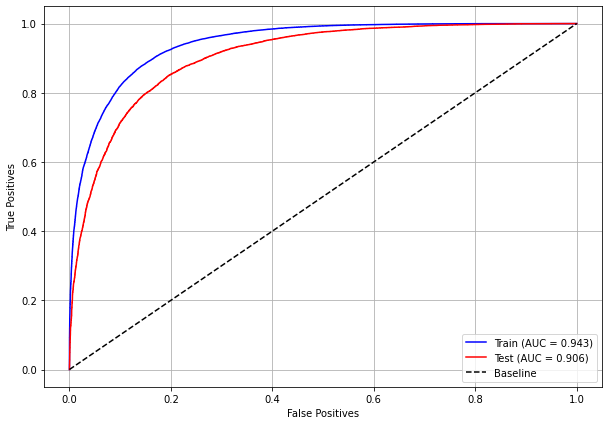

In [ ]:
plot_roc_curve(xgb_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

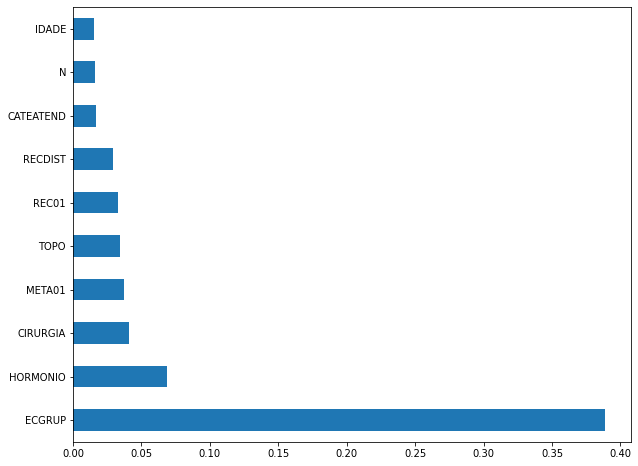

In [ ]:
plot_feat_importances(xgb_sp_08_11, feat_SP_08_11)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `HORMONIO`, `CIRURGIA` and `META01`. 

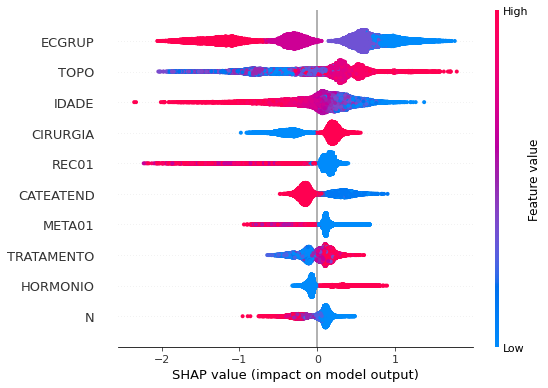

In [ ]:
plot_shap_values(xgb_sp_08_11, X_testSP_08_11, feat_SP_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2012 to 2015
xgb_sp_12_15 = XGBClassifier(max_depth=8, 
                             random_state=seed,
                             scale_pos_weight=1.26)

xgb_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=1.26)

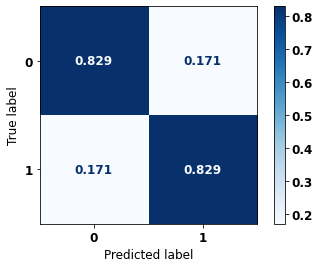


              precision    recall  f1-score   support

           0      0.864     0.829     0.846     12466
           1      0.787     0.829     0.807      9500

    accuracy                          0.829     21966
   macro avg      0.825     0.829     0.827     21966
weighted avg      0.831     0.829     0.829     21966



In [ ]:
display_confusion_matrix(xgb_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the XGBoost, with SP data from 2012 to 2015, shows a good performance of the model, with 83% of accuracy.

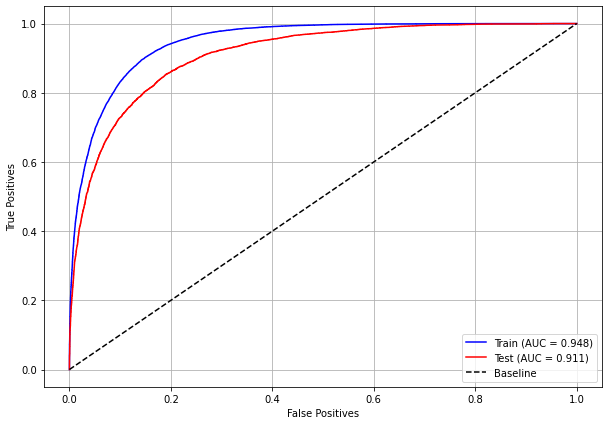

In [ ]:
plot_roc_curve(xgb_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

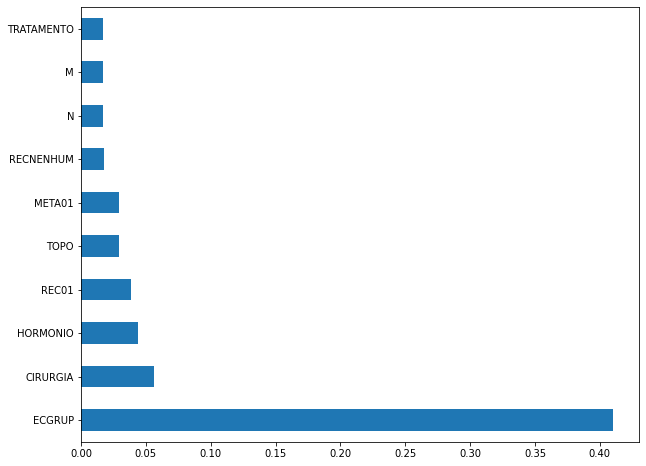

In [ ]:
plot_feat_importances(xgb_sp_12_15, feat_SP_12_15)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage. Following we have `CIRURGIA`, `HORMONIO` and `REC01`. 

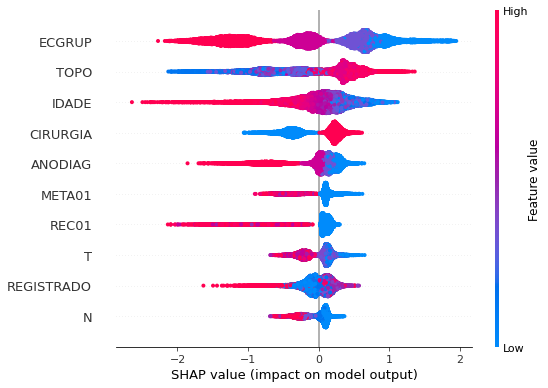

In [ ]:
plot_shap_values(xgb_sp_12_15, X_testSP_12_15, feat_SP_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

**Other states**

In [ ]:
# Other states - 2000 to 2003
xgb_fora_00_03 = XGBClassifier(max_depth=5, 
                               scale_pos_weight=0.91,
                               random_state=seed)

xgb_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=0.91)

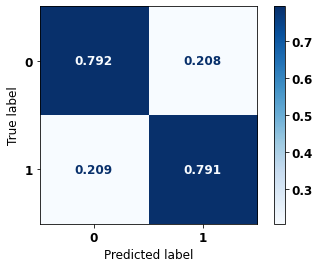


              precision    recall  f1-score   support

           0      0.781     0.792     0.787       419
           1      0.801     0.791     0.796       444

    accuracy                          0.791       863
   macro avg      0.791     0.791     0.791       863
weighted avg      0.792     0.791     0.791       863



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the XGBoost, with other states data from 2000 to 2003, also shows a good performance of the model, with 79% of accuracy.

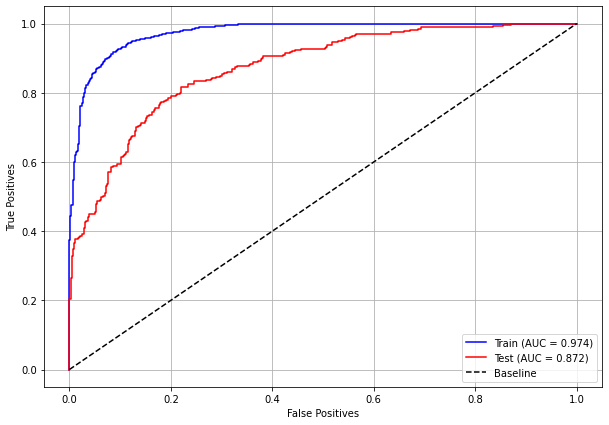

In [ ]:
plot_roc_curve(xgb_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

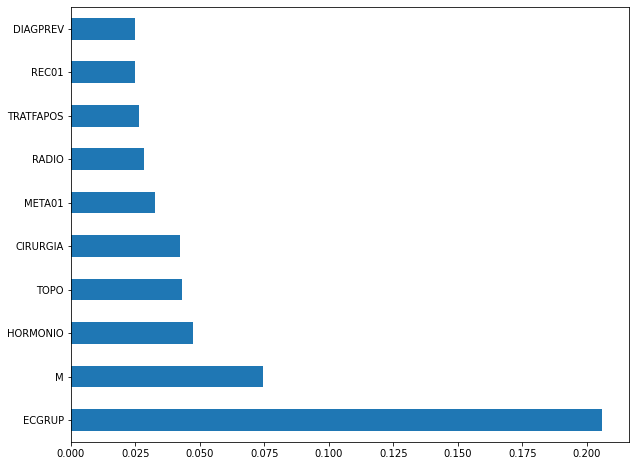

In [ ]:
plot_feat_importances(xgb_fora_00_03, feat_OS_00_03)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `M`, `HORMONIO` and `TOPO`.

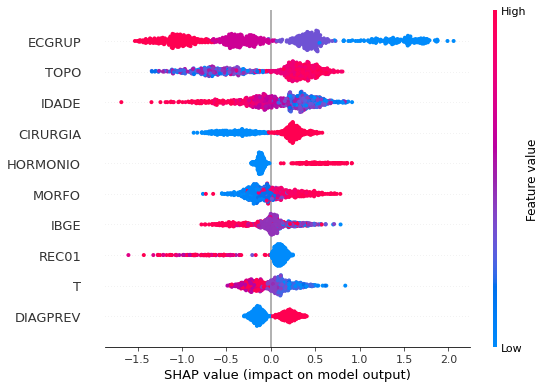

In [ ]:
plot_shap_values(xgb_fora_00_03, X_testOS_00_03, feat_OS_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2004 to 2007
xgb_fora_04_07 = XGBClassifier(max_depth=5, 
                               scale_pos_weight=0.81,
                               random_state=seed)

xgb_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=0.81)

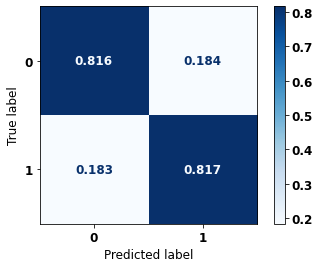


              precision    recall  f1-score   support

           0      0.795     0.816     0.806       528
           1      0.836     0.817     0.826       605

    accuracy                          0.816      1133
   macro avg      0.816     0.816     0.816      1133
weighted avg      0.817     0.816     0.817      1133



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the XGBoost, with other states data from 2004 to 2007, also shows a good performance of the model with 82% of accuracy.

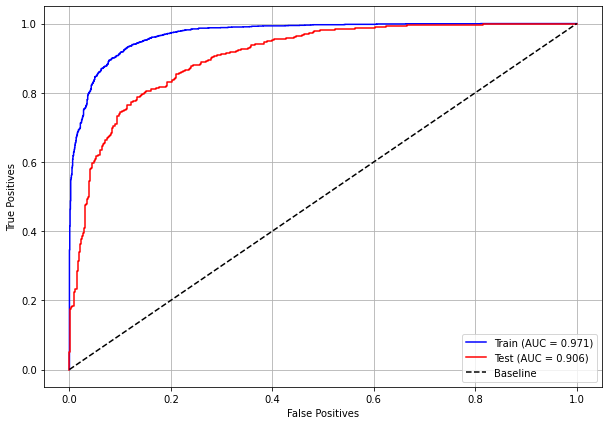

In [ ]:
plot_roc_curve(xgb_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

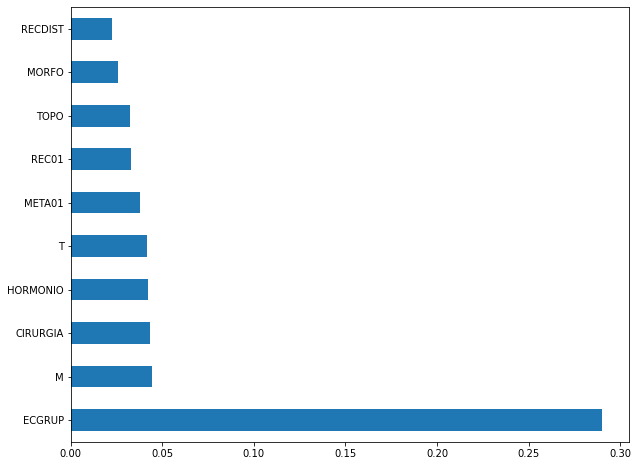

In [ ]:
plot_feat_importances(xgb_fora_04_07, feat_OS_04_07)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `M`, `CIRURGIA` and `HORMONIO`.

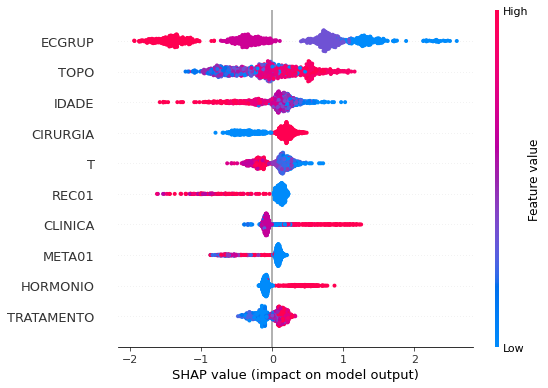

In [ ]:
plot_shap_values(xgb_fora_04_07, X_testOS_04_07, feat_OS_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2008 to 2011
xgb_fora_08_11 = XGBClassifier(max_depth=5, 
                               scale_pos_weight=0.891,
                               random_state=seed)

xgb_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=0.891)

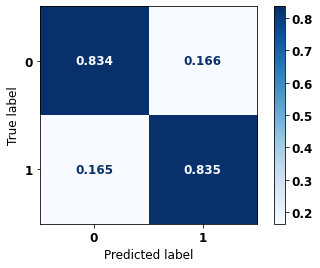


              precision    recall  f1-score   support

           0      0.813     0.834     0.824       604
           1      0.855     0.835     0.845       705

    accuracy                          0.835      1309
   macro avg      0.834     0.835     0.834      1309
weighted avg      0.836     0.835     0.835      1309



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the XGBoost, with other states data from 2008 to 2011, also shows a good performance of the model with 83% of accuracy.

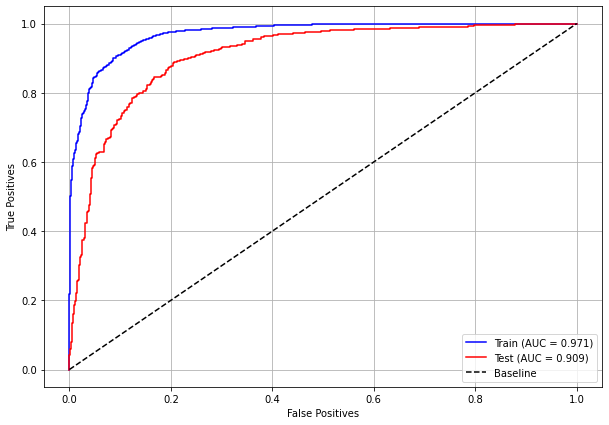

In [ ]:
plot_roc_curve(xgb_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

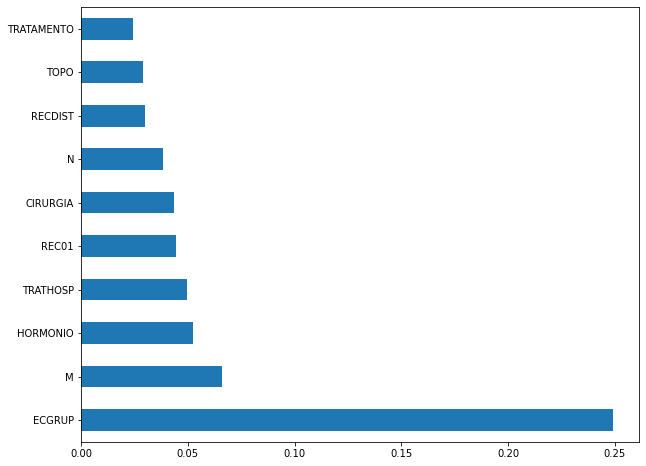

In [ ]:
plot_feat_importances(xgb_fora_08_11, feat_OS_08_11)

> Again we noticed that the most used feature was `ECGRUP`, but not with a lot of advantage. The following most important features were `M`, `HORMONIO` and `TRATHOSP`.

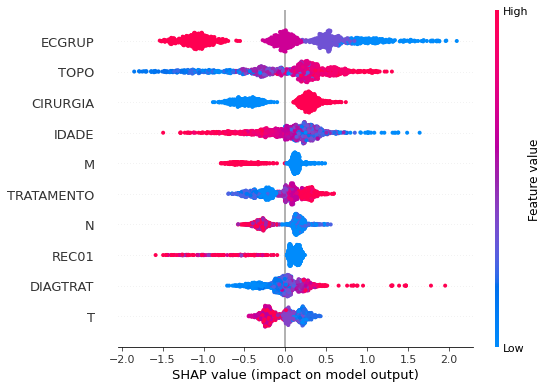

In [ ]:
plot_shap_values(xgb_fora_08_11, X_testOS_08_11, feat_OS_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2012 to 2015
xgb_fora_12_15 = XGBClassifier(max_depth=5, 
                               scale_pos_weight=0.877,
                               random_state=seed)

xgb_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=0.877)

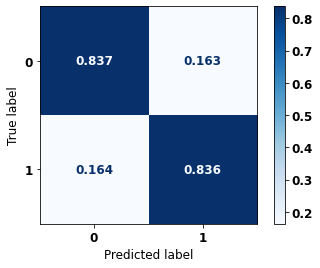


              precision    recall  f1-score   support

           0      0.848     0.837     0.842       664
           1      0.825     0.836     0.830       608

    accuracy                          0.836      1272
   macro avg      0.836     0.836     0.836      1272
weighted avg      0.837     0.836     0.837      1272



In [ ]:
display_confusion_matrix(xgb_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the XGBoost, with other states data from 2012 to 2015, also shows a good performance of the model with 84% of accuracy.

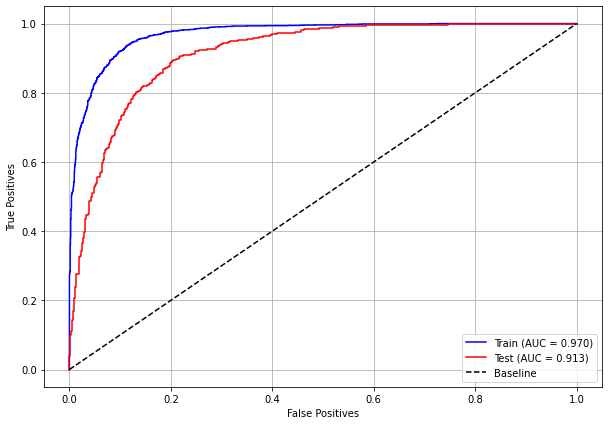

In [ ]:
plot_roc_curve(xgb_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

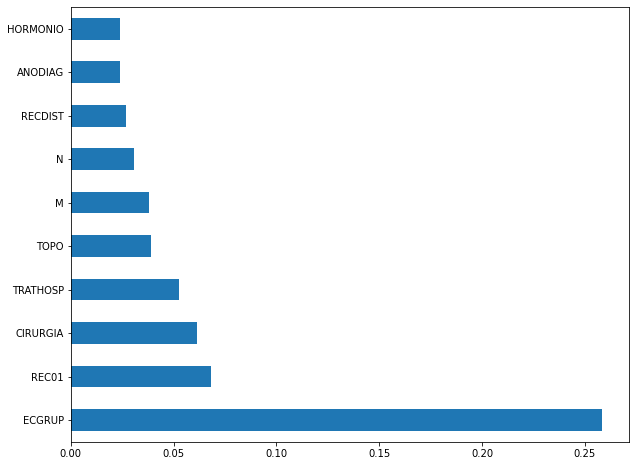

In [ ]:
plot_feat_importances(xgb_fora_12_15, feat_OS_12_15)

> The four most important features were `ECGRUP`, `REC01`, `CIRURGIA` and `TRATHOSP`.

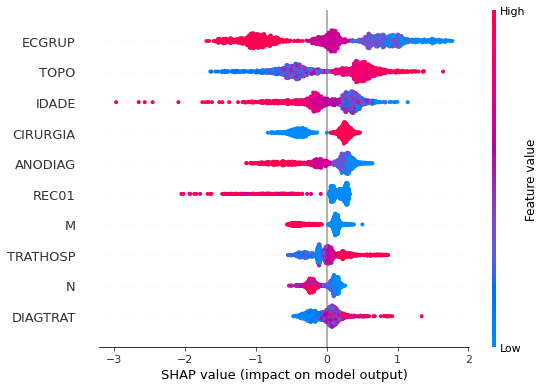

In [ ]:
plot_shap_values(xgb_fora_12_15, X_testOS_12_15, feat_OS_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

## **Testing models with data from other years**

We will use test data from the following years in the trained models for each set of years grouped together.

### **Random Forest SP for years 2000 to 2003**

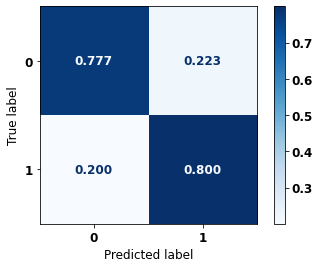


              precision    recall  f1-score   support

           0      0.789     0.777     0.783      9125
           1      0.789     0.800     0.794      9477

    accuracy                          0.789     18602
   macro avg      0.789     0.789     0.789     18602
weighted avg      0.789     0.789     0.789     18602



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_04_07, y_testSP_04_07)

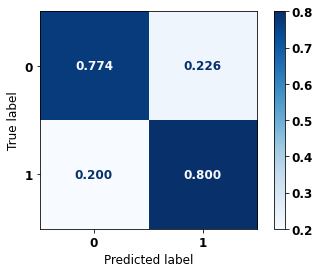


              precision    recall  f1-score   support

           0      0.779     0.774     0.776     11680
           1      0.796     0.800     0.798     12861

    accuracy                          0.788     24541
   macro avg      0.787     0.787     0.787     24541
weighted avg      0.788     0.788     0.788     24541



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_08_11, y_testSP_08_11)

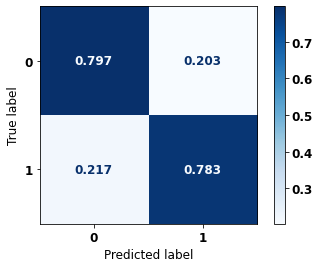


              precision    recall  f1-score   support

           0      0.828     0.797     0.812     12466
           1      0.746     0.783     0.764      9500

    accuracy                          0.791     21966
   macro avg      0.787     0.790     0.788     21966
weighted avg      0.793     0.791     0.791     21966



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_12_15, y_testSP_12_15)

### **XGBoost SP for years 2000 to 2003**

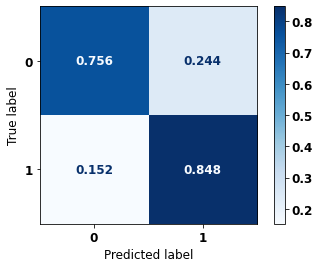


              precision    recall  f1-score   support

           0      0.827     0.756     0.790      9125
           1      0.783     0.848     0.814      9477

    accuracy                          0.803     18602
   macro avg      0.805     0.802     0.802     18602
weighted avg      0.805     0.803     0.802     18602



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_04_07, y_testSP_04_07)

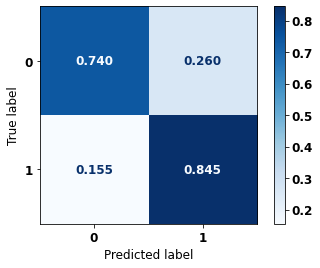


              precision    recall  f1-score   support

           0      0.813     0.740     0.775     11680
           1      0.782     0.845     0.812     12861

    accuracy                          0.795     24541
   macro avg      0.797     0.793     0.794     24541
weighted avg      0.797     0.795     0.794     24541



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_08_11, y_testSP_08_11)

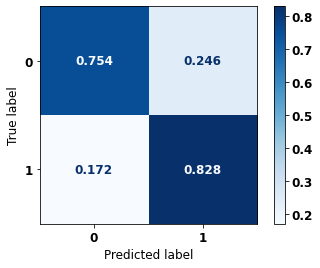


              precision    recall  f1-score   support

           0      0.852     0.754     0.800     12466
           1      0.719     0.828     0.770      9500

    accuracy                          0.786     21966
   macro avg      0.786     0.791     0.785     21966
weighted avg      0.795     0.786     0.787     21966



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_12_15, y_testSP_12_15)

### **Random Forest SP for years 2004 to 2007**

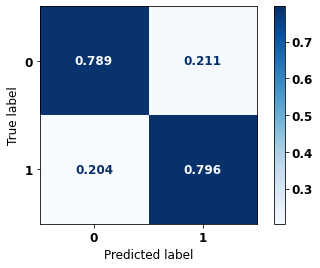


              precision    recall  f1-score   support

           0      0.778     0.789     0.784     11680
           1      0.806     0.796     0.801     12861

    accuracy                          0.793     24541
   macro avg      0.792     0.792     0.792     24541
weighted avg      0.793     0.793     0.793     24541



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_08_11, y_testSP_08_11)

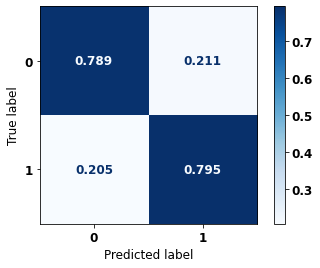


              precision    recall  f1-score   support

           0      0.835     0.789     0.811     12466
           1      0.742     0.795     0.768      9500

    accuracy                          0.792     21966
   macro avg      0.788     0.792     0.789     21966
weighted avg      0.795     0.792     0.792     21966



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_12_15, y_testSP_12_15)

### **XGBoost SP for years 2004 to 2007**

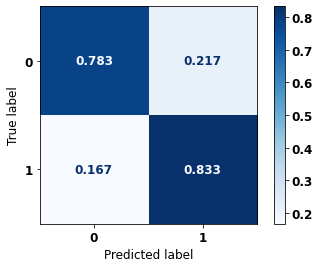


              precision    recall  f1-score   support

           0      0.810     0.783     0.796     11680
           1      0.809     0.833     0.821     12861

    accuracy                          0.809     24541
   macro avg      0.809     0.808     0.809     24541
weighted avg      0.809     0.809     0.809     24541



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_08_11, y_testSP_08_11)

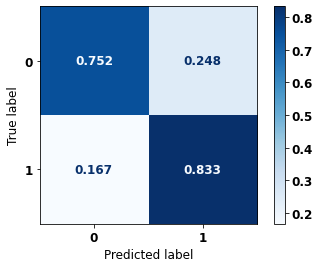


              precision    recall  f1-score   support

           0      0.855     0.752     0.800     12466
           1      0.719     0.833     0.772      9500

    accuracy                          0.787     21966
   macro avg      0.787     0.793     0.786     21966
weighted avg      0.796     0.787     0.788     21966



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_12_15, y_testSP_12_15)

### **Random Forest SP for years 2008 to 2011**

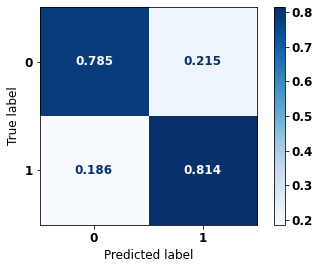


              precision    recall  f1-score   support

           0      0.847     0.785     0.815     12466
           1      0.743     0.814     0.777      9500

    accuracy                          0.798     21966
   macro avg      0.795     0.800     0.796     21966
weighted avg      0.802     0.798     0.799     21966



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_12_15, y_testSP_12_15)

### **XGBoost SP for years 2008 to 2011**

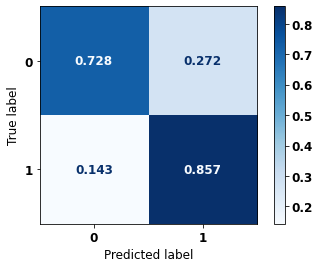


              precision    recall  f1-score   support

           0      0.870     0.728     0.793     12466
           1      0.706     0.857     0.774      9500

    accuracy                          0.784     21966
   macro avg      0.788     0.793     0.784     21966
weighted avg      0.799     0.784     0.785     21966



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_12_15, y_testSP_12_15)

### **Random Forest Other states for years 2000 to 2003**

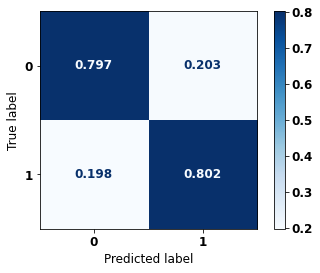


              precision    recall  f1-score   support

           0      0.778     0.797     0.788       528
           1      0.819     0.802     0.810       605

    accuracy                          0.800      1133
   macro avg      0.799     0.800     0.799      1133
weighted avg      0.800     0.800     0.800      1133



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_04_07, y_testOS_04_07)

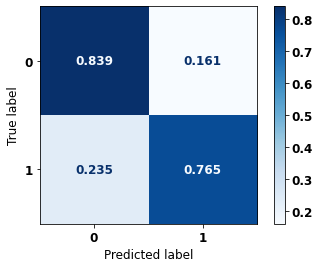


              precision    recall  f1-score   support

           0      0.753     0.839     0.794       604
           1      0.847     0.765     0.804       705

    accuracy                          0.799      1309
   macro avg      0.800     0.802     0.799      1309
weighted avg      0.804     0.799     0.799      1309



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_08_11, y_testOS_08_11)

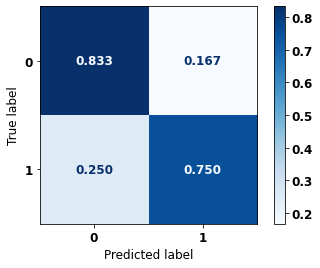


              precision    recall  f1-score   support

           0      0.784     0.833     0.808       664
           1      0.804     0.750     0.776       608

    accuracy                          0.793      1272
   macro avg      0.794     0.791     0.792      1272
weighted avg      0.794     0.793     0.793      1272



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_12_15, y_testOS_12_15)

### **XGBoost Other states for years 2000 to 2003**

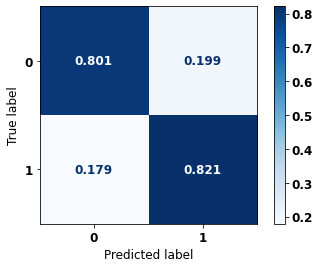


              precision    recall  f1-score   support

           0      0.797     0.801     0.799       528
           1      0.826     0.821     0.824       605

    accuracy                          0.812      1133
   macro avg      0.811     0.811     0.811      1133
weighted avg      0.812     0.812     0.812      1133



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_04_07, y_testOS_04_07)

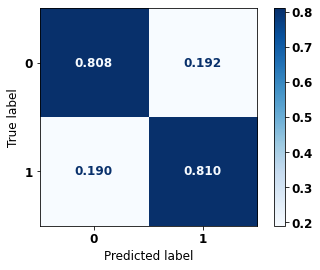


              precision    recall  f1-score   support

           0      0.785     0.808     0.796       604
           1      0.831     0.810     0.820       705

    accuracy                          0.809      1309
   macro avg      0.808     0.809     0.808      1309
weighted avg      0.810     0.809     0.809      1309



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_08_11, y_testOS_08_11)

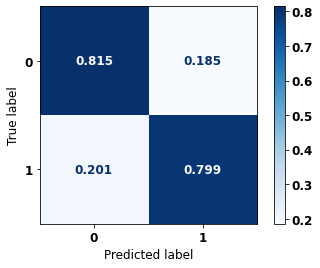


              precision    recall  f1-score   support

           0      0.816     0.815     0.815       664
           1      0.798     0.799     0.799       608

    accuracy                          0.807      1272
   macro avg      0.807     0.807     0.807      1272
weighted avg      0.807     0.807     0.807      1272



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_12_15, y_testOS_12_15)

### **Random Forest Other states for years 2004 to 2007**

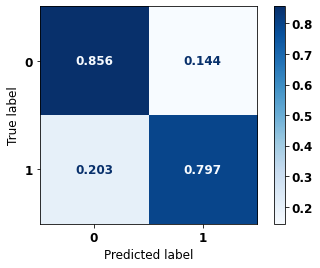


              precision    recall  f1-score   support

           0      0.783     0.856     0.818       604
           1      0.866     0.797     0.830       705

    accuracy                          0.824      1309
   macro avg      0.825     0.827     0.824      1309
weighted avg      0.828     0.824     0.825      1309



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_08_11, y_testOS_08_11)

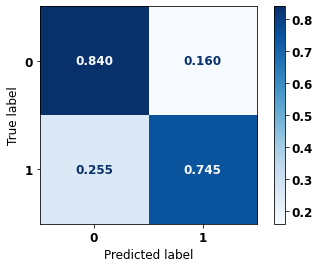


              precision    recall  f1-score   support

           0      0.783     0.840     0.810       664
           1      0.810     0.745     0.776       608

    accuracy                          0.795      1272
   macro avg      0.796     0.793     0.793      1272
weighted avg      0.796     0.795     0.794      1272



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_12_15, y_testOS_12_15)

### **XGBoost Other states for years 2004 to 2007**

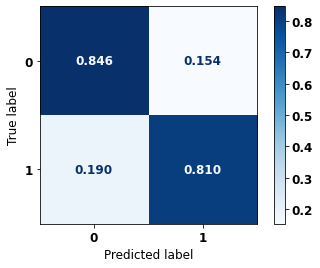


              precision    recall  f1-score   support

           0      0.792     0.846     0.818       604
           1      0.860     0.810     0.834       705

    accuracy                          0.827      1309
   macro avg      0.826     0.828     0.826      1309
weighted avg      0.829     0.827     0.827      1309



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_08_11, y_testOS_08_11)

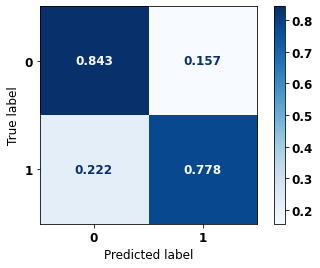


              precision    recall  f1-score   support

           0      0.806     0.843     0.824       664
           1      0.820     0.778     0.798       608

    accuracy                          0.812      1272
   macro avg      0.813     0.811     0.811      1272
weighted avg      0.812     0.812     0.812      1272



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_12_15, y_testOS_12_15)

### **Random Forest Other states for years 2008 to 2011**

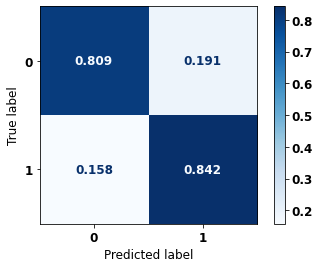


              precision    recall  f1-score   support

           0      0.848     0.809     0.828       664
           1      0.801     0.842     0.821       608

    accuracy                          0.825      1272
   macro avg      0.825     0.825     0.825      1272
weighted avg      0.826     0.825     0.825      1272



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_12_15, y_testOS_12_15)

### **XGBoost Other states for years 2008 to 2011**

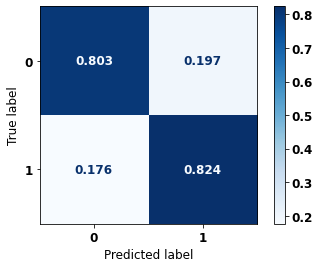


              precision    recall  f1-score   support

           0      0.833     0.803     0.817       664
           1      0.793     0.824     0.808       608

    accuracy                          0.813      1272
   macro avg      0.813     0.813     0.813      1272
weighted avg      0.814     0.813     0.813      1272



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_12_15, y_testOS_12_15)

# **Fifth approach**

Approach with grouped years and without the columns `EC` and `HORMONIO`.

## **Preprocessing**

Now we are going to divide the data into training and testing, and then do the preprocessing in both datasets to perform the training of the models and their evaluation. We will use the years grouped too, resulting in 5 datasets for SP and more 5 for other states.

First, it is necessary to define the columns that will be used as features and the label. We will not use some columns of the datasets: `UFRESID`, because we already have the division between SP and other states in the two datasets. 

It was chosen to keep the column `IDADE`, so we will not use the `FAIXAETAR`, as well as the column `ECGRUP` and not the column `EC`. Finally, the other columns contained in the list `list_drop` are possible labels, so they will not be used as features for machine learning models.

In [ ]:
list_drop = ['UFRESID', 'FAIXAETAR', 'ULTICONS', 'ULTIDIAG', 'ULTITRAT', 
             'obito_geral', 'obito_cancer', 'vivo_ano1', 'vivo_ano3',
             'ULTINFO', 'EC', 'HORMONIO']

# 'RECNENHUM', 'RECLOCAL', 'RECREGIO', 'REC01', 'REC02', 'REC03', 'RECDIST'

lb = 'vivo_ano5'

A function was created to perform the preprocessing, `preprocessing`, that uses the other functions created, `get_train_test` (divides the dataset into train and test sets), `train_preprocessing` (do the preprocessing of the train set) and `test_preprocessing` (do the preprocessing of the test set). 

The process will be done 5 times for SP and other states, using the datasets with grouped years.

> To see the complete function go to the [functions section](https://cancer-project.readthedocs.io/en/latest/Cancer%20Libraries%20and%20functions.html#Models).

### **SP**

In [ ]:
X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03, feat_SP_00_03 = preprocessing(df_SP_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2000, 
                                                                                                last_year=2003, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (44789, 64), X_test = (14930, 64)
y_train = (44789,), y_test = (14930,)


In [ ]:
X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07, feat_SP_04_07 = preprocessing(df_SP_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2004, 
                                                                                                last_year=2007,
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')                                                            

X_train = (55804, 64), X_test = (18602, 64)
y_train = (55804,), y_test = (18602,)


In [ ]:
X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11, feat_SP_08_11 = preprocessing(df_SP_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2008, 
                                                                                                last_year=2011, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (73620, 64), X_test = (24541, 64)
y_train = (73620,), y_test = (24541,)


In [ ]:
X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15, feat_SP_12_15 = preprocessing(df_SP_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2012, 
                                                                                                last_year=2015, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (65896, 64), X_test = (21966, 64)
y_train = (65896,), y_test = (21966,)


### **Other states**

In [ ]:
X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03, feat_OS_00_03 = preprocessing(df_fora_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2000, 
                                                                                                last_year=2003, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (2588, 64), X_test = (863, 64)
y_train = (2588,), y_test = (863,)


In [ ]:
X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07, feat_OS_04_07 = preprocessing(df_fora_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2004, 
                                                                                                last_year=2007, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (3396, 64), X_test = (1133, 64)
y_train = (3396,), y_test = (1133,)


In [ ]:
X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11, feat_OS_08_11 = preprocessing(df_fora_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2008, 
                                                                                                last_year=2011, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (3926, 64), X_test = (1309, 64)
y_train = (3926,), y_test = (1309,)


In [ ]:
X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15, feat_OS_12_15 = preprocessing(df_fora_ano5, list_drop, lb, 
                                                                                                group_years=True, 
                                                                                                first_year=2012, 
                                                                                                last_year=2015, 
                                                                                                random_state=seed,
                                                                                                balance_data=False,
                                                                                                encoder_type='LabelEncoder', 
                                                                                                norm_name='StandardScaler')

X_train = (3814, 64), X_test = (1272, 64)
y_train = (3814,), y_test = (1272,)


## **Training and evaluation of the models**

After dividing the data into training and testing, using the encoder and normalizing, the data is ready to be used by the machine learning models.

### **Random Forest**


The first model is the Random Forest, the `random_state` will be used as a parameter, to obtain the same training values of the model every time it is runned.

The hyperparameter `class_weight` was used because the models have difficulty to learn the class with fewer examples.

**SP**

In [ ]:
# SP - 2000 to 2003
rf_sp_00_03 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1.01},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

RandomForestClassifier(class_weight={0: 1, 1: 1.01}, criterion='entropy',
                       max_depth=10, random_state=10)

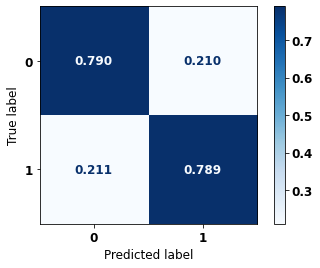


              precision    recall  f1-score   support

           0      0.803     0.790     0.796      7787
           1      0.775     0.789     0.782      7143

    accuracy                          0.789     14930
   macro avg      0.789     0.789     0.789     14930
weighted avg      0.790     0.789     0.789     14930



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the Random Forest, with SP data from 2000 to 2003, shows a good performance of the model, with 79% of accuracy.


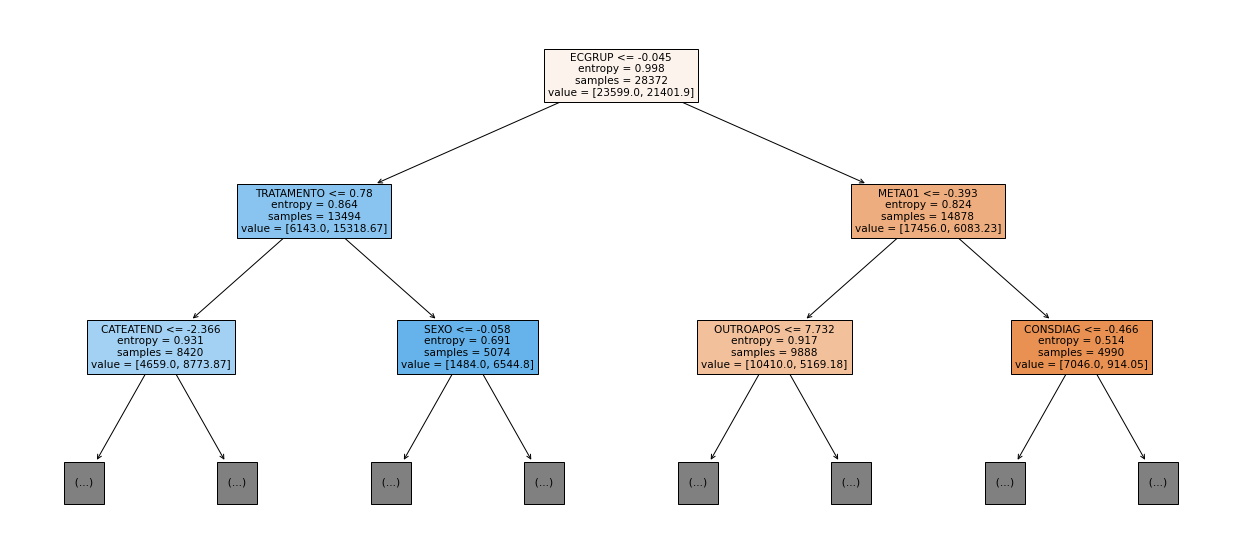

In [ ]:
show_tree(rf_sp_00_03, feat_SP_00_03, 2)

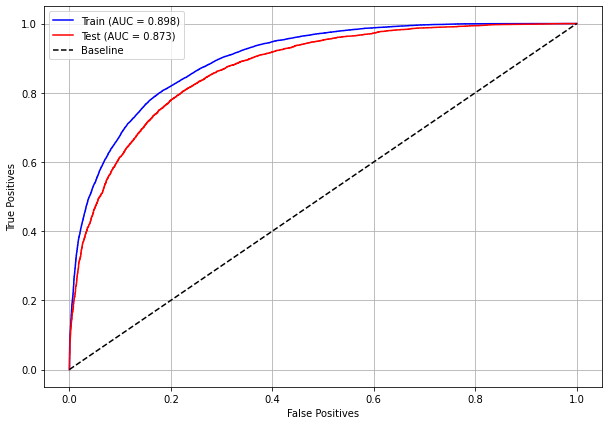

In [ ]:
plot_roc_curve(rf_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

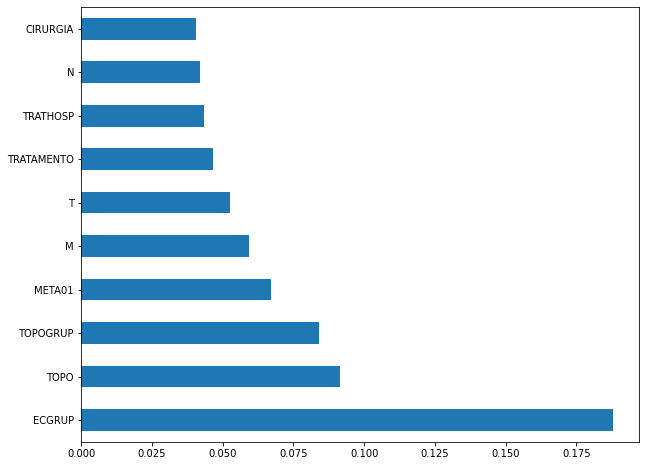

In [ ]:
plot_feat_importances(rf_sp_00_03, feat_SP_00_03)

> The four most important features in the model were `ECGRUP`, `TOPO`, `TOPOGRUP`, and `META01`. 

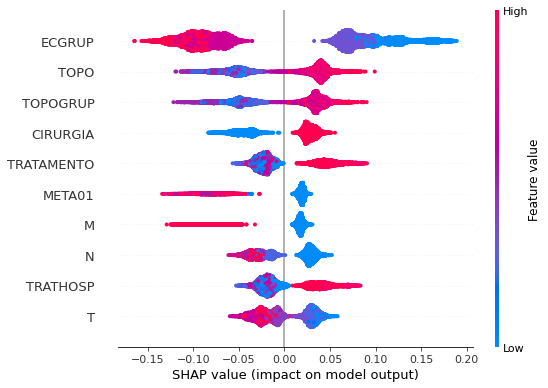

In [ ]:
plot_shap_values(rf_sp_00_03, X_testSP_00_03, feat_SP_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2004 to 2007
rf_sp_04_07 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1.146, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

RandomForestClassifier(class_weight={0: 1.146, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

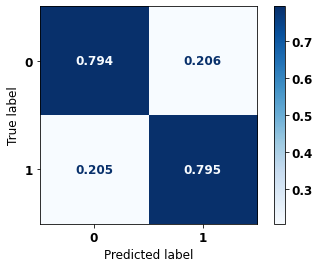


              precision    recall  f1-score   support

           0      0.789     0.794     0.792      9125
           1      0.801     0.795     0.798      9477

    accuracy                          0.795     18602
   macro avg      0.795     0.795     0.795     18602
weighted avg      0.795     0.795     0.795     18602



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the Random Forest, with SP data from 2004 to 2007, shows a good performance of the model, with 79% of accuracy.

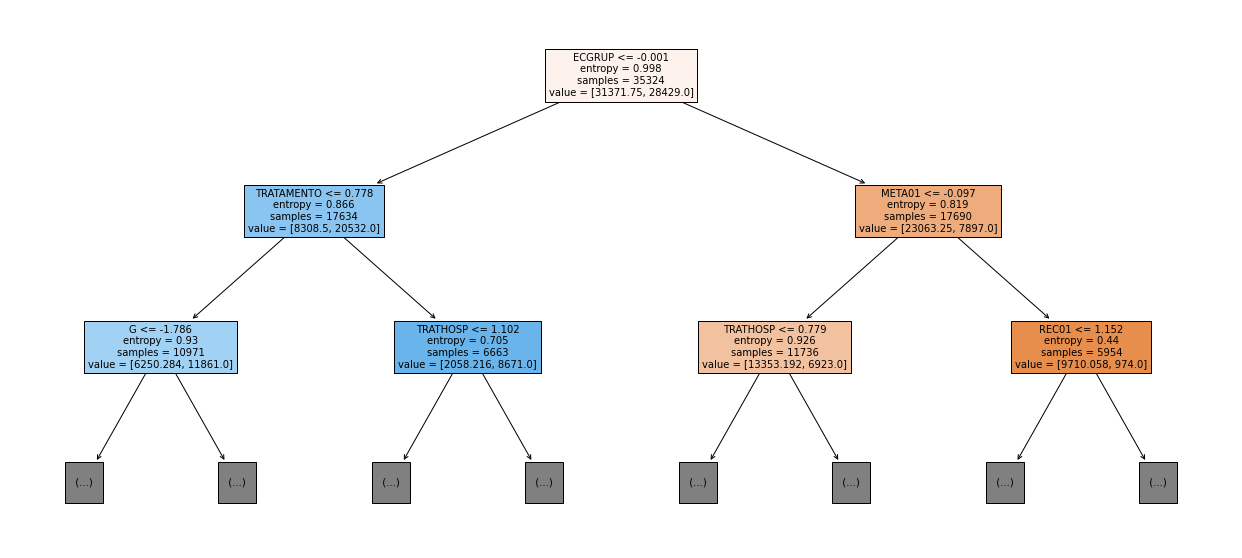

In [ ]:
show_tree(rf_sp_04_07, feat_SP_04_07, 2)

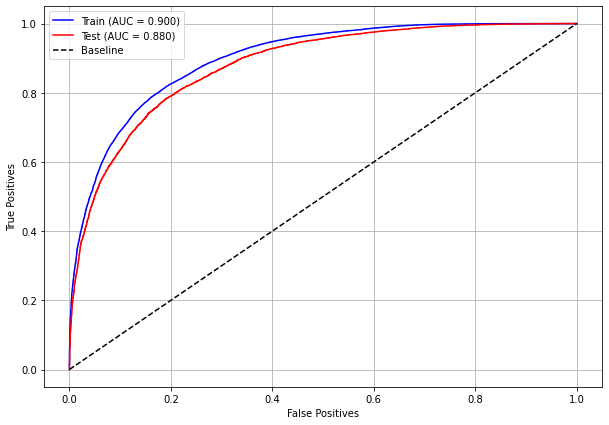

In [ ]:
plot_roc_curve(rf_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

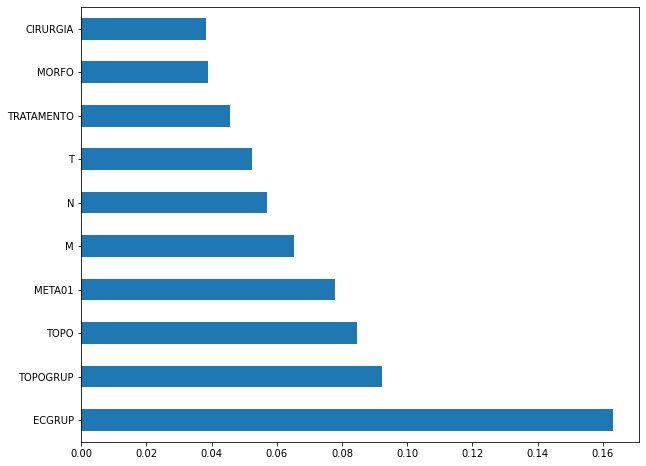

In [ ]:
plot_feat_importances(rf_sp_04_07, feat_SP_04_07)

> The four most important features in the model were `ECGRUP`, `TOPOGRUP`, `TOPO` and `META01`.

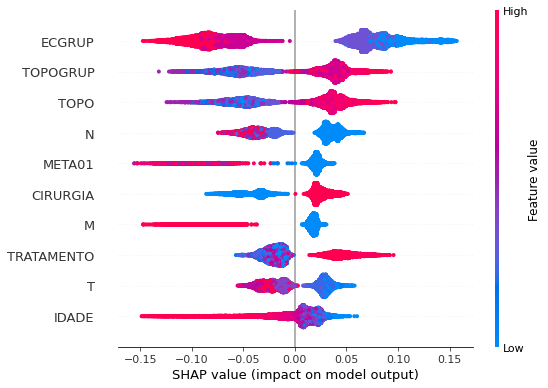

In [ ]:
plot_shap_values(rf_sp_04_07, X_testSP_04_07, feat_SP_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2008 to 2011
rf_sp_08_11 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1.26, 1:1},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

RandomForestClassifier(class_weight={0: 1.26, 1: 1}, criterion='entropy',
                       max_depth=10, random_state=10)

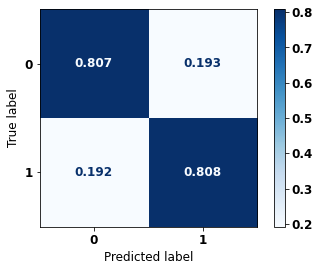


              precision    recall  f1-score   support

           0      0.792     0.807     0.800     11680
           1      0.822     0.808     0.815     12861

    accuracy                          0.808     24541
   macro avg      0.807     0.808     0.807     24541
weighted avg      0.808     0.808     0.808     24541



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the Random Forest, with SP data from 2008 to 2011, shows a good performance of the model, with 81% of accuracy.

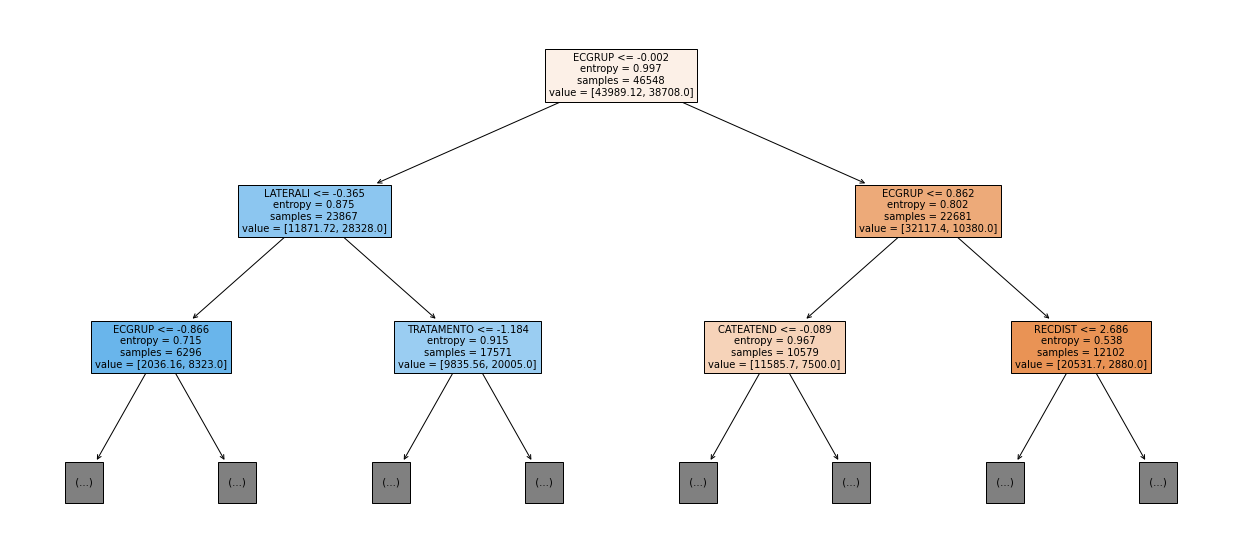

In [ ]:
show_tree(rf_sp_08_11, feat_SP_08_11, 2)

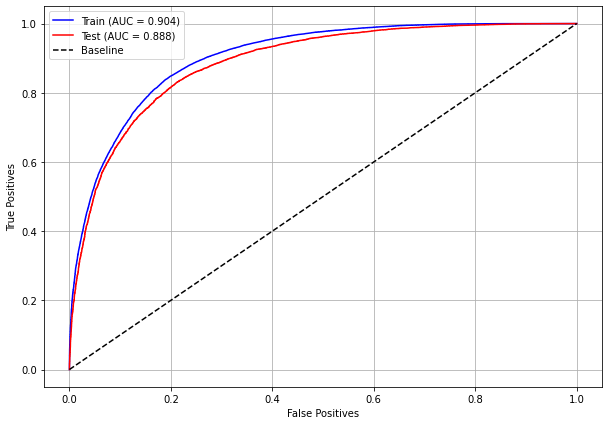

In [ ]:
plot_roc_curve(rf_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

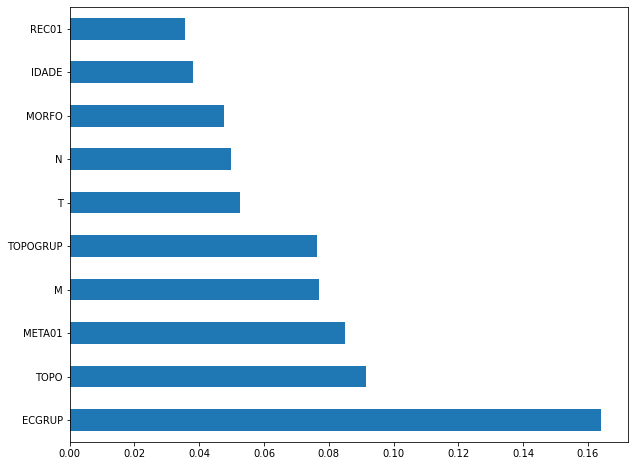

In [ ]:
plot_feat_importances(rf_sp_08_11, feat_SP_08_11)

> The four most important features in the model were `ECGRUP`, `TOPO`, `META01` and `M`.

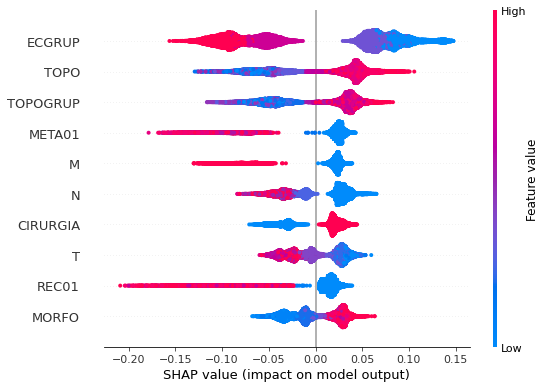

In [ ]:
plot_shap_values(rf_sp_08_11, X_testSP_08_11, feat_SP_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2012 to 2015
rf_sp_12_15 = RandomForestClassifier(random_state=seed, 
                                     class_weight={0:1, 1:1.18},
                                     criterion='entropy',
                                     max_depth=10)

rf_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

RandomForestClassifier(class_weight={0: 1, 1: 1.18}, criterion='entropy',
                       max_depth=10, random_state=10)

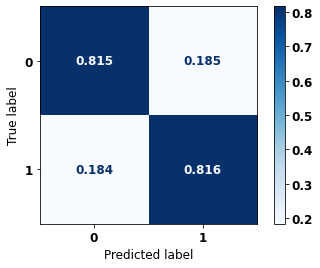


              precision    recall  f1-score   support

           0      0.854     0.815     0.834     12466
           1      0.771     0.816     0.793      9500

    accuracy                          0.816     21966
   macro avg      0.812     0.816     0.814     21966
weighted avg      0.818     0.816     0.816     21966



In [ ]:
display_confusion_matrix(rf_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the Random Forest, with SP data from 2012 to 2015, shows a good performance of the model with 82% of accuracy.

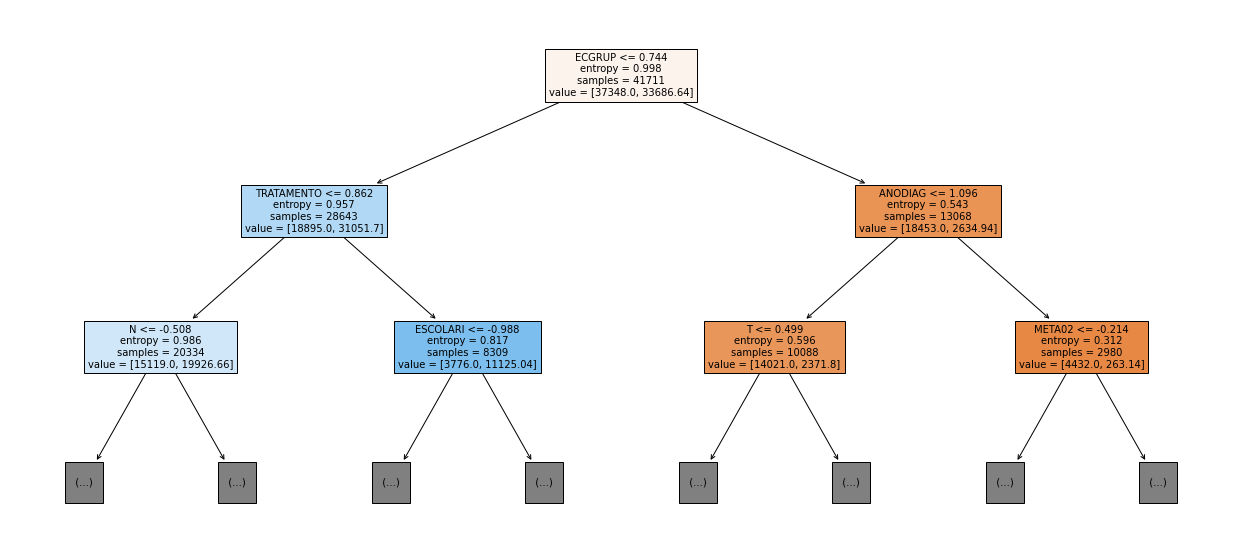

In [ ]:
show_tree(rf_sp_12_15, feat_SP_12_15, 2)

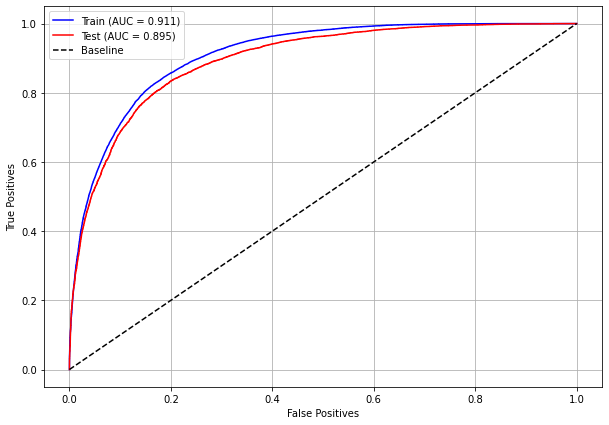

In [ ]:
plot_roc_curve(rf_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

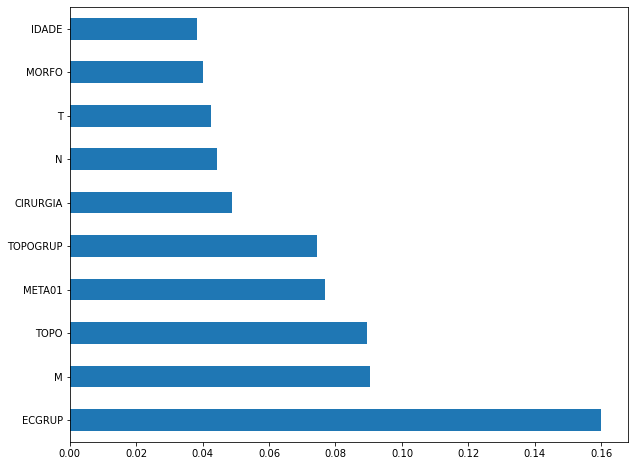

In [ ]:
plot_feat_importances(rf_sp_12_15, feat_SP_12_15)

> The four most important features in the model were `ECGRUP`, `M`, `TOPO` and `META01`.

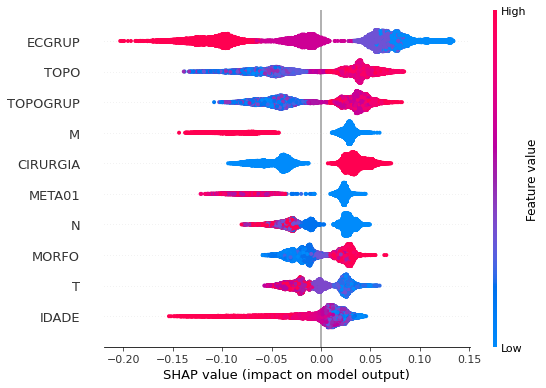

In [ ]:
plot_shap_values(rf_sp_12_15, X_testSP_12_15, feat_SP_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

**Other states**

In [ ]:
# Other states - 2000 to 2003
rf_fora_00_03 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1.34, 1:1},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

RandomForestClassifier(class_weight={0: 1.34, 1: 1}, criterion='entropy',
                       max_depth=6, random_state=10)

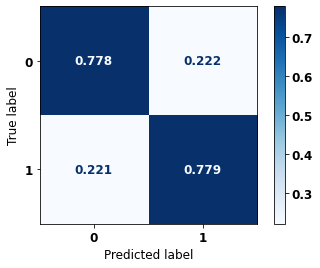


              precision    recall  f1-score   support

           0      0.769     0.778     0.773       419
           1      0.788     0.779     0.784       444

    accuracy                          0.779       863
   macro avg      0.779     0.779     0.779       863
weighted avg      0.779     0.779     0.779       863



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the Random Forest, with other states data from 2000 to 2003, also shows a good performance of the model, and we have a balanced main diagonal with 78% of accuracy.

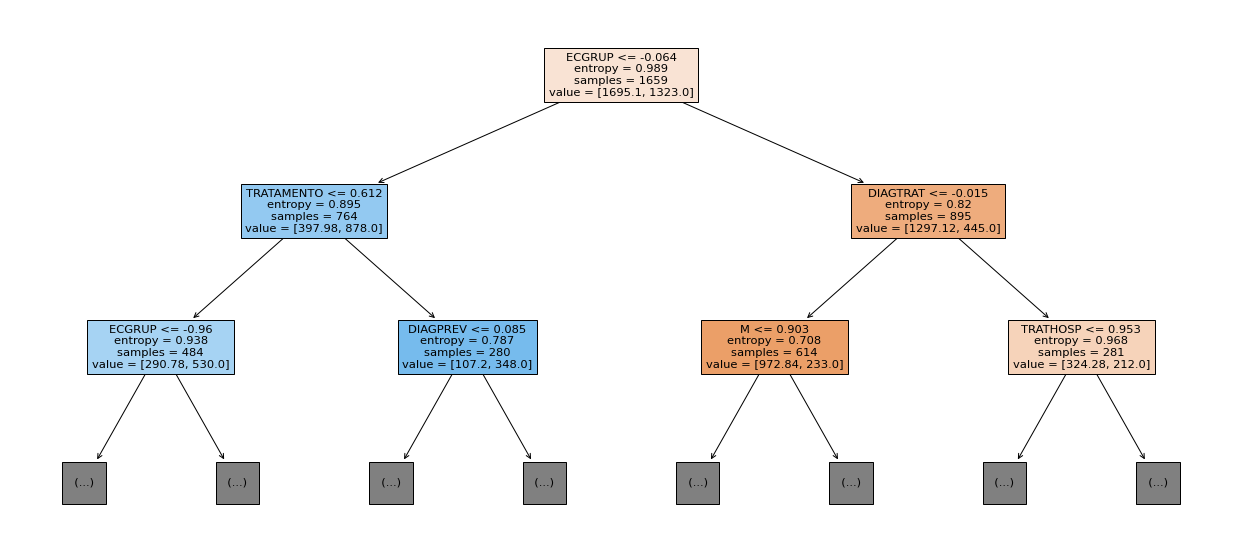

In [ ]:
show_tree(rf_fora_00_03, feat_OS_00_03, 2)

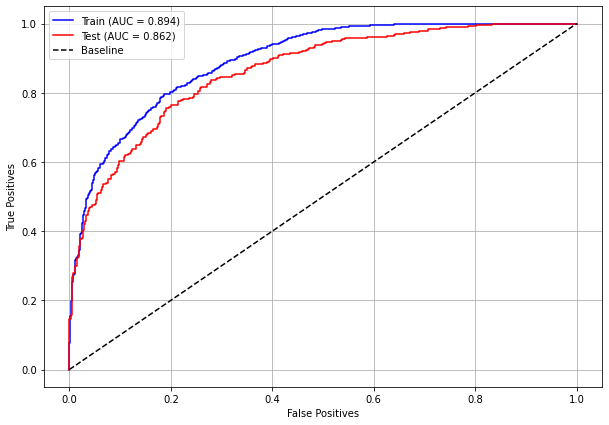

In [ ]:
plot_roc_curve(rf_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

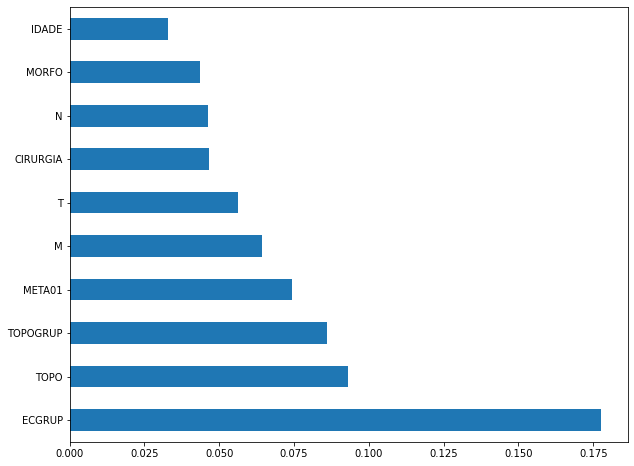

In [ ]:
plot_feat_importances(rf_fora_00_03, feat_OS_00_03)

> The four most important features in the model were `ECGRUP`, `TOPO`, `TOPOGRUP` and `META01`.

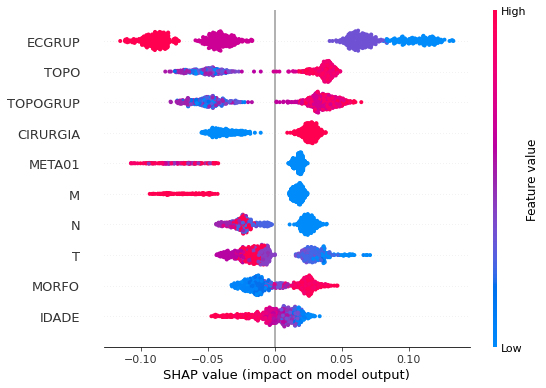

In [ ]:
plot_shap_values(rf_fora_00_03, X_testOS_00_03, feat_OS_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2004 to 2007
rf_fora_04_07 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1.4505, 1:1},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

RandomForestClassifier(class_weight={0: 1.4505, 1: 1}, criterion='entropy',
                       max_depth=6, random_state=10)

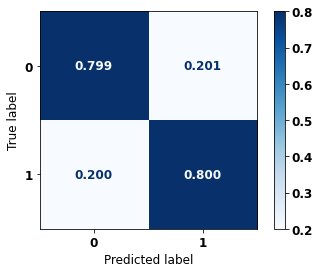


              precision    recall  f1-score   support

           0      0.777     0.799     0.788       528
           1      0.820     0.800     0.810       605

    accuracy                          0.800      1133
   macro avg      0.799     0.800     0.799      1133
weighted avg      0.800     0.800     0.800      1133



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the Random Forest, with other states data from 2004 to 2007, also shows a good performance of the model, with 80% of accuracy.


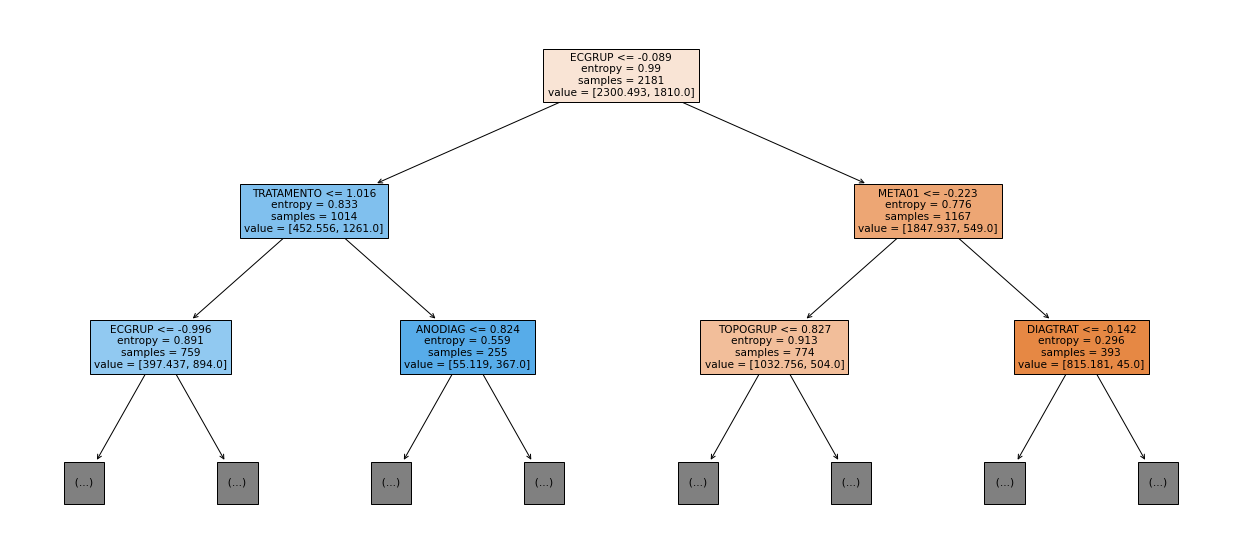

In [ ]:
show_tree(rf_fora_04_07, feat_OS_04_07, 2)

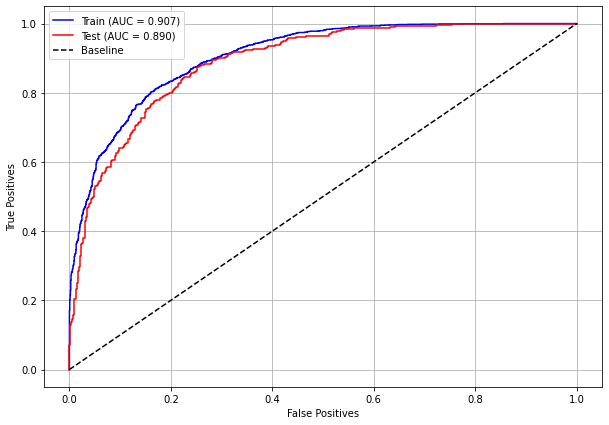

In [ ]:
plot_roc_curve(rf_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

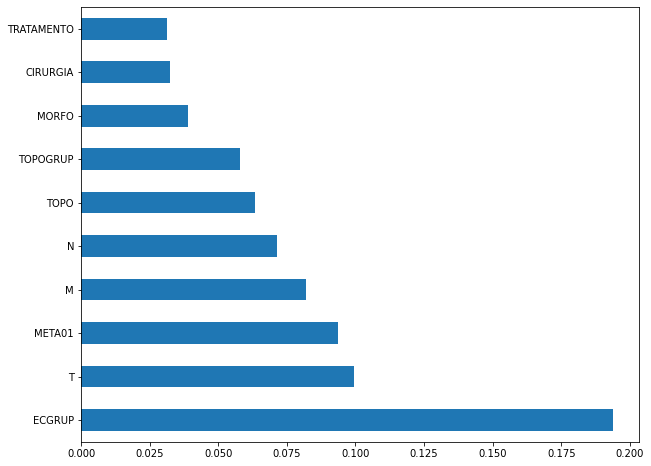

In [ ]:
plot_feat_importances(rf_fora_04_07, feat_OS_04_07)

> The four most important features in the model were `ECGRUP`, `T`, `META01` and `M`.

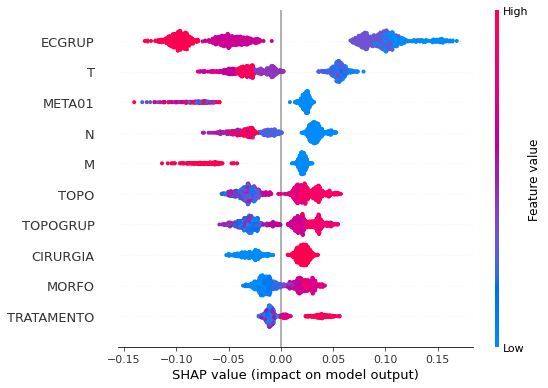

In [ ]:
plot_shap_values(rf_fora_04_07, X_testOS_04_07, feat_OS_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2008 to 2011
rf_fora_08_11 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1.356, 1:1},
                                       criterion='entropy',
                                       max_depth=6)

rf_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

RandomForestClassifier(class_weight={0: 1.356, 1: 1}, criterion='entropy',
                       max_depth=6, random_state=10)

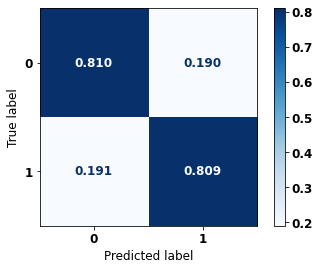


              precision    recall  f1-score   support

           0      0.784     0.810     0.796       604
           1      0.832     0.809     0.820       705

    accuracy                          0.809      1309
   macro avg      0.808     0.809     0.808      1309
weighted avg      0.810     0.809     0.809      1309



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the Random Forest, with other states data from 2008 to 2011, also shows a good performance of the model, presenting 81% of accuracy.


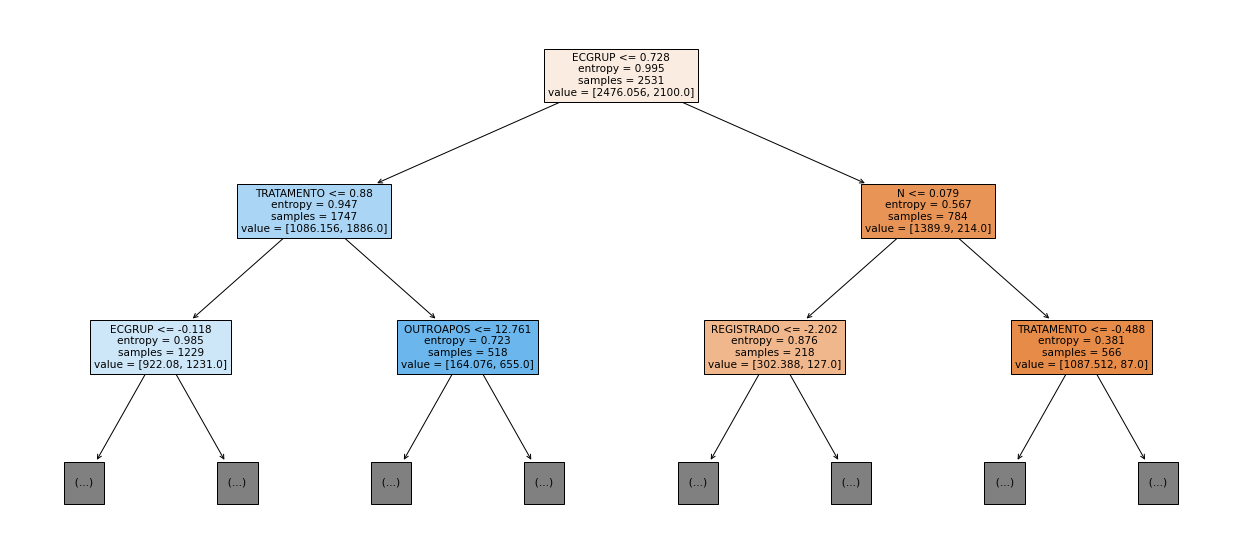

In [ ]:
show_tree(rf_fora_08_11, feat_OS_08_11, 2)

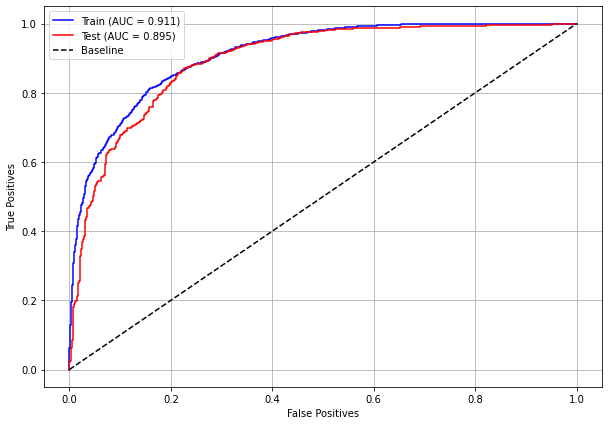

In [ ]:
plot_roc_curve(rf_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

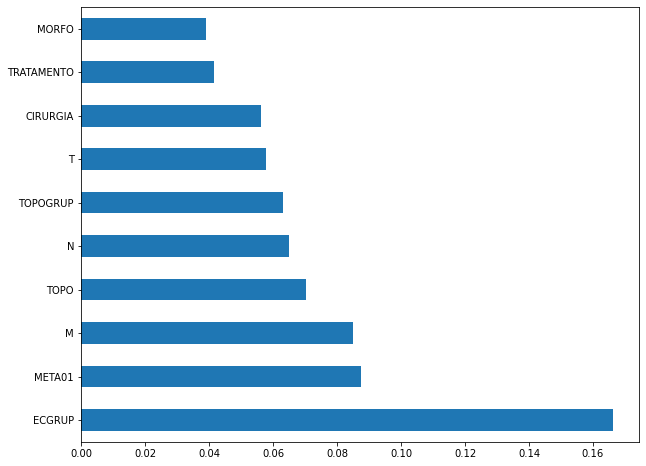

In [ ]:
plot_feat_importances(rf_fora_08_11, feat_OS_08_11)

> The four most important features in the model were `ECGRUP`, `META01`, `M` and `TOPO`.

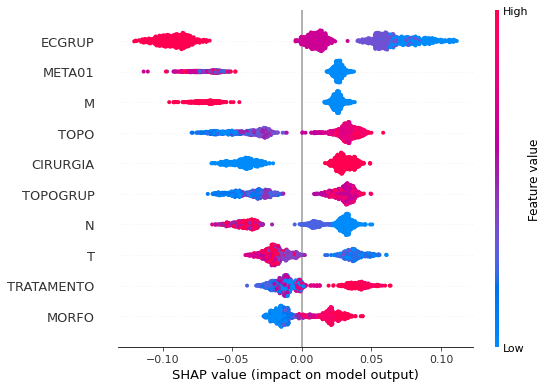

In [ ]:
plot_shap_values(rf_fora_08_11, X_testOS_08_11, feat_OS_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2012 to 2015
rf_fora_12_15 = RandomForestClassifier(random_state=seed, 
                                       class_weight={0:1.14, 1:1},
                                       criterion='entropy',
                                       max_depth=7)

rf_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

RandomForestClassifier(class_weight={0: 1.14, 1: 1}, criterion='entropy',
                       max_depth=7, random_state=10)

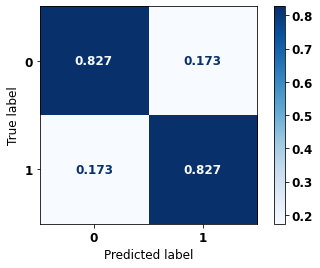


              precision    recall  f1-score   support

           0      0.839     0.827     0.833       664
           1      0.814     0.827     0.821       608

    accuracy                          0.827      1272
   macro avg      0.827     0.827     0.827      1272
weighted avg      0.827     0.827     0.827      1272



In [ ]:
display_confusion_matrix(rf_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the Random Forest, with other states data from 2012 to 2015, also shows a good performance of the model, presenting 83% of accuracy.


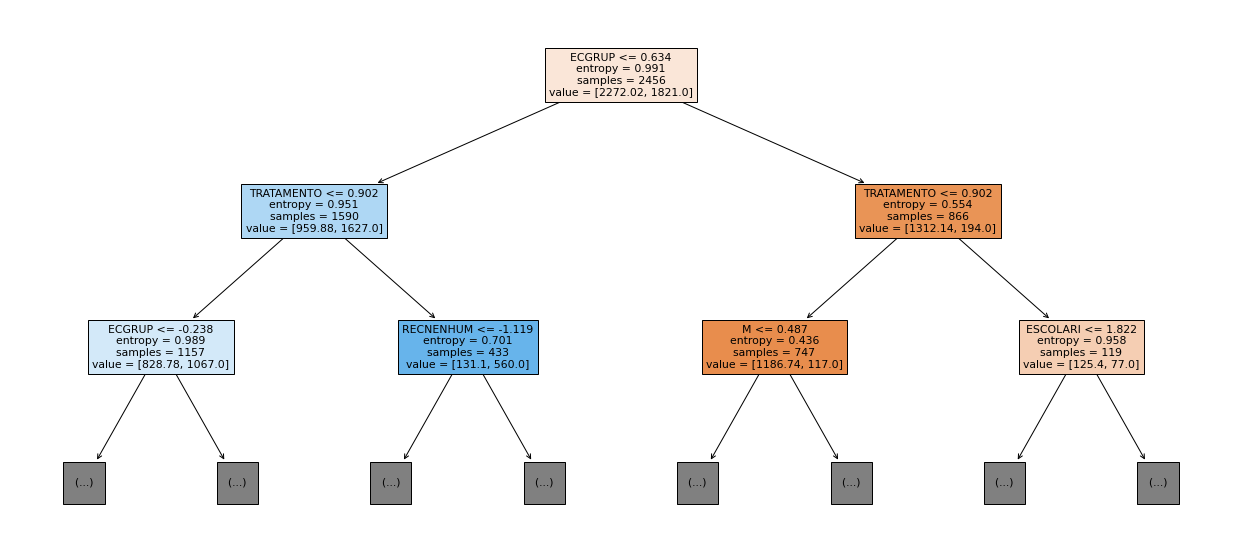

In [ ]:
show_tree(rf_fora_12_15, feat_OS_12_15, 2)

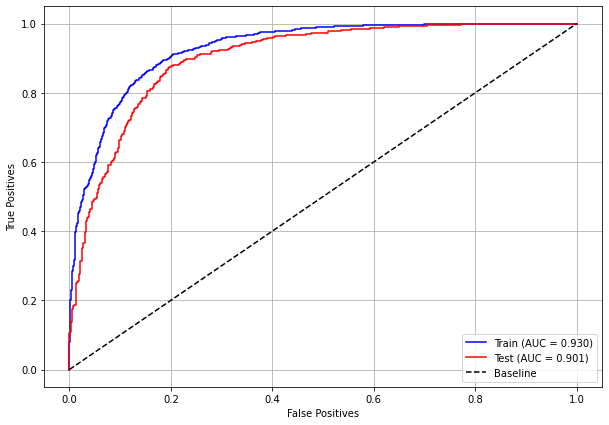

In [ ]:
plot_roc_curve(rf_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

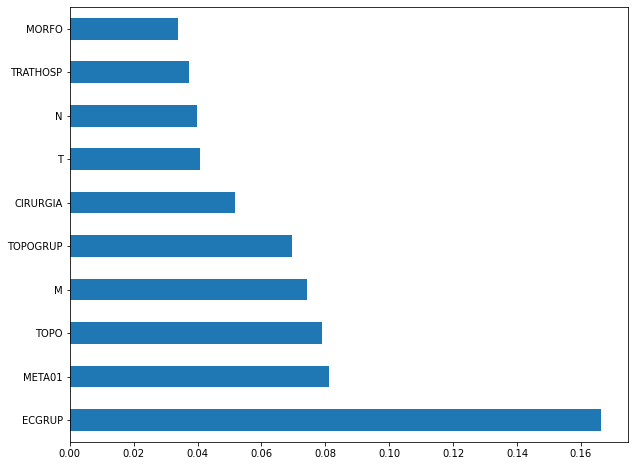

In [ ]:
plot_feat_importances(rf_fora_12_15, feat_OS_12_15)

> The four most important features in the model were `ECGRUP`, `META01`, `TOPO` and `M`.

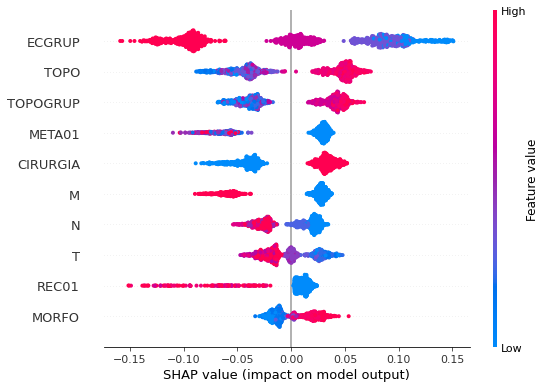

In [ ]:
plot_shap_values(rf_fora_12_15, X_testOS_12_15, feat_OS_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

### **XGBoost**


The training of the XGBoost models follows the same pattern with `random_state`. The hyperparameter `scale_pos_weight` was also used in some trainings, in order to obtain a balanced main diagonal in the confusion matrix.

The hyperparameter `max_depth` was chosen as 10 because the default value for this hyperparameter is 3, a low value for the amount of data we have.

**SP**

In [ ]:
# SP - 2000 to 2003
xgb_sp_00_03 = XGBClassifier(max_depth=8, 
                             random_state=seed, 
                             scale_pos_weight=1.107)

xgb_sp_00_03.fit(X_trainSP_00_03, y_trainSP_00_03)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=1.107)

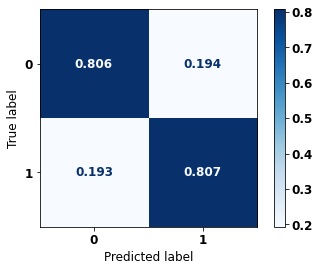


              precision    recall  f1-score   support

           0      0.820     0.806     0.813      7787
           1      0.793     0.807     0.800      7143

    accuracy                          0.807     14930
   macro avg      0.806     0.807     0.806     14930
weighted avg      0.807     0.807     0.807     14930



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_00_03, y_testSP_00_03)

> The confusion matrix obtained for the XGBoost, with SP data from 2000 to 2003, shows a good performance of the model, here with 81% of accuracy.

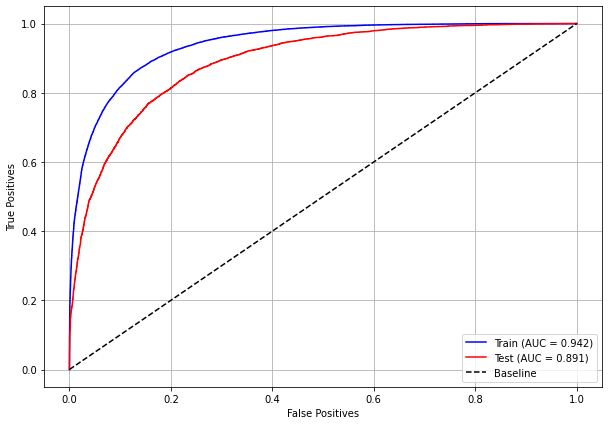

In [ ]:
plot_roc_curve(xgb_sp_00_03, X_trainSP_00_03, X_testSP_00_03, y_trainSP_00_03, y_testSP_00_03)

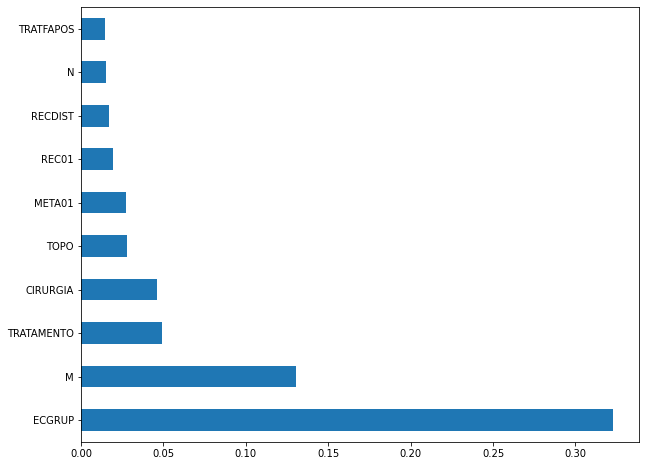

In [ ]:
plot_feat_importances(xgb_sp_00_03, feat_SP_00_03)

> Here we noticed that the most used feature was `ECGRUP`, with a lot advantage over the others. Following we have `M`, `TRATAMENTO` and `CIRURGIA`.

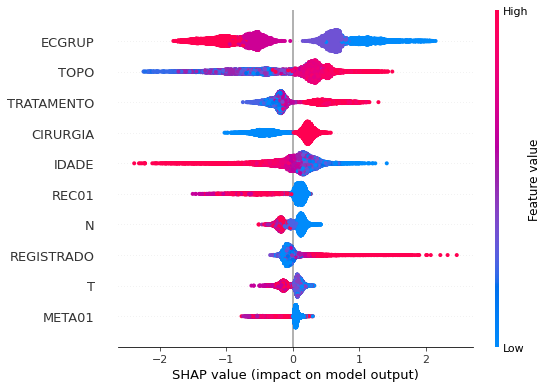

In [ ]:
plot_shap_values(xgb_sp_00_03, X_testSP_00_03, feat_SP_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2004 to 2007
xgb_sp_04_07 = XGBClassifier(max_depth=8, 
                             random_state=seed, 
                             scale_pos_weight=0.9605)

xgb_sp_04_07.fit(X_trainSP_04_07, y_trainSP_04_07)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=0.9605)

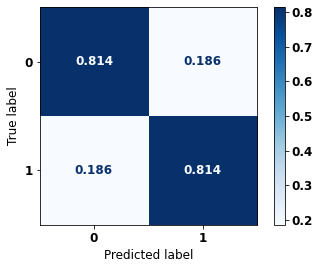


              precision    recall  f1-score   support

           0      0.808     0.814     0.811      9125
           1      0.819     0.814     0.817      9477

    accuracy                          0.814     18602
   macro avg      0.814     0.814     0.814     18602
weighted avg      0.814     0.814     0.814     18602



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_04_07, y_testSP_04_07)

> The confusion matrix obtained for the XGBoost, with SP data from 2004 to 2007, shows a good performance of the model, with 81% of accuracy.


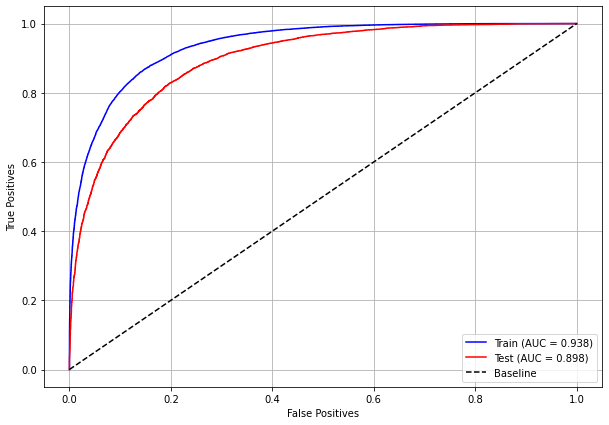

In [ ]:
plot_roc_curve(xgb_sp_04_07, X_trainSP_04_07, X_testSP_04_07, y_trainSP_04_07, y_testSP_04_07)

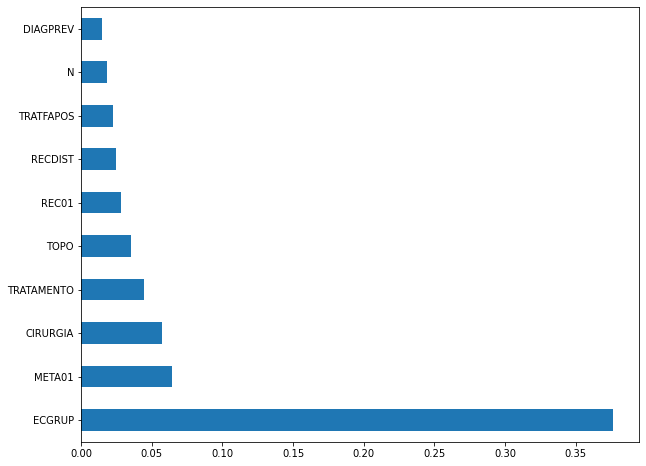

In [ ]:
plot_feat_importances(xgb_sp_04_07, feat_SP_04_07)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `META01`, `CIRURGIA` and `TRATAMENTO`. 

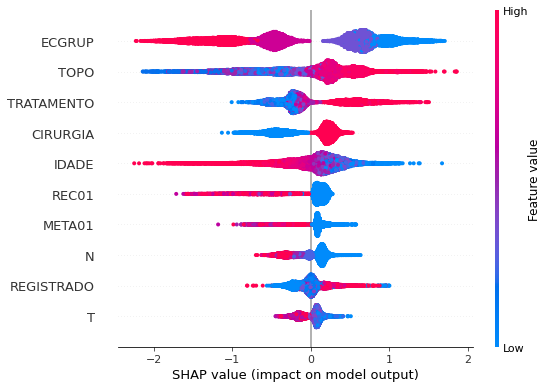

In [ ]:
plot_shap_values(xgb_sp_04_07, X_testSP_04_07, feat_SP_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2008 to 2011
xgb_sp_08_11 = XGBClassifier(max_depth=8, 
                             scale_pos_weight=0.795,
                             random_state=seed)

xgb_sp_08_11.fit(X_trainSP_08_11, y_trainSP_08_11)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=0.795)

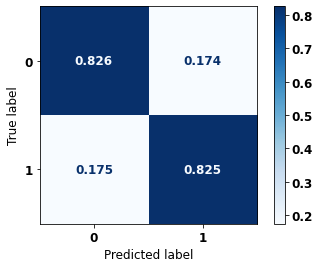


              precision    recall  f1-score   support

           0      0.811     0.826     0.818     11680
           1      0.839     0.825     0.832     12861

    accuracy                          0.825     24541
   macro avg      0.825     0.825     0.825     24541
weighted avg      0.826     0.825     0.825     24541



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_08_11, y_testSP_08_11)

> The confusion matrix obtained for the XGBoost, with SP data from 2008 to 2011, shows a good performance of the model, with 82% of accuracy.

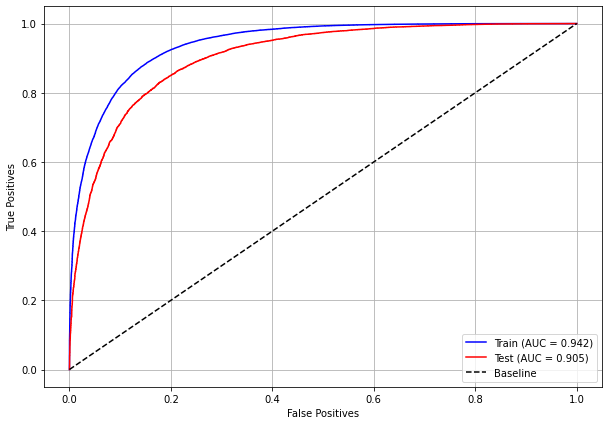

In [ ]:
plot_roc_curve(xgb_sp_08_11, X_trainSP_08_11, X_testSP_08_11, y_trainSP_08_11, y_testSP_08_11)

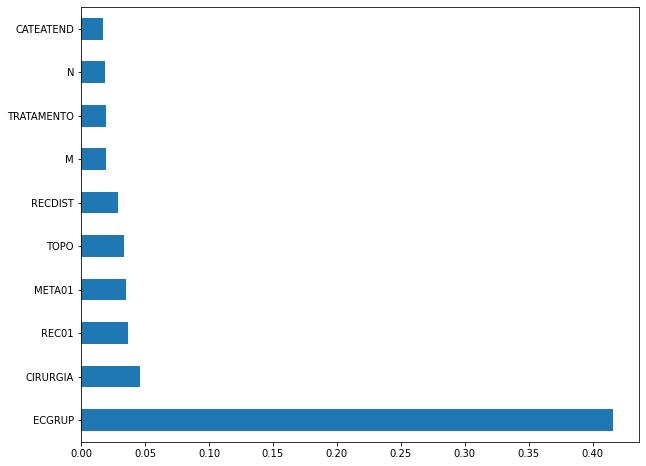

In [ ]:
plot_feat_importances(xgb_sp_08_11, feat_SP_08_11)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage over the others. Following we have `CIRURGIA`, `REC01` and `META01`. 

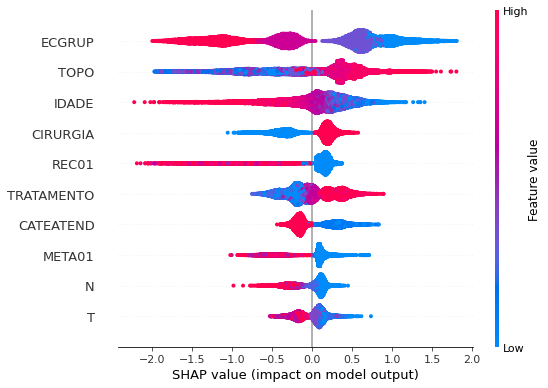

In [ ]:
plot_shap_values(xgb_sp_08_11, X_testSP_08_11, feat_SP_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# SP - 2012 to 2015
xgb_sp_12_15 = XGBClassifier(max_depth=8, 
                             random_state=seed,
                             scale_pos_weight=1.25)

xgb_sp_12_15.fit(X_trainSP_12_15, y_trainSP_12_15)

XGBClassifier(max_depth=8, random_state=10, scale_pos_weight=1.25)

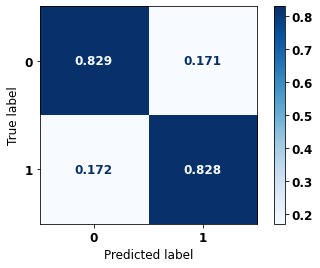


              precision    recall  f1-score   support

           0      0.864     0.829     0.846     12466
           1      0.786     0.828     0.807      9500

    accuracy                          0.828     21966
   macro avg      0.825     0.828     0.826     21966
weighted avg      0.830     0.828     0.829     21966



In [ ]:
display_confusion_matrix(xgb_sp_12_15, X_testSP_12_15, y_testSP_12_15)

> The confusion matrix obtained for the XGBoost, with SP data from 2012 to 2015, shows a good performance of the model, with 83% of accuracy.

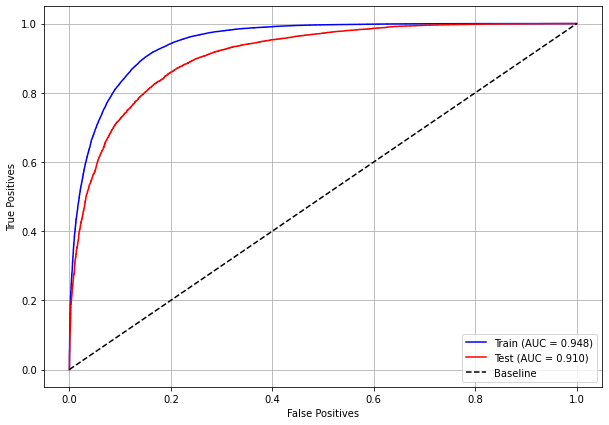

In [ ]:
plot_roc_curve(xgb_sp_12_15, X_trainSP_12_15, X_testSP_12_15, y_trainSP_12_15, y_testSP_12_15)

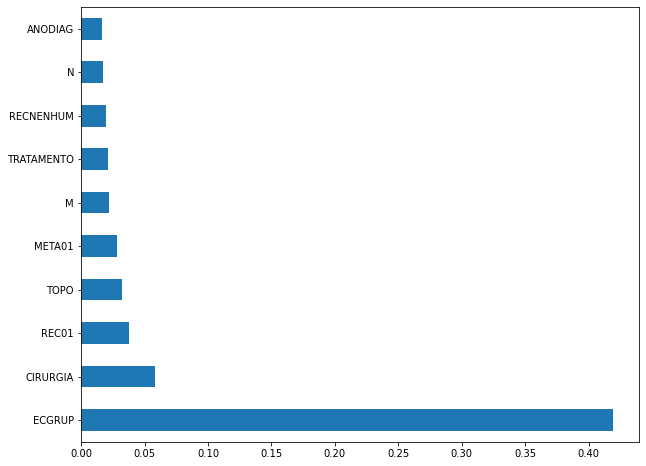

In [ ]:
plot_feat_importances(xgb_sp_12_15, feat_SP_12_15)

> Here we noticed that the most used feature was `ECGRUP`, with a good advantage. Following we have `CIRURGIA`, `REC01` and `TOPO`. 

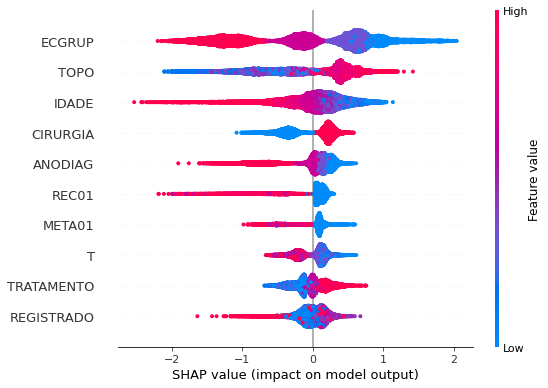

In [ ]:
plot_shap_values(xgb_sp_12_15, X_testSP_12_15, feat_SP_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

**Other states**

In [ ]:
# Other states - 2000 to 2003
xgb_fora_00_03 = XGBClassifier(max_depth=4, 
                               scale_pos_weight=0.792,
                               random_state=seed)

xgb_fora_00_03.fit(X_trainOS_00_03, y_trainOS_00_03)

XGBClassifier(max_depth=4, random_state=10, scale_pos_weight=0.792)

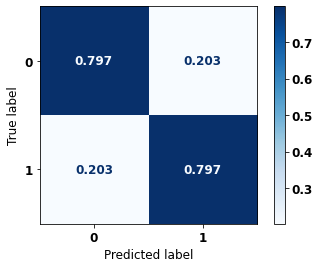


              precision    recall  f1-score   support

           0      0.788     0.797     0.792       419
           1      0.806     0.797     0.802       444

    accuracy                          0.797       863
   macro avg      0.797     0.797     0.797       863
weighted avg      0.797     0.797     0.797       863



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_00_03, y_testOS_00_03)

> The confusion matrix obtained for the XGBoost, with other states data from 2000 to 2003, also shows a good performance of the model, with 80% of accuracy.

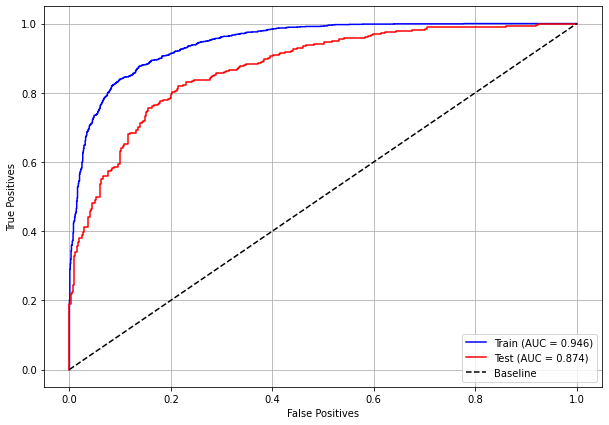

In [ ]:
plot_roc_curve(xgb_fora_00_03, X_trainOS_00_03, X_testOS_00_03, y_trainOS_00_03, y_testOS_00_03)

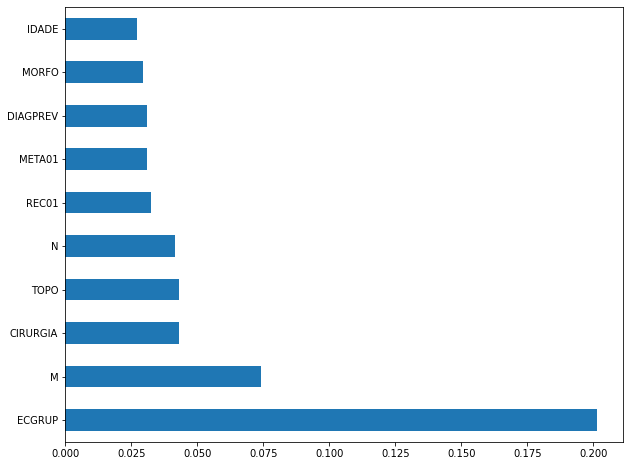

In [ ]:
plot_feat_importances(xgb_fora_00_03, feat_OS_00_03)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `M`, `CIRURGIA` and `TOPO`.

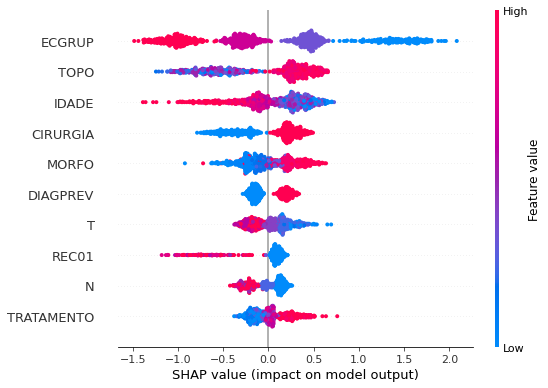

In [ ]:
plot_shap_values(xgb_fora_00_03, X_testOS_00_03, feat_OS_00_03)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2004 to 2007
xgb_fora_04_07 = XGBClassifier(max_depth=4, 
                               scale_pos_weight=0.8,
                               random_state=seed)

xgb_fora_04_07.fit(X_trainOS_04_07, y_trainOS_04_07)

XGBClassifier(max_depth=4, random_state=10, scale_pos_weight=0.8)

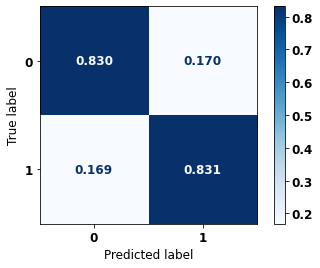


              precision    recall  f1-score   support

           0      0.811     0.830     0.820       528
           1      0.848     0.831     0.840       605

    accuracy                          0.831      1133
   macro avg      0.830     0.830     0.830      1133
weighted avg      0.831     0.831     0.831      1133



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_04_07, y_testOS_04_07)

> The confusion matrix obtained for the XGBoost, with other states data from 2004 to 2007, also shows a good performance of the model with 83% of accuracy.

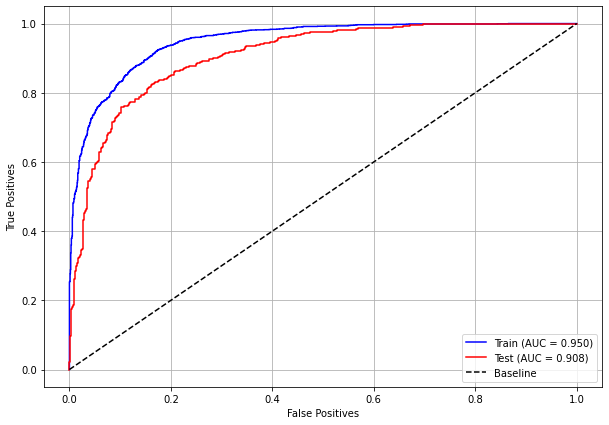

In [ ]:
plot_roc_curve(xgb_fora_04_07, X_trainOS_04_07, X_testOS_04_07, y_trainOS_04_07, y_testOS_04_07)

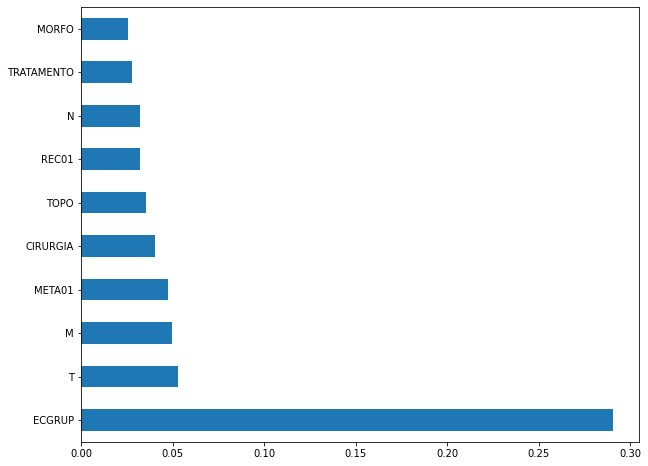

In [ ]:
plot_feat_importances(xgb_fora_04_07, feat_OS_04_07)

> Again we noticed that the most used feature was `ECGRUP`, with a good advantage. The following most important features were `T`, `M` and `META01`.

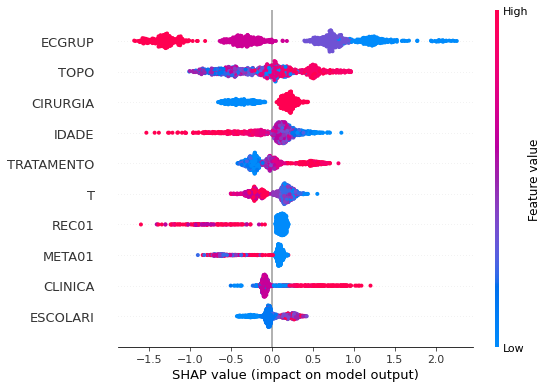

In [ ]:
plot_shap_values(xgb_fora_04_07, X_testOS_04_07, feat_OS_04_07)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2008 to 2011
xgb_fora_08_11 = XGBClassifier(max_depth=5, 
                               scale_pos_weight=0.87,
                               random_state=seed)

xgb_fora_08_11.fit(X_trainOS_08_11, y_trainOS_08_11)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=0.87)

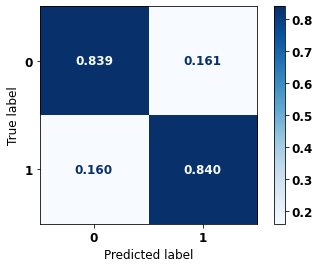


              precision    recall  f1-score   support

           0      0.818     0.839     0.828       604
           1      0.859     0.840     0.849       705

    accuracy                          0.840      1309
   macro avg      0.838     0.840     0.839      1309
weighted avg      0.840     0.840     0.840      1309



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_08_11, y_testOS_08_11)

> The confusion matrix obtained for the XGBoost, with other states data from 2008 to 2011, also shows a good performance of the model with 84% of accuracy.

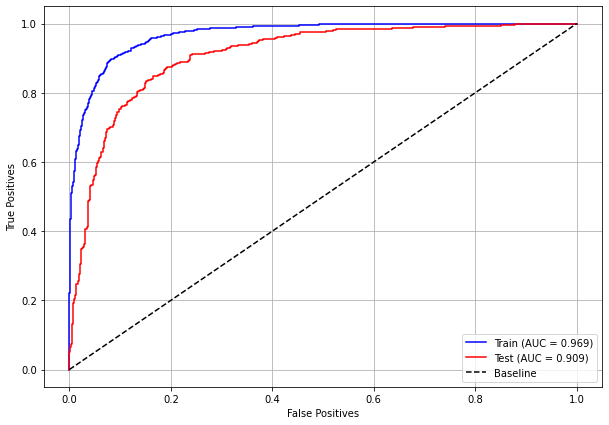

In [ ]:
plot_roc_curve(xgb_fora_08_11, X_trainOS_08_11, X_testOS_08_11, y_trainOS_08_11, y_testOS_08_11)

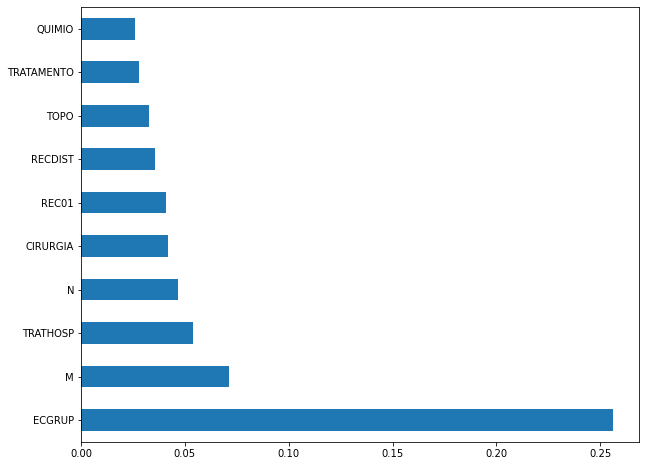

In [ ]:
plot_feat_importances(xgb_fora_08_11, feat_OS_08_11)

> Again we noticed that the most used feature was `ECGRUP`, but not with a lot of advantage. The following most important features were `M`, `TRATHOSP` and `N`.

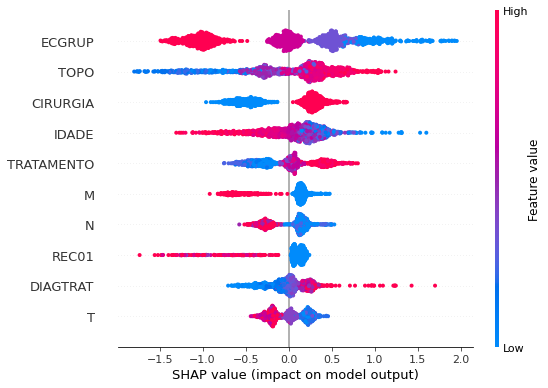

In [ ]:
plot_shap_values(xgb_fora_08_11, X_testOS_08_11, feat_OS_08_11)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

In [ ]:
# Other states - 2012 to 2015
xgb_fora_12_15 = XGBClassifier(max_depth=5, 
                               scale_pos_weight=0.88,
                               random_state=seed)

xgb_fora_12_15.fit(X_trainOS_12_15, y_trainOS_12_15)

XGBClassifier(max_depth=5, random_state=10, scale_pos_weight=0.88)

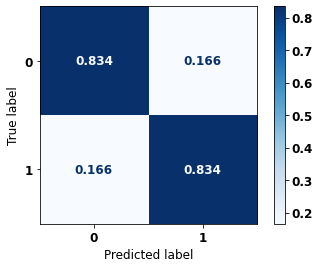


              precision    recall  f1-score   support

           0      0.846     0.834     0.840       664
           1      0.822     0.834     0.828       608

    accuracy                          0.834      1272
   macro avg      0.834     0.834     0.834      1272
weighted avg      0.834     0.834     0.834      1272



In [ ]:
display_confusion_matrix(xgb_fora_12_15, X_testOS_12_15, y_testOS_12_15)

> The confusion matrix obtained for the XGBoost, with other states data from 2012 to 2015, also shows a good performance of the model with 83% of accuracy.

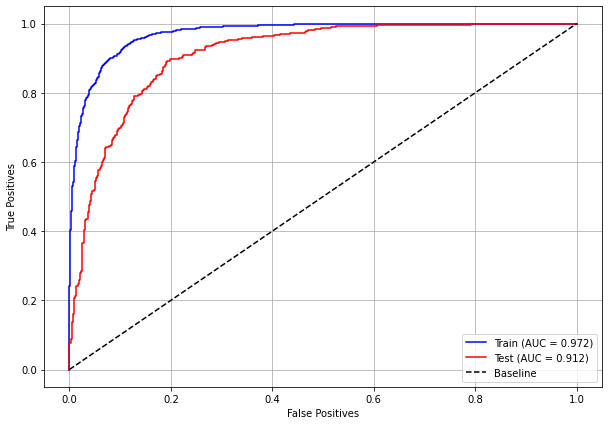

In [ ]:
plot_roc_curve(xgb_fora_12_15, X_trainOS_12_15, X_testOS_12_15, y_trainOS_12_15, y_testOS_12_15)

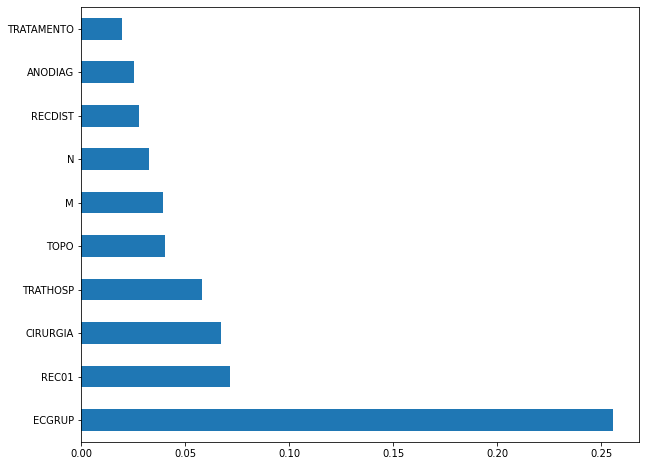

In [ ]:
plot_feat_importances(xgb_fora_12_15, feat_OS_12_15)

> The four most important features were `ECGRUP`, `REC01`, `CIRURGIA` and `TRATHOSP`.

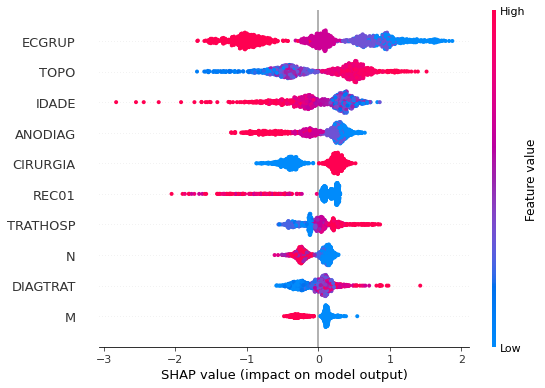

In [ ]:
plot_shap_values(xgb_fora_12_15, X_testOS_12_15, feat_OS_12_15)

Note that larger values of the `ECGRUP` column, shown in pink, have more influence for the model's prediction to be class 0, smaller values have greater weight for the prediction to be class 1. This behavior was expected, because the higher the clinical stage, worse is the stage of cancer. 

The other columns shown follow the same logic.

## **Testing models with data from other years**

We will use test data from the following years in the trained models for each set of years grouped together.

### **Random Forest SP for years 2000 to 2003**

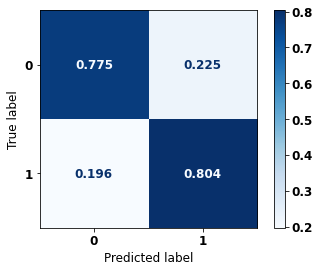


              precision    recall  f1-score   support

           0      0.792     0.775     0.783      9125
           1      0.787     0.804     0.795      9477

    accuracy                          0.789     18602
   macro avg      0.790     0.789     0.789     18602
weighted avg      0.789     0.789     0.789     18602



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_04_07, y_testSP_04_07)

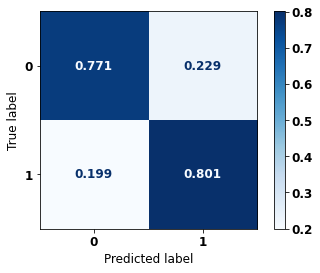


              precision    recall  f1-score   support

           0      0.779     0.771     0.775     11680
           1      0.794     0.801     0.797     12861

    accuracy                          0.787     24541
   macro avg      0.786     0.786     0.786     24541
weighted avg      0.787     0.787     0.787     24541



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_08_11, y_testSP_08_11)

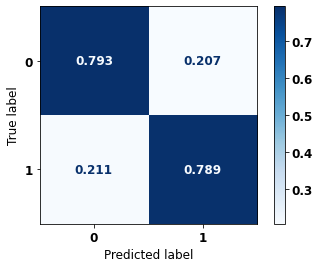


              precision    recall  f1-score   support

           0      0.831     0.793     0.812     12466
           1      0.744     0.789     0.766      9500

    accuracy                          0.791     21966
   macro avg      0.788     0.791     0.789     21966
weighted avg      0.793     0.791     0.792     21966



In [ ]:
display_confusion_matrix(rf_sp_00_03, X_testSP_12_15, y_testSP_12_15)

### **XGBoost SP for years 2000 to 2003**

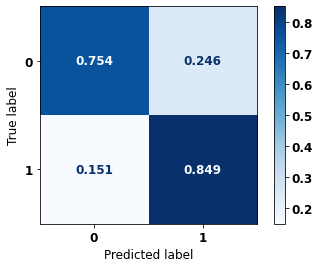


              precision    recall  f1-score   support

           0      0.828     0.754     0.789      9125
           1      0.782     0.849     0.814      9477

    accuracy                          0.802     18602
   macro avg      0.805     0.802     0.802     18602
weighted avg      0.805     0.802     0.802     18602



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_04_07, y_testSP_04_07)

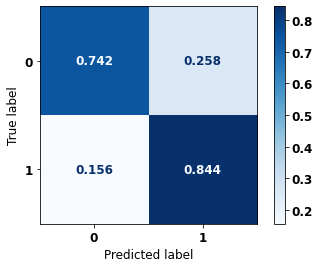


              precision    recall  f1-score   support

           0      0.812     0.742     0.776     11680
           1      0.783     0.844     0.812     12861

    accuracy                          0.796     24541
   macro avg      0.798     0.793     0.794     24541
weighted avg      0.797     0.796     0.795     24541



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_08_11, y_testSP_08_11)

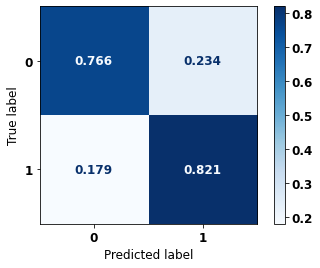


              precision    recall  f1-score   support

           0      0.849     0.766     0.805     12466
           1      0.727     0.821     0.771      9500

    accuracy                          0.790     21966
   macro avg      0.788     0.793     0.788     21966
weighted avg      0.796     0.790     0.790     21966



In [ ]:
display_confusion_matrix(xgb_sp_00_03, X_testSP_12_15, y_testSP_12_15)

### **Random Forest SP for years 2004 to 2007**

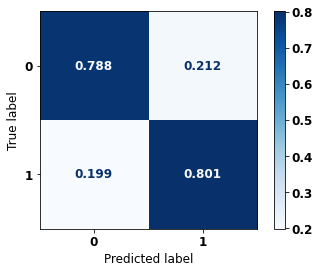


              precision    recall  f1-score   support

           0      0.783     0.788     0.785     11680
           1      0.806     0.801     0.804     12861

    accuracy                          0.795     24541
   macro avg      0.794     0.795     0.794     24541
weighted avg      0.795     0.795     0.795     24541



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_08_11, y_testSP_08_11)

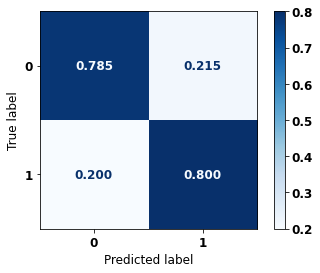


              precision    recall  f1-score   support

           0      0.838     0.785     0.810     12466
           1      0.739     0.800     0.768      9500

    accuracy                          0.791     21966
   macro avg      0.788     0.792     0.789     21966
weighted avg      0.795     0.791     0.792     21966



In [ ]:
display_confusion_matrix(rf_sp_04_07, X_testSP_12_15, y_testSP_12_15)

### **XGBoost SP for years 2004 to 2007**

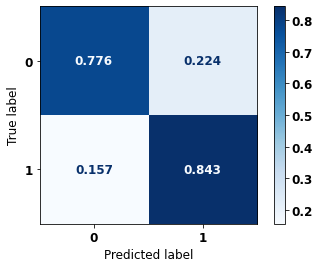


              precision    recall  f1-score   support

           0      0.818     0.776     0.797     11680
           1      0.806     0.843     0.824     12861

    accuracy                          0.811     24541
   macro avg      0.812     0.810     0.810     24541
weighted avg      0.812     0.811     0.811     24541



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_08_11, y_testSP_08_11)

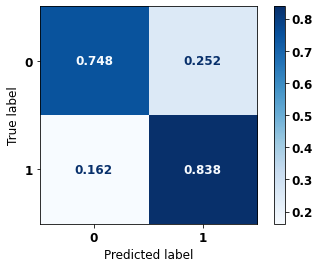


              precision    recall  f1-score   support

           0      0.858     0.748     0.799     12466
           1      0.717     0.838     0.772      9500

    accuracy                          0.787     21966
   macro avg      0.787     0.793     0.786     21966
weighted avg      0.797     0.787     0.788     21966



In [ ]:
display_confusion_matrix(xgb_sp_04_07, X_testSP_12_15, y_testSP_12_15)

### **Random Forest SP for years 2008 to 2011**

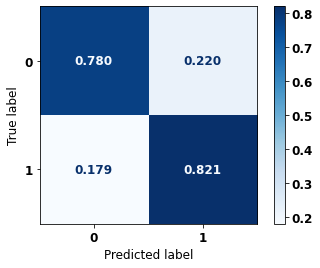


              precision    recall  f1-score   support

           0      0.851     0.780     0.814     12466
           1      0.740     0.821     0.778      9500

    accuracy                          0.798     21966
   macro avg      0.795     0.800     0.796     21966
weighted avg      0.803     0.798     0.798     21966



In [ ]:
display_confusion_matrix(rf_sp_08_11, X_testSP_12_15, y_testSP_12_15)

### **XGBoost SP for years 2008 to 2011**

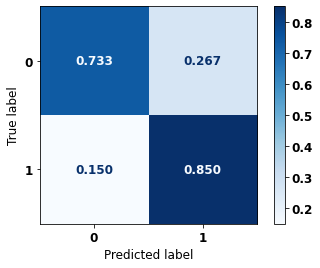


              precision    recall  f1-score   support

           0      0.865     0.733     0.794     12466
           1      0.708     0.850     0.773      9500

    accuracy                          0.784     21966
   macro avg      0.787     0.792     0.783     21966
weighted avg      0.797     0.784     0.785     21966



In [ ]:
display_confusion_matrix(xgb_sp_08_11, X_testSP_12_15, y_testSP_12_15)

### **Random Forest Other states for years 2000 to 2003**

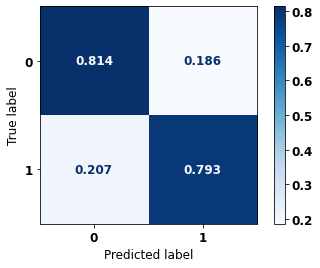


              precision    recall  f1-score   support

           0      0.775     0.814     0.794       528
           1      0.830     0.793     0.811       605

    accuracy                          0.803      1133
   macro avg      0.803     0.804     0.803      1133
weighted avg      0.805     0.803     0.803      1133



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_04_07, y_testOS_04_07)

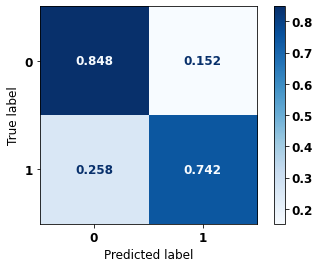


              precision    recall  f1-score   support

           0      0.738     0.848     0.789       604
           1      0.850     0.742     0.792       705

    accuracy                          0.791      1309
   macro avg      0.794     0.795     0.791      1309
weighted avg      0.798     0.791     0.791      1309



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_08_11, y_testOS_08_11)

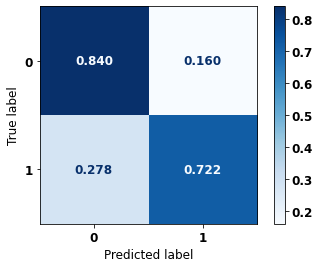


              precision    recall  f1-score   support

           0      0.768     0.840     0.802       664
           1      0.806     0.722     0.761       608

    accuracy                          0.784      1272
   macro avg      0.787     0.781     0.782      1272
weighted avg      0.786     0.784     0.783      1272



In [ ]:
display_confusion_matrix(rf_fora_00_03, X_testOS_12_15, y_testOS_12_15)

### **XGBoost Other states for years 2000 to 2003**

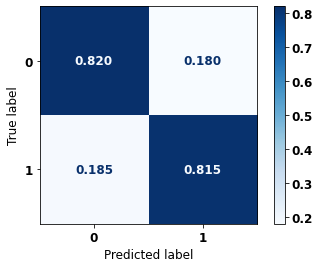


              precision    recall  f1-score   support

           0      0.794     0.820     0.807       528
           1      0.838     0.815     0.826       605

    accuracy                          0.817      1133
   macro avg      0.816     0.817     0.817      1133
weighted avg      0.818     0.817     0.817      1133



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_04_07, y_testOS_04_07)

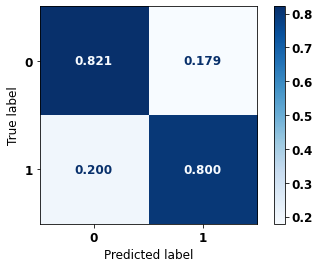


              precision    recall  f1-score   support

           0      0.779     0.821     0.799       604
           1      0.839     0.800     0.819       705

    accuracy                          0.810      1309
   macro avg      0.809     0.811     0.809      1309
weighted avg      0.811     0.810     0.810      1309



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_08_11, y_testOS_08_11)

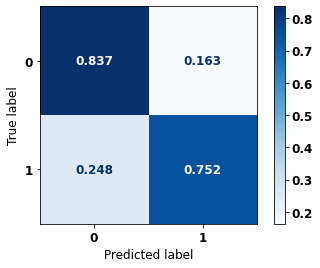


              precision    recall  f1-score   support

           0      0.786     0.837     0.811       664
           1      0.809     0.752     0.779       608

    accuracy                          0.796      1272
   macro avg      0.798     0.794     0.795      1272
weighted avg      0.797     0.796     0.796      1272



In [ ]:
display_confusion_matrix(xgb_fora_00_03, X_testOS_12_15, y_testOS_12_15)

### **Random Forest Other states for years 2004 to 2007**

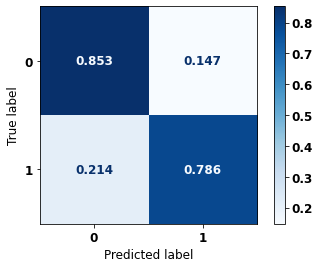


              precision    recall  f1-score   support

           0      0.773     0.853     0.811       604
           1      0.862     0.786     0.822       705

    accuracy                          0.817      1309
   macro avg      0.817     0.819     0.816      1309
weighted avg      0.821     0.817     0.817      1309



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_08_11, y_testOS_08_11)

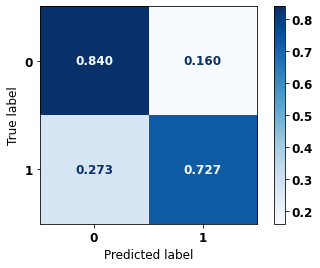


              precision    recall  f1-score   support

           0      0.771     0.840     0.804       664
           1      0.807     0.727     0.765       608

    accuracy                          0.786      1272
   macro avg      0.789     0.784     0.784      1272
weighted avg      0.788     0.786     0.785      1272



In [ ]:
display_confusion_matrix(rf_fora_04_07, X_testOS_12_15, y_testOS_12_15)

### **XGBoost Other states for years 2004 to 2007**

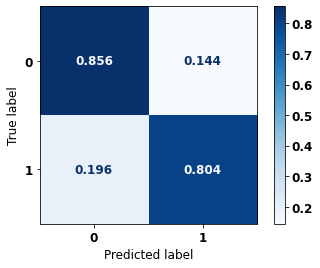


              precision    recall  f1-score   support

           0      0.789     0.856     0.821       604
           1      0.867     0.804     0.834       705

    accuracy                          0.828      1309
   macro avg      0.828     0.830     0.828      1309
weighted avg      0.831     0.828     0.828      1309



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_08_11, y_testOS_08_11)

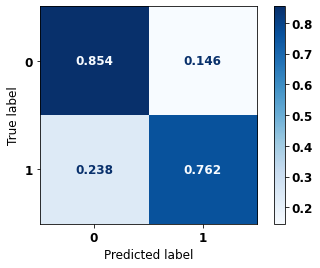


              precision    recall  f1-score   support

           0      0.796     0.854     0.824       664
           1      0.827     0.762     0.793       608

    accuracy                          0.810      1272
   macro avg      0.812     0.808     0.808      1272
weighted avg      0.811     0.810     0.809      1272



In [ ]:
display_confusion_matrix(xgb_fora_04_07, X_testOS_12_15, y_testOS_12_15)

### **Random Forest Other states for years 2008 to 2011**

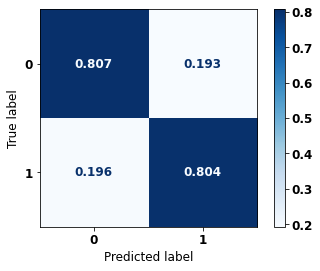


              precision    recall  f1-score   support

           0      0.818     0.807     0.813       664
           1      0.793     0.804     0.798       608

    accuracy                          0.806      1272
   macro avg      0.805     0.806     0.806      1272
weighted avg      0.806     0.806     0.806      1272



In [ ]:
display_confusion_matrix(rf_fora_08_11, X_testOS_12_15, y_testOS_12_15)

### **XGBoost Other states for years 2008 to 2011**

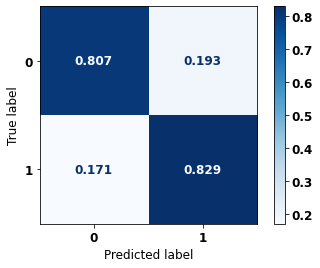


              precision    recall  f1-score   support

           0      0.838     0.807     0.822       664
           1      0.797     0.829     0.813       608

    accuracy                          0.818      1272
   macro avg      0.817     0.818     0.817      1272
weighted avg      0.818     0.818     0.818      1272



In [ ]:
display_confusion_matrix(xgb_fora_08_11, X_testOS_12_15, y_testOS_12_15)